# Коллаборативная фильтрация

## Цель работы

<ol>
    <li>Изучить возможности процедур работы с данными с использованием языка разработки Python</li>
<li>Разработать элементы функций рекомендательного сервиса на основе метода коллаборативной фильтрации</li>
</ol>

## 1. Подготовка данных для анализа

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('../07.Amazon Tools_and_Home_Improvement/07.Amazon Tools_and_Home_Improvement.csv', # путь к файлу
                      sep=',',      # разделитель данных в файле
                      header=0,  # номер строки с заголовками. header='None', если заголовки отсутствуют
                      #decimal=","   # разделитель дробной и целой частей
                     )
type(ratings)

pandas.core.frame.DataFrame

### 1.1. Количество записей и признаков

In [3]:
ratings

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A4IL0CLL27Q33,104800001X,D. Brennan,"[0, 1]","I hate it when my shirt collars, not otherwise...",5,Perfect for collar stay management,1390953600,"01 29, 2014"
1,A3Q5W5E7TDVLJF,104800001X,funnyc130,"[0, 0]",These little magnets are really powerful for t...,5,Neat,1369958400,"05 31, 2013"
2,A37KNOJXE2FU6,104800001X,Joseph Yonke II,"[0, 0]",I wanted something this small to mount on the ...,5,Very small and thin,1363132800,"03 13, 2013"
3,A3U4AFML9SZPWK,104800001X,"Leith Tussing ""I like tacos.""","[0, 0]",I use these to magnetize my Warhammer 40K mini...,5,Excellent hobby magnets,1371340800,"06 16, 2013"
4,A36Y7X194VWVKA,104800001X,Mark D.,"[23, 25]",They are soo freaking annoying!! Why?! You sp...,5,They're annoying... which is why they get five...,1376006400,"08 9, 2013"
...,...,...,...,...,...,...,...,...,...
134471,A1Q1Z7IR79G52A,B00LA96GLC,"Ann Ingersoll Madison Rain ""Ann""","[0, 0]",Super bright! Awesomely Comfortable. Easy to u...,5,Best headlamp you will ever buy!,1405468800,"07 16, 2014"
134472,A21T5C3KL41REL,B00LA96GLC,galbarran,"[0, 0]",I got this headlamp for my daughter since we r...,5,Light my kid up!,1405987200,"07 22, 2014"
134473,A2I8KUDXTC9WYI,B00LA96GLC,theresa,"[0, 0]",This is a real bright headlamp. I bought it f...,5,Very Bright Light.,1405814400,"07 20, 2014"
134474,AAOYA0DKWED4W,B00LA96GLC,WombatComputing,"[0, 0]",Easy to wear headlamp that's bright. Good for ...,5,Bright Lights,1405555200,"07 17, 2014"


В нашем наборе данных, в качестве субъектов(пользователей), выступает именно столбец "reviewerID", в котором записаны уникальные id пользователей, тогда как в столбце "reviewName" имена могут повторяться. В качестве объектов выступают "asin" (id товаров), overall - оценка

In [4]:
ratings[ratings['overall'] == 0]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime


In [5]:
ratings.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Количество строк и столбцов данных:

In [6]:
nrow = ratings.shape[0]
ncol = ratings.shape[1]
print ("Итого: " + str(nrow) + " записи, " + str(ncol) + " столбцов.")

Итого: 134476 записи, 9 столбцов.


### 1.2. Описание данных таблицы

Метод __describe()__ показывает основные статистические характеристики данных по каждому числовому признаку (типы int64 и float64): 
* count - число непропущенных значений, 
* mean - среднее арифметическое 
* std - стандартное отклонение (среднеквадратическое), 
* min, max - минимальное и максимальное значение 
* 0.25, 0.50, 0.75 квартили.
* unique - кол-во уникальных значения
* top - самое часто встречающееся значение
* freq - кол-во значений 'top'

In [7]:
ratings.describe() # описание для числовых значений

,overall,unixReviewTime
count,134476.000000,1.344760e+05
mean,4.365448,1.345108e+09
std,1.035565,6.772936e+07
min,1.000000,9.420192e+08
25%,4.000000,1.329869e+09
50%,5.000000,1.366157e+09
75%,5.000000,1.387498e+09
max,5.000000,1.406074e+09


In [8]:
ratings.describe(include=['object', 'bool'])  # описание для не числовых значений

,reviewerID,asin,reviewerName,helpful,reviewText,summary,reviewTime
count,134476,134476,133757,134476,134413,134476,134476
unique,16638,10217,15438,1654,134399,107584,4441
top,A14JBDSWKPKTZA,B006E0QAFY,Amazon Customer,"[0, 0]",works great,Works great,"01 7, 2014"
freq,142,504,1367,71890,3,415,281


Используем метод __.value_counts()__ для подсчета количества уникальных значений среди выставленных оценок.

In [9]:
rateCount =  ratings['overall'].value_counts().sort_index(ascending=True)
print (type(rateCount))
print (rateCount)

<class 'pandas.core.series.Series'>
1     5143
2     4962
3    10769
4    28336
5    85266
Name: overall, dtype: int64


Построим график распределения оценок

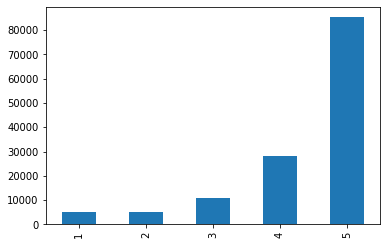

In [10]:
# Распределение оценок. Метод plot
rateCount.plot(kind='bar')

In [11]:
n_users = ratings["reviewerID"].unique().shape[0]
n_items = ratings["asin"].unique().shape[0]
print ("Уникальных Пользователей", n_users)
print ("Уникальных Инструментов и товаров для дома", n_items)
print ("Выставленных оценок", ratings.shape[0])
# Расчет доли заполнения оценками
print("Размер матрицы {} x {}, Элементов {}, Заполнено на {:%}".format (
    n_users, 
    n_items,
    n_users * n_items,
    len (ratings)/(n_users * n_items)
))

Уникальных Пользователей 16638
Уникальных Инструментов и товаров для дома 10217
Выставленных оценок 134476
Размер матрицы 16638 x 10217, Элементов 169990446, Заполнено на 0.079108%


In [12]:
userUniqArr = ratings["reviewerID"].unique()
userUniqList = userUniqArr.tolist()

print (userUniqList)

print ("")

itemUniqArr = ratings["asin"].unique()
itemUniqList = itemUniqArr.tolist()
itemUniqList.sort()
print (itemUniqList)

['A4IL0CLL27Q33', 'A3Q5W5E7TDVLJF', 'A37KNOJXE2FU6', 'A3U4AFML9SZPWK', 'A36Y7X194VWVKA', 'A2GD2HORAJHBK5', 'A7KVMEIDJP0JK', 'A3VRFONBPYVIY8', 'A3UOK4B9B2PCG9', 'AQ3ARAU1JBTQU', 'A1C8O2EUVPZJUO', 'A1NQI1M4BNOJYI', 'A2H2IP8SLZ3XQ7', 'A3B4QM00D6DQTC', 'A10UX582O51QUO', 'A2ROJNY48QN55E', 'A2CPII49YGABL2', 'A1FYZVQ6CU1406', 'A3JN96R8ZQ4X0P', 'A1H759XWF3B8G4', 'A1YJMG0QJXZLD4', 'A3NGABXDIB0POU', 'A2D1LPEUCTNT8X', 'A2ZK326GSTY6F4', 'ATNTC28I6IFJV', 'A10P1FCFG3SC8N', 'A3PT8IKBQXWT80', 'A2JF6IREXYM6HE', 'A2OT4VDS8QACNB', 'A1Q70K27GSE8U4', 'A3UKPBTB65LLH6', 'AG8FGAIPRBKIR', 'AYJUBKUE2OJFM', 'A2XPMMXO2L065Z', 'A3S3L24L3MMDXR', 'A10O49Q7T73RFM', 'A1K5MWZ0XLBTJZ', 'AKV4U2JCC6DLP', 'APNX875EY1FI1', 'A1XRKRGYYBI0LU', 'A1AABCWFPKRNYY', 'A3GCJ6B23SLSV2', 'A4GFA67FAZ5V1', 'A1XJJ8H8EEP76', 'AHGDSZCD88EIQ', 'A31BD4RXCON7QO', 'A2ALD2MD77NX5H', 'A7T7LSY3TN2F1', 'AKB5F44SK4AN9', 'A2GMZZ6TDYOHY7', 'AWA8IRL6AMDR8', 'A11GETCXA7UX9C', 'A1UOKAFJLULERV', 'A3TTYLS3M665MQ', 'AAFT3W7GU2U6U', 'A14Q1WGNF9DM3A', 'A2829N

## 2. Реализация метода коллаборативной фильтрации (User-based)

In [13]:
# Создать матрицу нужной размерности
data_matrix = np.zeros((n_users, n_items))

In [14]:
# Занесение оценок в матрицу
# Для каждой оценки, внести ее в матрицу в пересечение ...
for line in ratings.itertuples():
    indexLine = line[0]
    userID = line[1]
    itemID = line[2]
    overall = line[6]
    
    # получить индекс ИД_пользователя/товара в списке уникальных ИД
    indexForUser = userUniqList.index(userID)
    indexForItem = itemUniqList.index(itemID)
    
    # Индикация работы. вывод каждого N элемента обработки
    if indexLine % 5 == 0:
        print("Оценка №{}) {} -> {} = {}".format( indexLine, userID, itemID,  overall))
        
    # Внести оценку
    data_matrix[indexForUser, indexForItem] = overall

Оценка №0) A4IL0CLL27Q33 -> 104800001X = 5
Оценка №5) A2GD2HORAJHBK5 -> 104800001X = 5
Оценка №10) A1C8O2EUVPZJUO -> 1558706879 = 4
Оценка №15) A2ROJNY48QN55E -> 1558706879 = 4
Оценка №20) A1YJMG0QJXZLD4 -> 1558706879 = 4
Оценка №25) A10P1FCFG3SC8N -> 1933622709 = 5
Оценка №30) A3UKPBTB65LLH6 -> 1933622709 = 4
Оценка №35) A10O49Q7T73RFM -> 1933622709 = 5
Оценка №40) A1AABCWFPKRNYY -> 7109080609 = 5
Оценка №45) A31BD4RXCON7QO -> 7109080609 = 5
Оценка №50) AWA8IRL6AMDR8 -> 730000105X = 5
Оценка №55) AHGDSZCD88EIQ -> 730000105X = 5
Оценка №60) AVL03EBQWSS0L -> 730000105X = 3
Оценка №65) A1NA5HLVEYW8RL -> 7542904760 = 5
Оценка №70) A2JDJNAH5AF0ZI -> 7542904760 = 3
Оценка №75) A2W6B66HO0XCJP -> 917712412X = 4
Оценка №80) AJQFNOFTZ7GOX -> 9178904056 = 1
Оценка №85) A3Q8ADMHH5CVT8 -> 9178904056 = 5
Оценка №90) A13DQOJSW7UDYC -> B0000222UX = 5
Оценка №95) A1ILWPH1GHUXE2 -> B0000222UX = 4
Оценка №100) A2YJE1LWDVOZ52 -> B0000222UX = 5
Оценка №105) A2013JDMPUV6D9 -> B0000222UX = 5
Оценка №110) A3

Оценка №3680) A16Z9C8ESLGOPL -> B0000225A8 = 2
Оценка №3685) A3G54YTCB8OJCY -> B0000225AN = 5
Оценка №3690) AURBCGPUNZCOS -> B0000225DO = 2
Оценка №3695) A14KX5JQXO9J72 -> B0000225DO = 4
Оценка №3700) A3HYLTS29VN9V1 -> B0000225E0 = 5
Оценка №3705) A1PFJC6JDGI8DW -> B0000225E0 = 5
Оценка №3710) A1FCCX419ZCW4T -> B0000225E0 = 4
Оценка №3715) A25XZFC0A27OGF -> B0000225E0 = 1
Оценка №3720) A240YSGNSKUZW -> B0000225E0 = 5
Оценка №3725) A7BQ9AHUA1RXV -> B0000225E0 = 5
Оценка №3730) A4OVHEIU4J4S1 -> B0000225E0 = 4
Оценка №3735) A1SM9GRJK4B65L -> B0000225E0 = 4
Оценка №3740) A167FGHSNHYA62 -> B0000225E0 = 4
Оценка №3745) A3OPIA6LEKKG21 -> B0000225E0 = 5
Оценка №3750) A21M71QTD44GQ1 -> B0000225E0 = 5
Оценка №3755) A34Y0G9RRXQXZJ -> B0000225E0 = 5
Оценка №3760) A2HRHZ028OGBYW -> B0000225E0 = 5
Оценка №3765) AVOUK4QAS1J6I -> B0000225E0 = 5
Оценка №3770) A3UH5INU4H29P3 -> B0000225E0 = 5
Оценка №3775) A3OAX7IVSOSI7Y -> B0000225E0 = 5
Оценка №3780) AKKIGH65S6ILU -> B0000225E0 = 5
Оценка №3785) A3SW4

Оценка №4925) A2DTZUZK9YRJVK -> B00002N6FG = 5
Оценка №4930) A1TIZRJ9VN8DRB -> B00002N6FG = 5
Оценка №4935) A2JTJPYHBIB7ER -> B00002N6G8 = 4
Оценка №4940) A2D56U8LTXQYAV -> B00002N6G8 = 5
Оценка №4945) A1C94S4BGCEJ3R -> B00002N6GA = 5
Оценка №4950) A1NZKIY2YGXIPD -> B00002N6GA = 5
Оценка №4955) A205VZI061EG0E -> B00002N6GB = 5
Оценка №4960) A2DQMO6C9PS2P2 -> B00002N6GB = 5
Оценка №4965) A38BC5BMEQ314V -> B00002N6GB = 5
Оценка №4970) A1J0GL9HCA7ELW -> B00002N6IL = 5
Оценка №4975) A2AV4G6HWTIMRC -> B00002N6IL = 5
Оценка №4980) A14YDXPF2ZJ9T8 -> B00002N6IZ = 5
Оценка №4985) A2EV8A4U0VAKQ3 -> B00002N6IZ = 5
Оценка №4990) A3L2XR7I917OXH -> B00002N6IZ = 4
Оценка №4995) A21YJ523WUSXQ5 -> B00002N6J5 = 5
Оценка №5000) A1QLVSVT2L2JKQ -> B00002N6J5 = 5
Оценка №5005) AVM6OR01CPJNQ -> B00002N6JA = 5
Оценка №5010) A7EJERNB7IK3Z -> B00002N6JA = 2
Оценка №5015) A1JJKY9DHWNU3T -> B00002N6JA = 5
Оценка №5020) A1WDM0EFA58H69 -> B00002N6JA = 5
Оценка №5025) A1EOTB1WHLSW6G -> B00002N6JA = 5
Оценка №5030) A

Оценка №6245) A3MGUPD7C6CDIP -> B00002X29G = 5
Оценка №6250) AIN7V284R2CCR -> B00002X29G = 5
Оценка №6255) ALDYVPJB1J69N -> B00002X29G = 5
Оценка №6260) AV51GQV87LPY4 -> B00002X29G = 3
Оценка №6265) A247DD28851RE6 -> B00002X29G = 3
Оценка №6270) A2UFNB9REUD4I3 -> B00002X29G = 5
Оценка №6275) ABBZU1A3KW3RV -> B00002X29G = 5
Оценка №6280) A3U52V5ZAHZZKU -> B00002X29G = 5
Оценка №6285) ANOQD96JX3IR0 -> B00002X2ET = 5
Оценка №6290) A2XQ8WZMZ4HCMS -> B00002X2ET = 5
Оценка №6295) A1O1514HISOY49 -> B00002X2F2 = 5
Оценка №6300) AP1MP7YHWZRSX -> B00002X2F2 = 4
Оценка №6305) A2VLS18JQIBZUJ -> B00002X2F2 = 3
Оценка №6310) A1QO5255VVGROB -> B00002X2FX = 5
Оценка №6315) A1WXZ6BYBX0AC1 -> B00002X2FX = 5
Оценка №6320) A2SWGV59ZQJXG0 -> B00002X2GE = 4
Оценка №6325) A2W9JN2BIYF2VZ -> B00002X2GE = 5
Оценка №6330) A2YBSA4XO4BVBU -> B00002X2GN = 5
Оценка №6335) A209ARC6C1DJHJ -> B00002X2GQ = 5
Оценка №6340) A2RFJDMO5YOY8I -> B00002X2GQ = 5
Оценка №6345) A38LJG7YM2PDT2 -> B00002X2GQ = 5
Оценка №6350) A11DS

Оценка №7175) A15MBRLODZQSJK -> B0000302ZV = 5
Оценка №7180) A2RU4U1JZ3DMP5 -> B0000302ZV = 5
Оценка №7185) A2F3K3FCRVM1OQ -> B0000302ZV = 5
Оценка №7190) AUEB3S9MLFG9X -> B0000302ZV = 4
Оценка №7195) A1D696068E7EOU -> B0000302ZV = 4
Оценка №7200) AUWH6VAVUTF0A -> B0000302ZV = 5
Оценка №7205) A2KPDRY4YRR7WP -> B0000302ZV = 4
Оценка №7210) A29ATXTU7QMO7O -> B0000302ZV = 5
Оценка №7215) A29WAMDRBA65I1 -> B0000302ZV = 5
Оценка №7220) A22A6NB55KY8M3 -> B0000302ZV = 5
Оценка №7225) A1ZUA5JAR202PY -> B00003030O = 5
Оценка №7230) A1J0GL9HCA7ELW -> B000037X0F = 5
Оценка №7235) A161P7ILDGFA4X -> B000037X0F = 5
Оценка №7240) A1FPIPBIK95J2M -> B000037X0F = 5
Оценка №7245) A5IDKDOUATVXY -> B000037X0L = 5
Оценка №7250) A15XBG261ASIMK -> B000037X0L = 4
Оценка №7255) A22ZWGRDDXRJLD -> B000037X0L = 5
Оценка №7260) A1PUZGR591Z1WD -> B000037X0L = 1
Оценка №7265) A2MWB0ME9LH6KR -> B000037X0O = 4
Оценка №7270) A1RPTVW5VEOSI -> B000037X0O = 5
Оценка №7275) AU7FH8XG2MKDB -> B000037X0O = 5
Оценка №7280) A1LA

Оценка №8490) A33GNK4YENACDJ -> B00004SBBY = 4
Оценка №8495) AUENZR2HXXWC6 -> B00004SBBZ = 5
Оценка №8500) AYM76JWI220Z4 -> B00004SBBZ = 5
Оценка №8505) A366F86IDR5X73 -> B00004SBC4 = 3
Оценка №8510) A3V0WHMZ4SOCNK -> B00004SBC6 = 3
Оценка №8515) A1L8A318XB7DFE -> B00004SBCC = 4
Оценка №8520) A1H0628S83MR4W -> B00004SBCO = 4
Оценка №8525) A1UVJZR4DI1FNG -> B00004SBCU = 4
Оценка №8530) A3KTQ4S7FPKYTA -> B00004SBCU = 5
Оценка №8535) A13V1RH2837427 -> B00004SBCU = 5
Оценка №8540) A39XMXZBKNZ0AO -> B00004SBCU = 5
Оценка №8545) ABGRBSZDRRLR5 -> B00004SBCW = 1
Оценка №8550) A1XRENC5BHV5GB -> B00004SBCX = 5
Оценка №8555) A333636QFPT073 -> B00004SBCX = 5
Оценка №8560) ADSK8BS1IM224 -> B00004SBD2 = 5
Оценка №8565) A26Z77OE1QHDV0 -> B00004SBD6 = 5
Оценка №8570) A3RGFF12AS0F6I -> B00004SBDC = 4
Оценка №8575) A3CAXSXM8GHSXI -> B00004SBDD = 5
Оценка №8580) AKFE675S7CNT8 -> B00004SBDD = 5
Оценка №8585) A34O0KQV4QXWNQ -> B00004SBDE = 5
Оценка №8590) A1J1C60NQZICSH -> B00004SBDE = 5
Оценка №8595) ASZ5

Оценка №10035) AAJ1IYOUIHWF -> B00004UDI9 = 3
Оценка №10040) A3BIR2418I0M3N -> B00004UDIB = 5
Оценка №10045) AEV34C745C0FH -> B00004UDIB = 4
Оценка №10050) A12LCF7FJIIIVY -> B00004UDIB = 5
Оценка №10055) A3R65GJY5O0AG3 -> B00004UDIC = 3
Оценка №10060) A15ZZQXPYDBSTB -> B00004UDIW = 5
Оценка №10065) A2AOMB6S51TJID -> B00004UDJJ = 5
Оценка №10070) A2CEHT02KRIA46 -> B00004UDJJ = 5
Оценка №10075) A3BIR2418I0M3N -> B00004UDJK = 5
Оценка №10080) A9CXSUJTJVDGM -> B00004UDJK = 5
Оценка №10085) A15WLL60JXUU0M -> B00004UDJU = 1
Оценка №10090) A29NM1ECF38LMG -> B00004UDKL = 5
Оценка №10095) A1IJN0CERNHQUQ -> B00004UDKL = 1
Оценка №10100) A3O6TO8BC85CZ4 -> B00004UDKV = 1
Оценка №10105) ACJKXET91OMC9 -> B00004UDKV = 3
Оценка №10110) A3O6TO8BC85CZ4 -> B00004UDKW = 1
Оценка №10115) A9H5Z6FSEOKJG -> B00004UDKW = 5
Оценка №10120) A1TXRF98SLKL2O -> B00004VWKQ = 5
Оценка №10125) A2K9XFC31BCR5C -> B00004VWKQ = 3
Оценка №10130) A158M54UZXY20E -> B00004VWKQ = 5
Оценка №10135) AJ97IBS9M6HE7 -> B00004VWKQ = 5

Оценка №11555) A3VL2QBLUMHHO1 -> B00004Z4EB = 4
Оценка №11560) A2CYROCBFE8MYP -> B00004Z4EB = 5
Оценка №11565) A3M2XSG81C36PE -> B00004Z4EB = 5
Оценка №11570) A2QXKX3GST6BBJ -> B00004Z4EB = 5
Оценка №11575) A2TOLBNS4WZB3X -> B00004Z4EB = 5
Оценка №11580) A1AKL4HCVQ644U -> B00004Z4EB = 5
Оценка №11585) A3GRPJYWL6C7OF -> B00004Z4EB = 5
Оценка №11590) A369BU62O5EGDT -> B00004Z4EB = 4
Оценка №11595) A3PT8EKULK7C46 -> B00004Z4EB = 5
Оценка №11600) A1K9ZTXMHO4QFX -> B00004Z4H5 = 3
Оценка №11605) A2OXNP4H9VE751 -> B00004Z4HL = 5
Оценка №11610) A1INUATAQG85TJ -> B00004Z4HL = 5
Оценка №11615) A23RIQG5KB14YB -> B00004Z4HL = 4
Оценка №11620) AG4GZZJCR9KHB -> B00004Z4HL = 5
Оценка №11625) A20S66SKYXULG2 -> B00004ZARP = 5
Оценка №11630) A3D3AKLKM4GE7O -> B00004ZARP = 1
Оценка №11635) ARFVAE8LW077T -> B00004ZARP = 3
Оценка №11640) ATCY52ZP70FKP -> B00004ZARP = 5
Оценка №11645) A2013JDMPUV6D9 -> B00004ZARP = 5
Оценка №11650) AWJWCKB92RJX2 -> B000051WQV = 5
Оценка №11655) A3TLH5DIWDBZ9Q -> B000051WQV 

Оценка №13225) AA3HSQUO8G7V9 -> B00005RHPP = 5
Оценка №13230) AI532MGX9PMPL -> B00005RHPP = 5
Оценка №13235) A39XAXV9TPVDMD -> B00005RHPP = 4
Оценка №13240) A2BUL8PZ7NYVHU -> B00005RHPR = 2
Оценка №13245) A20O1Y3EQ4Q7SA -> B00005RHPR = 4
Оценка №13250) A23CI4YSY7M64H -> B00005RHQ0 = 5
Оценка №13255) A198T6IEUHUTZB -> B00005RHQ0 = 5
Оценка №13260) A5F1KRW33Z3PO -> B00005RHQM = 1
Оценка №13265) A1VI3NPOLMCOPM -> B00005RKNW = 5
Оценка №13270) A2WJ7GUT4K86NB -> B00005RKNW = 5
Оценка №13275) AHMIXQ9CQ1MRY -> B00005RW92 = 5
Оценка №13280) A1EXT3E8VDSK59 -> B00005RW92 = 4
Оценка №13285) A1S5RJZKAL6BU1 -> B00005RW92 = 3
Оценка №13290) A1VI3NPOLMCOPM -> B00005S7TD = 5
Оценка №13295) A348XHBP7VIJBH -> B00005S7TD = 3
Оценка №13300) ADAAINI6O5RH6 -> B00005S7TN = 5
Оценка №13305) AMFXXAOVV4CPJ -> B00005TPUZ = 5
Оценка №13310) A2H8TPBTK01I1G -> B00005TPUZ = 1
Оценка №13315) A18LMESO7EN5BQ -> B00005TPUZ = 5
Оценка №13320) ACM1WXFRFVFAN -> B00005TPUZ = 5
Оценка №13325) A1ZUA5JAR202PY -> B00005TPUZ = 4

Оценка №14840) A3006WHOAYJRLI -> B00006WNMI = 4
Оценка №14845) A3IYSIAKYOMKTO -> B00006WNMI = 4
Оценка №14850) AO4OIK8IVUXAP -> B00006WNMI = 1
Оценка №14855) A25Y4KW08CXT24 -> B00006WNMI = 3
Оценка №14860) A2F5PKODFXGUNL -> B00006WNMI = 5
Оценка №14865) A2MW5O8JHDH3AW -> B00006WP0Z = 5
Оценка №14870) A3MWWII9AH7ROA -> B00006WP0Z = 5
Оценка №14875) A11U0EXTH2DBUI -> B00006XMTP = 4
Оценка №14880) A14JBDSWKPKTZA -> B00006XMTT = 5
Оценка №14885) A3Q0K57TNNRGON -> B00006XMTT = 4
Оценка №14890) A3G2NW8R6F3QVN -> B00006XMTT = 5
Оценка №14895) A1JRG5NU1FHKEN -> B00006XMTT = 4
Оценка №14900) A2N8V8ENQS7OHM -> B00006XMTT = 5
Оценка №14905) AE855VBWOJVGY -> B00006XMTV = 5
Оценка №14910) A2L46U9X378VKP -> B00006XMTV = 5
Оценка №14915) A278HYEPNS5FV6 -> B00006XMTV = 5
Оценка №14920) A33GNK4YENACDJ -> B0000719VQ = 5
Оценка №14925) AYM76JWI220Z4 -> B0000719VQ = 5
Оценка №14930) A1TPQIM8DOH9JN -> B0000719VV = 5
Оценка №14935) A1VPCMJ38MDT1O -> B0000719W8 = 5
Оценка №14940) A339OJJ20YMH27 -> B0000719W8

Оценка №15725) A1TVFEIAK9EMID -> B00008WQ2H = 5
Оценка №15730) A1B1CKA88XH7LP -> B00008WQ2H = 5
Оценка №15735) AYTOTYTMWCSN -> B00008WQ2H = 5
Оценка №15740) A2D9VD96W8PADC -> B00008WQ2H = 5
Оценка №15745) A21021IG2U6480 -> B00008WQ2N = 5
Оценка №15750) A2WE4JPZIFA4K9 -> B00008WQ2P = 5
Оценка №15755) A3GNVSWNKEEQVO -> B00008WQ2P = 5
Оценка №15760) AO6QRTH78IJBZ -> B00008WQ2P = 5
Оценка №15765) A10VF4PAWTZA9F -> B00008WQ2P = 2
Оценка №15770) A1LA4K5JF78BER -> B00008WQ2P = 5
Оценка №15775) A3CYJFR9MTC77K -> B00008WQ2P = 5
Оценка №15780) A2VQYMEAKYN5NN -> B00008WQ2Q = 5
Оценка №15785) A2CG4NNWF9ARFA -> B00008WQ2X = 5
Оценка №15790) A1IPEJDMQNXJYF -> B00008WQ2Z = 1
Оценка №15795) A1MS8EOFY6WM63 -> B00008WQ2Z = 4
Оценка №15800) A3HN06XH68FJAL -> B00008WQ2Z = 4
Оценка №15805) A2DIUKFR3S2EUP -> B00008WQ2Z = 5
Оценка №15810) AZV0OFDBF0O34 -> B00008WQ2Z = 5
Оценка №15815) ARLAL02R8RHPW -> B00008WQ2Z = 5
Оценка №15820) A1OWZHEQ5UCSAN -> B00008WQ2Z = 5
Оценка №15825) A3DULMN1VGF58X -> B00008WQ30 =

Оценка №19215) A2X06FP2PQ6EK0 -> B0000DEZL9 = 2
Оценка №19220) A20D4RVJQKK43U -> B0000DEZL9 = 5
Оценка №19225) A31QCCZ52S3LQZ -> B0000DEZNB = 5
Оценка №19230) ABH6LRMTBBRF8 -> B0000DEZO5 = 4
Оценка №19235) AY7GNA4VBNK7F -> B0000DEZO9 = 3
Оценка №19240) A2013JDMPUV6D9 -> B0000DEZO9 = 5
Оценка №19245) A3SSSVZHCZDCVG -> B0000DG57B = 2
Оценка №19250) AMYU9H6TYEEX -> B0000DG57B = 5
Оценка №19255) A150ENQQVMXMZ1 -> B0000DG57B = 5
Оценка №19260) A2W0C6V6P0R0FN -> B0000DG57B = 4
Оценка №19265) A1YZ81OXHIYC2P -> B0000DG57B = 5
Оценка №19270) A2UHB6FGKZO7XB -> B0000DGARJ = 5
Оценка №19275) A3QL857ALV5RCJ -> B0000DGARJ = 5
Оценка №19280) A2O168CJIAEGL5 -> B0000DH4JK = 5
Оценка №19285) A3PVHZGGA99RCJ -> B0000DH4O6 = 4
Оценка №19290) A105TOJ6LTVMBG -> B0000DI241 = 3
Оценка №19295) A3G07AKUPSTJU2 -> B0000DI241 = 5
Оценка №19300) A3QNC09TXW7DY -> B0000DI241 = 5
Оценка №19305) A1D8JPKIZ9SZYL -> B0000DI241 = 5
Оценка №19310) A29XIHKX66HRFV -> B0000DI241 = 5
Оценка №19315) A20R03APZ2ITKR -> B0000DI241 =

Оценка №20705) A3VTX392CLO749 -> B0001HAFS4 = 4
Оценка №20710) A1LAAZUR8YFRW8 -> B0001IW50Y = 3
Оценка №20715) ATHM0ZECHGM7O -> B0001IW50Y = 5
Оценка №20720) ASEH02I5697XU -> B0001IW892 = 5
Оценка №20725) A20MP314TFVB02 -> B0001IW892 = 1
Оценка №20730) A1IU7S4HCK1XK0 -> B0001IW89C = 5
Оценка №20735) A2DUGL0KGPRPT9 -> B0001IX71U = 5
Оценка №20740) A2TSU5SOAOJDAA -> B0001IX71U = 5
Оценка №20745) A1KM3IPZ9H0JKZ -> B0001IX7TW = 5
Оценка №20750) A3GSTWRM0DOU86 -> B0001IX7TW = 5
Оценка №20755) A1QN8D7W80G93 -> B0001LMBMS = 5
Оценка №20760) AGGSBE6BX7JV -> B0001LMBMS = 3
Оценка №20765) A1CZ7PH2JNRUCL -> B0001LQLDS = 5
Оценка №20770) A25TT44FXNV0F0 -> B0001LQLDS = 5
Оценка №20775) AWKTXG2IRWTLZ -> B0001LQLE2 = 5
Оценка №20780) AD2977E0AOZRL -> B0001LQLE2 = 5
Оценка №20785) A2IW0IUZ9AE3I5 -> B0001LQXM2 = 5
Оценка №20790) AN30G4IKL1BMZ -> B0001LQXM2 = 4
Оценка №20795) A13DQOJSW7UDYC -> B0001LQY26 = 5
Оценка №20800) A9LJG3K5TEVPB -> B0001LQY26 = 2
Оценка №20805) A3FP9141P7DHT6 -> B0001LQY2Q = 4
О

Оценка №21840) A2AHI7N2BXB063 -> B00023S15G = 5
Оценка №21845) A26LD9FQHTM8ZH -> B00023S318 = 4
Оценка №21850) A2754UKBN6HW0E -> B00023S32W = 5
Оценка №21855) AOOU9K4YEPP5 -> B00023S336 = 1
Оценка №21860) AEURIASWCNTO8 -> B00023S336 = 5
Оценка №21865) A12Q4C0OADVPZQ -> B00023S8J0 = 5
Оценка №21870) A3L1VJMHFWONCB -> B00023S8JA = 5
Оценка №21875) A1K9ZTXMHO4QFX -> B00023S8JA = 5
Оценка №21880) A2HW7MPOSCN4Q4 -> B00023S8JA = 5
Оценка №21885) A238CFWQTG6L1O -> B00023S8JA = 5
Оценка №21890) A1JXNXW4MDXJKO -> B00023S8JA = 5
Оценка №21895) A3QZ7336US0YVF -> B00023S9U8 = 4
Оценка №21900) A1DC3564PRZI1V -> B00023S9U8 = 5
Оценка №21905) A381HM3XAV5SA -> B00024BJV8 = 5
Оценка №21910) AKVUBE6NBDYHY -> B00024JR6M = 5
Оценка №21915) A3HDJ1REEQ1YNP -> B00024JR6M = 5
Оценка №21920) A3CBMY6U450WJP -> B00024Z37E = 4
Оценка №21925) A31ERXE7M0EIVB -> B000256R2I = 5
Оценка №21930) AFV7JWAJMG5VG -> B000256R2S = 4
Оценка №21935) A3L3EMYSXPLCLL -> B000256R2S = 5
Оценка №21940) A1TECUFYBATMPP -> B000256RCS = 

Оценка №22775) A39NFRDRRX4LKL -> B0002H49BC = 5
Оценка №22780) A1ZA0ND031D5UK -> B0002H49BC = 5
Оценка №22785) A5GX4Y9HB6F76 -> B0002H49BC = 5
Оценка №22790) A2B54000WDS6D2 -> B0002H49BC = 5
Оценка №22795) A2U2RQ5F693TUR -> B0002H49BC = 5
Оценка №22800) A3NY355LONWAU1 -> B0002H49BC = 4
Оценка №22805) A1HY3Q4DBKHVJ0 -> B0002H49BC = 5
Оценка №22810) A26LG94YQUYKB6 -> B0002H49BC = 5
Оценка №22815) A213MNNCABU95F -> B0002H49BC = 5
Оценка №22820) AZFFY0NTIDD3Y -> B0002H49BC = 5
Оценка №22825) A1V4VVBQBFXRHC -> B0002H49BM = 5
Оценка №22830) A1FUVSOPHXLZF5 -> B0002H49BM = 5
Оценка №22835) A1CHOKV10NEI8X -> B0002H49BM = 4
Оценка №22840) A2FYRKF4BKK4N3 -> B0002H49BM = 5
Оценка №22845) A2NO4UHYF5TQJ3 -> B0002H49BM = 4
Оценка №22850) A2AW5V07ESKVCN -> B0002H49BM = 4
Оценка №22855) A1DA4SGFXSAS9S -> B0002H49BM = 5
Оценка №22860) A1YYBP7N57F1IR -> B0002H49BM = 5
Оценка №22865) AVXKXL0GFQHSL -> B0002H49BM = 4
Оценка №22870) A3QU89RBYRMR67 -> B0002H49BW = 5
Оценка №22875) A1I4UNUPSAPIF5 -> B0002H49BW

Оценка №24340) A2FYBROHG79IJR -> B0002TW1D8 = 5
Оценка №24345) A2U27A197AH87W -> B0002TW1D8 = 5
Оценка №24350) A2RLL7BESPS3RR -> B0002TW1D8 = 3
Оценка №24355) A4OXSQLCWYDFK -> B0002TW1D8 = 5
Оценка №24360) A3U31AZC7MO1JX -> B0002TW1D8 = 5
Оценка №24365) ATQ6C8I9L8EB -> B0002TW1D8 = 5
Оценка №24370) A27MW01JPNHJ6Q -> B0002TW1D8 = 4
Оценка №24375) A17IDRGDYBBTRR -> B0002TW1D8 = 5
Оценка №24380) A371ZZU2LXL3E0 -> B0002TW1D8 = 3
Оценка №24385) AH4A9FARCV302 -> B0002TW1D8 = 4
Оценка №24390) A3BSP0ZXLGJZK9 -> B0002TW1D8 = 5
Оценка №24395) A3TA1UJWRJF9NC -> B0002TW1D8 = 5
Оценка №24400) A3MKWC955BDWGI -> B0002TW1D8 = 4
Оценка №24405) A20P9BMRLT3DMF -> B0002TW1D8 = 5
Оценка №24410) A1FD519O6CMVDV -> B0002TW1D8 = 5
Оценка №24415) AKAOYM48DSUPL -> B0002TW1D8 = 5
Оценка №24420) A3AZUX1EW379D0 -> B0002TW1D8 = 5
Оценка №24425) A323YD5HIPCF1Q -> B0002TW1D8 = 4
Оценка №24430) AGARMY0GSHBVJ -> B0002TW1D8 = 5
Оценка №24435) AY6VXIWYGNATL -> B0002TW1D8 = 5
Оценка №24440) ASYVEM2Y7EZFN -> B0002TW1D8 = 5


Оценка №25360) A3N1BZ7190CI3J -> B0002YVBC0 = 5
Оценка №25365) A27T02B5KFANRE -> B0002YVBC0 = 5
Оценка №25370) A15GGP3M0EXZ4R -> B0002YVBC0 = 4
Оценка №25375) A1BLO9IOUFPHRV -> B0002YVBC0 = 5
Оценка №25380) A16PXGUBU33MIA -> B0002YVBC0 = 5
Оценка №25385) A2HRHF83I3NDGT -> B0002YVBC0 = 5
Оценка №25390) A3IQBM4EKQC1DI -> B0002YVDHS = 5
Оценка №25395) A1KKE6VX8VPWZK -> B0002YVDHS = 5
Оценка №25400) A3F3B1JPACN215 -> B0002YVDHS = 5
Оценка №25405) A2NWF0HC5Y2335 -> B0002YVDHS = 5
Оценка №25410) A2UB071WV9CC54 -> B0002YVDHS = 4
Оценка №25415) A13WOT3RSXKRD5 -> B0002YVK44 = 5
Оценка №25420) A2ME3XU2PV8LAU -> B0002YVK44 = 5
Оценка №25425) A26JK2M10K48TM -> B0002YVMEM = 5
Оценка №25430) A1UK8H3Z0AN2YA -> B0002YVPSK = 5
Оценка №25435) A33ZNSZSZ580D9 -> B0002YVPSK = 5
Оценка №25440) A2GIQGI2UXOZ4M -> B0002YVUOO = 5
Оценка №25445) AU2YKHB2QQN8V -> B0002YVWJW = 5
Оценка №25450) AROWB69NY0XYT -> B0002YVWJW = 5
Оценка №25455) A1CKSCU2E724ZU -> B0002YVWTW = 5
Оценка №25460) A26O27P7K3UGK8 -> B0002YVWT

Оценка №26325) A1XOK2E84T1WY -> B00065V4FO = 3
Оценка №26330) A3SAENHKO6RS6F -> B00065W8F4 = 1
Оценка №26335) A14EO36F2S1A90 -> B00065W8FE = 1
Оценка №26340) A26WW5UQ7JMQ5Y -> B00065W8G8 = 5
Оценка №26345) AOP5SQ898AX2D -> B00065W8G8 = 5
Оценка №26350) A37WVR9M1STQDU -> B00065W8G8 = 2
Оценка №26355) A1W22V0L8EJVFO -> B00065W8G8 = 4
Оценка №26360) A1QW9ZCEC2T2QQ -> B00065W8G8 = 2
Оценка №26365) A23PYCN8O9IUNH -> B00065W994 = 4
Оценка №26370) A3RIEJ1VQ7ENBR -> B00065WPP2 = 5
Оценка №26375) A3O5Z7AVNUJA0H -> B00065WPP2 = 3
Оценка №26380) A38GE00280SG8M -> B00065WPP2 = 5
Оценка №26385) ARLTWKV2AUJ2F -> B00065WPP2 = 5
Оценка №26390) A3KDRLIBWILPMJ -> B00065WPP2 = 5
Оценка №26395) A3VQPHBA2PFFP9 -> B00065WPP2 = 5
Оценка №26400) AXZ88MB4F4T0C -> B00065WPP2 = 4
Оценка №26405) A35ONL9ORL46UD -> B00065WPP2 = 4
Оценка №26410) AFK5SWZATPFJC -> B00065WPYI = 5
Оценка №26415) AFRAKGQQNJYON -> B000661868 = 4
Оценка №26420) AKWE0F620RRNV -> B0006618PO = 4
Оценка №26425) A2IUTQGMCLC3LT -> B0006618PO = 4

Оценка №27480) AEWPJNDK81GJ -> B0006NGZK0 = 5
Оценка №27485) AMMMME4CIAWYV -> B0006NGZK0 = 3
Оценка №27490) A13U60NGDEMYS1 -> B0006NGZK0 = 5
Оценка №27495) A6OL4ZKQFA2HW -> B0006NGZK0 = 4
Оценка №27500) A161CJ5WW8VMP8 -> B0006NGZK0 = 3
Оценка №27505) A6WHM5MMRGSD4 -> B0006NGZK0 = 4
Оценка №27510) A213J54E63SYOP -> B0006NGZK0 = 4
Оценка №27515) AUJCOSEKB2YOM -> B0006NGZK0 = 4
Оценка №27520) A26FZG34BVPEZ8 -> B0006O3TLW = 5
Оценка №27525) A3IJOIBS9MXIFZ -> B0006O3TLW = 5
Оценка №27530) A1NA6YKYX0LH9U -> B0006O4ADI = 5
Оценка №27535) AVXKXL0GFQHSL -> B0006O4ADI = 5
Оценка №27540) A2E6AHFDJ3JBAZ -> B0006O87LE = 5
Оценка №27545) A2LS0JBVD5THHA -> B0006OAFVE = 4
Оценка №27550) A26Q75RG5LOPJJ -> B0006OAFVE = 5
Оценка №27555) A3639X4SGKCY2M -> B0006OBFEK = 5
Оценка №27560) AQW0W263TKKOJ -> B0006OBFHM = 5
Оценка №27565) A2EPRUA8XAFFDX -> B0006OBFHM = 5
Оценка №27570) A2UWRZGT6VD4MB -> B0006OG8MY = 5
Оценка №27575) A259MPG6SOL02P -> B0006PJHM6 = 4
Оценка №27580) A25RTRAPQAJBDJ -> B0006PJHM6 = 4


Оценка №28455) AKU6UCK068L9H -> B0007PNP2I = 5
Оценка №28460) A3EV1YFMIHBY3P -> B0007PNP2I = 5
Оценка №28465) A2PSBX14CWQ0UP -> B0007PNP32 = 5
Оценка №28470) A31DQFICOUVICF -> B0007PP42M = 5
Оценка №28475) A3TE284VFHUTAW -> B0007Q752I = 5
Оценка №28480) A513VEBQYIFTV -> B0007Q752I = 5
Оценка №28485) A1AZ81GLBTN8JC -> B0007R6L8Q = 5
Оценка №28490) A3BQGBX3B8SG4Z -> B0007R6L8Q = 5
Оценка №28495) A23HRO2CCSFM20 -> B0007R6L8Q = 4
Оценка №28500) A2AV7Q95QGPTO0 -> B0007R6ZJ6 = 5
Оценка №28505) A3VW47C62Q0RML -> B0007R6ZJ6 = 5
Оценка №28510) A2GIQGI2UXOZ4M -> B0007R6ZXM = 5
Оценка №28515) A2DJEGDNWLI4OI -> B0007SMPD0 = 3
Оценка №28520) A34FGRZK561PBP -> B0007SMPD0 = 5
Оценка №28525) A6CNROHEEOHXU -> B0007SXHB4 = 5
Оценка №28530) A1M8AELV4X47K1 -> B0007SXHXM = 5
Оценка №28535) A1XAI4GO06F5X4 -> B0007SXI0O = 5
Оценка №28540) ABJNCFD48KB8 -> B0007SXI0O = 4
Оценка №28545) A29LTLDS2ZLTUU -> B0007U08JQ = 5
Оценка №28550) A3UMYHPG4TB3TS -> B0007UN5P0 = 5
Оценка №28555) A83RPS198D04S -> B0007UQ0X4 = 

Оценка №29390) AO4KJPY9BMJQL -> B0008GKYM0 = 5
Оценка №29395) ABM9CL72EGWKN -> B0008GKYM0 = 4
Оценка №29400) A3SCWXXJXBVJ05 -> B0008GKYM0 = 5
Оценка №29405) AVVK3WYO1TRZO -> B0008GKYM0 = 5
Оценка №29410) A27FPKOKRNWKJM -> B0008GKYM0 = 5
Оценка №29415) AG35JCCQWDRCS -> B0008GLW9Y = 4
Оценка №29420) AZZB7QPNM6ENC -> B0008GLW9Y = 5
Оценка №29425) ARUDTZ5BNUHA6 -> B0008IT5LO = 1
Оценка №29430) A3V20U36JZWEW -> B0008IUWDY = 5
Оценка №29435) ATV31ASSJT2JM -> B0008IUWDY = 5
Оценка №29440) AO923XTNDS4QB -> B0008JF0U8 = 4
Оценка №29445) A312KQILKPA8B4 -> B0008JF7XS = 5
Оценка №29450) A1QW9ZCEC2T2QQ -> B0008JF7XS = 5
Оценка №29455) A56441ZKPTRZF -> B0008JHBD2 = 4
Оценка №29460) AWJWZ9LS2IELL -> B0008KLNSA = 4
Оценка №29465) ABJNCFD48KB8 -> B0008KLNSA = 4
Оценка №29470) A3M8E27LZXKVM3 -> B00092CJC6 = 5
Оценка №29475) A3I4D0LI9JI9ZX -> B00092CJC6 = 5
Оценка №29480) A1CJKOIUX2UCN3 -> B000934F3Q = 5
Оценка №29485) A1XYOVJW5J06X5 -> B000934F3Q = 4
Оценка №29490) A8JO7MW47UENW -> B000936OTY = 5
Оценка

Оценка №30595) A2Q8GFSEUSGJ51 -> B0009VJGBY = 4
Оценка №30600) A1V5AG4RZ5COXB -> B0009VKJCY = 3
Оценка №30605) A2OEZIIK61GDW0 -> B0009VLFHW = 5
Оценка №30610) A3EW0H4L61EQR7 -> B0009VLFHW = 5
Оценка №30615) A2TPJYGF1FVL4L -> B0009VLFHW = 5
Оценка №30620) A2XOL8PQBN6SFT -> B0009VLFHW = 5
Оценка №30625) AY03VF066SAKR -> B0009VM7XS = 5
Оценка №30630) A2TNQZGYXTJT7W -> B0009W77E6 = 5
Оценка №30635) A3U1LHAFSINEBM -> B0009WD1L4 = 5
Оценка №30640) A25C2M3QF9G7OQ -> B0009WD1L4 = 5
Оценка №30645) A1NG74QJX6DKKZ -> B0009WD1L4 = 5
Оценка №30650) AO03T6WCBVBQE -> B0009WD1L4 = 5
Оценка №30655) A2W0C6V6P0R0FN -> B0009WD1L4 = 4
Оценка №30660) AKFE675S7CNT8 -> B0009WD1L4 = 5
Оценка №30665) AW6FQE5QRF2LM -> B0009WD1L4 = 5
Оценка №30670) A303A1LCW8IMOO -> B0009WDUDS = 3
Оценка №30675) A26DG05WFGH2V0 -> B0009WDUDS = 5
Оценка №30680) A3M6KV5PDU46YI -> B0009WDUDS = 5
Оценка №30685) A3QL2115DZCA62 -> B0009WDUDS = 5
Оценка №30690) A28HUBMSCXVQW0 -> B0009WFYLY = 5
Оценка №30695) A31DQFICOUVICF -> B0009WFYLY 

Оценка №31525) A1H759XWF3B8G4 -> B000AOVGV8 = 5
Оценка №31530) A54S9CIUV5VNB -> B000ARU9PO = 5
Оценка №31535) A2KF3H5304I4IA -> B000ARU9PO = 5
Оценка №31540) A5Q25ZRVYKKRB -> B000ARU9PO = 5
Оценка №31545) A24V2V44ODWH29 -> B000AS28UC = 4
Оценка №31550) A1MY6YCBL9HY3Y -> B000AS28UC = 5
Оценка №31555) A58437AUQICZF -> B000AS28UC = 5
Оценка №31560) AZ5JD0LW0K4G1 -> B000AS28UC = 5
Оценка №31565) AHWTFT5NDFMHA -> B000AS28UC = 5
Оценка №31570) A1G0EXGNH4X5E1 -> B000AS28UC = 5
Оценка №31575) AXIIG2W0PKN8P -> B000AS28UC = 5
Оценка №31580) ASW66VC3E3GQ5 -> B000AS28UC = 5
Оценка №31585) A3FFT9Q8R05L88 -> B000AS3Q0S = 4
Оценка №31590) A20X871A8JS810 -> B000ASBCK4 = 4
Оценка №31595) A34BZM6S9L7QI4 -> B000ASBCK4 = 5
Оценка №31600) A2PAWMGNOAULRU -> B000ASBCK4 = 5
Оценка №31605) A1TYK76YUEH1QX -> B000ASBCK4 = 3
Оценка №31610) A354RT0RUFDSMJ -> B000ASBCK4 = 5
Оценка №31615) A2IEOUD43VASZU -> B000ASBCK4 = 2
Оценка №31620) A3GIE1T699ELNL -> B000ASBCK4 = 4
Оценка №31625) A3FBYMN918HZTE -> B000ASBCK4 = 5

Оценка №32395) A1DN6B1QE3KH1V -> B000BD8LTS = 4
Оценка №32400) AWG2MTZXYQ02A -> B000BD8N0A = 5
Оценка №32405) A21HCSRB5QGJZO -> B000BD8NTQ = 5
Оценка №32410) A3OMCZ1CRVVB5H -> B000BD8NTQ = 5
Оценка №32415) A30IPG9D22QTV4 -> B000BD8NTQ = 4
Оценка №32420) A2J90KPDZ1G0JS -> B000BD8NTQ = 5
Оценка №32425) A3JJ3O96J59HD -> B000BDB4UG = 5
Оценка №32430) A3I23N33V323JQ -> B000BDB4UG = 5
Оценка №32435) AWPOWZJNQ2PHH -> B000BDB708 = 5
Оценка №32440) AC9B7AFGCYDNK -> B000BDB708 = 4
Оценка №32445) A12PPHYHY9P5FP -> B000BDB708 = 5
Оценка №32450) AHVHP0J5Z00EC -> B000BDDG7A = 4
Оценка №32455) AO4KJPY9BMJQL -> B000BDDG8O = 5
Оценка №32460) A1KYHI0VHNNAXJ -> B000BDDG8O = 5
Оценка №32465) A16LRSJUHO9SAQ -> B000BDDG8O = 5
Оценка №32470) A21I33801ULF3B -> B000BDDG8Y = 5
Оценка №32475) A2HR55XF8PYIWH -> B000BDDG8Y = 5
Оценка №32480) A1CMD08Z49PGKQ -> B000BDDG8Y = 5
Оценка №32485) A1TVFEIAK9EMID -> B000BDHAC2 = 5
Оценка №32490) AZI5BF9LW0M8T -> B000BDHAC2 = 5
Оценка №32495) A2XXVNTN0ZIRZH -> B000BDIRYC = 4

Оценка №33380) A2I6WVMSP85CYP -> B000BP8CAY = 4
Оценка №33385) A1AS0WT5Q7WE9M -> B000BP8CAY = 5
Оценка №33390) A2A4X545ERLS7H -> B000BPASJM = 2
Оценка №33395) A35WYW1ZSUVKYG -> B000BPASJM = 4
Оценка №33400) A2V7EO331SFUF6 -> B000BPCWQE = 5
Оценка №33405) A2RNPKETA5MEAN -> B000BPCWQE = 4
Оценка №33410) ALPAL92MWETD6 -> B000BPCWQE = 5
Оценка №33415) A36NFTN922LJT2 -> B000BPCWQE = 5
Оценка №33420) A22MANL4US4RMY -> B000BPDI7G = 5
Оценка №33425) A38AKSRTPDI337 -> B000BPEPSC = 3
Оценка №33430) A6KL17KKN0A5L -> B000BPEPSC = 5
Оценка №33435) A6VXZ1EEPRTLV -> B000BPEPSC = 4
Оценка №33440) AA1ZYCEKJGG3A -> B000BPF2AM = 4
Оценка №33445) A1CIPA74UBE442 -> B000BPG4FY = 5
Оценка №33450) A2GY8OFEBD9YT9 -> B000BPG4FY = 4
Оценка №33455) A3QVDUY41JH93M -> B000BPG4FY = 5
Оценка №33460) A3J84UZBZ63GMZ -> B000BPGP6M = 5
Оценка №33465) A3OFJES10PZGEH -> B000BPGP6M = 5
Оценка №33470) A1VT1U1SHUFITQ -> B000BPILBY = 5
Оценка №33475) A2QRXWCOZJ0PK8 -> B000BPILBY = 4
Оценка №33480) A11ED8O95W2103 -> B000BPILBY 

Оценка №35020) A27T4RQ3XA661C -> B000CBKWAU = 4
Оценка №35025) ALRCAGJOJ9583 -> B000CBWWHG = 5
Оценка №35030) A21SESEJ8E52B7 -> B000CBWWHG = 4
Оценка №35035) A1DD5LYFQ3ZAOK -> B000CC1S9I = 5
Оценка №35040) A14EO36F2S1A90 -> B000CC2KP4 = 5
Оценка №35045) A2SEHOBX4M0OZ0 -> B000CC2KP4 = 3
Оценка №35050) A5YCO02NI33WN -> B000CC2KP4 = 1
Оценка №35055) AAM8EXBYL9TPS -> B000CC2KP4 = 2
Оценка №35060) AFHE7HFA50S58 -> B000CC2KP4 = 4
Оценка №35065) A27XEJX3W4FCUK -> B000CC2KP4 = 4
Оценка №35070) A8MOCZ1TYQHBW -> B000CCXHJM = 5
Оценка №35075) ANJJMAWPGGYQS -> B000CCXHM4 = 5
Оценка №35080) A30K0NJH9QZ6CI -> B000CCXHM4 = 5
Оценка №35085) A147XC3AD0N0YK -> B000CCXHM4 = 5
Оценка №35090) A1AC8XSZQY1L4E -> B000CD1BOY = 5
Оценка №35095) A1NB2O2GCAVGDS -> B000CD1BOY = 1
Оценка №35100) A176JN87S0NRPG -> B000CD1BOY = 5
Оценка №35105) A24THDNM8ETIII -> B000CD1MVQ = 4
Оценка №35110) A3QB42QA8DCJ8 -> B000CD1MVQ = 4
Оценка №35115) AII15JV72ERKS -> B000CD1T0A = 5
Оценка №35120) A2C5IZGXS3F7G5 -> B000CD1T0A = 3


Оценка №36525) A1ER9FBAPA3O5Z -> B000E7ZLHQ = 4
Оценка №36530) A2BUL8PZ7NYVHU -> B000E7ZMTI = 4
Оценка №36535) AMVTID8YNL9ZS -> B000E7ZQ6W = 5
Оценка №36540) AVVK3WYO1TRZO -> B000E7ZQ6W = 4
Оценка №36545) A9LJG3K5TEVPB -> B000E7ZQ9E = 4
Оценка №36550) A2B54000WDS6D2 -> B000E841LM = 5
Оценка №36555) A29M09QBG9TZLP -> B000E841LM = 5
Оценка №36560) A1LOENXGC0WRI2 -> B000E8BFIO = 4
Оценка №36565) A2NJ359QUQ4PGS -> B000E8SZSC = 5
Оценка №36570) A2W437VMA8PMR -> B000E8SZSC = 5
Оценка №36575) A24RFFJAMSTSQP -> B000E8SZSC = 5
Оценка №36580) AYM76JWI220Z4 -> B000E8SZSC = 5
Оценка №36585) A2HHCYVYFD65BS -> B000E8VAIO = 5
Оценка №36590) A89Z4G9S94K3Y -> B000E8VAIO = 5
Оценка №36595) A3UQ8B01F54FLI -> B000E8VAIO = 4
Оценка №36600) A9FUQA04WK9N2 -> B000E8X4L0 = 5
Оценка №36605) A3NO9NOCWLFAAJ -> B000E8XG90 = 5
Оценка №36610) A1X1CEGHTHMBL1 -> B000E8XG9K = 5
Оценка №36615) AD8K962GI8ON9 -> B000E8XG9K = 5
Оценка №36620) AP5L1WDS5OZ3J -> B000E9BZ0Q = 4
Оценка №36625) A2WJ5XSE4I9F55 -> B000E9ZKDY = 4
О

Оценка №37425) A314SSFZKE4FVN -> B000ETUNEU = 5
Оценка №37430) AMYMIPOZ74WTB -> B000ETUNEU = 5
Оценка №37435) A1027EV8A9PV1O -> B000ETUNEU = 5
Оценка №37440) AKBVYIIHWI04B -> B000ETUNEU = 5
Оценка №37445) A1F0SSZV3IR0XX -> B000ETUNEU = 5
Оценка №37450) A1R9CWLA2QNKGT -> B000ETWIKM = 5
Оценка №37455) A33YCUFVPEZ6QV -> B000ETWQ4U = 4
Оценка №37460) A9GK1UXBH4TUG -> B000ETWQ4U = 5
Оценка №37465) A1F0SSZV3IR0XX -> B000ETWQ4U = 5
Оценка №37470) A1NUTYNSRRPXCU -> B000EU0ZB0 = 5
Оценка №37475) A2EIRAA1TZJWNU -> B000EU4HBO = 3
Оценка №37480) A204QN2VRUQA9B -> B000EU4HBO = 5
Оценка №37485) AT9PJHO9NMIYX -> B000EU4HBO = 5
Оценка №37490) A31O59AL48F85H -> B000EU4HBO = 5
Оценка №37495) A38OCEOMU8XOX4 -> B000EU4HBO = 5
Оценка №37500) A1YWQEMFGJRV7 -> B000EUCNVA = 5
Оценка №37505) A126VQYKKHJ631 -> B000EUCNVA = 5
Оценка №37510) A3JB65L9SSXRLJ -> B000EUJHGY = 5
Оценка №37515) A1RFZGWX46N8H7 -> B000EVO7C2 = 5
Оценка №37520) A3BKFAMEAH4Z0E -> B000EVO7C2 = 4
Оценка №37525) A2ILPQ1Q9MMTUI -> B000EVO7C2 =

Оценка №38400) A30KNLUAYQ73F2 -> B000FBLRVA = 5
Оценка №38405) A2HHQVQTQDHV9O -> B000FBLRVA = 4
Оценка №38410) A1TEKD2X0066DI -> B000FBLRVU = 5
Оценка №38415) A1H8DIMJJRD121 -> B000FBLRVU = 5
Оценка №38420) A3R176MS1YXXV9 -> B000FBLRW4 = 5
Оценка №38425) ANTSC8UV4RJU6 -> B000FBLRWE = 5
Оценка №38430) A5TLO478MAIE1 -> B000FBLRWE = 5
Оценка №38435) A3M9J48HKKAB6C -> B000FBLRWE = 5
Оценка №38440) A1B0NL8UWAELI7 -> B000FBLRWE = 5
Оценка №38445) A37KG9AQK1PN10 -> B000FBLRWE = 5
Оценка №38450) A2C7TFO11RMNJW -> B000FBQC1K = 3
Оценка №38455) AQCFQRVZLP5L5 -> B000FBQC1K = 5
Оценка №38460) A1F1MHOM30HUSR -> B000FBQEQ8 = 5
Оценка №38465) ALS9E01HVAVNM -> B000FBT3UC = 5
Оценка №38470) A40VNOGQOTKE4 -> B000FBT3UC = 4
Оценка №38475) A2NEOHRAIAEEVB -> B000FBT3UC = 3
Оценка №38480) A2KIYHQIUKRJP8 -> B000FCEOX2 = 5
Оценка №38485) A1D0E8YF295O3 -> B000FCGS0Y = 5
Оценка №38490) A738JOSKSFY9W -> B000FCGS0Y = 5
Оценка №38495) AITYM4706P93 -> B000FCIMFS = 5
Оценка №38500) AT85EZK6JSRI9 -> B000FCIMFS = 4
Оц

Оценка №40620) A184O84WKP1YV5 -> B000GR37WU = 5
Оценка №40625) A35KQOGQNFWV35 -> B000GR37WU = 5
Оценка №40630) A5NA8I02DWUXE -> B000GR37WU = 5
Оценка №40635) AZFFY0NTIDD3Y -> B000GR37WU = 5
Оценка №40640) A8QFA8E0UVHY4 -> B000GR38FG = 5
Оценка №40645) A26TMVQ3X42A5Z -> B000GR4AHQ = 5
Оценка №40650) A10A6OFJ01704G -> B000GR4AHQ = 5
Оценка №40655) A216VDO5BCPX4X -> B000GSKGRI = 4
Оценка №40660) A3V2U3HTSLV89Z -> B000GT9XBM = 5
Оценка №40665) A7Y64ICNNWLZ2 -> B000GTMZHG = 5
Оценка №40670) A1RG6DXHRLUGDI -> B000GTMZHG = 5
Оценка №40675) A2RDI91JJM1KPT -> B000GTMZHG = 5
Оценка №40680) A2US90YCDZ047L -> B000GTOUG0 = 5
Оценка №40685) A3P5M5U8HSQP5R -> B000GTP6W2 = 3
Оценка №40690) A1MQG6XNGS94BC -> B000GTP6W2 = 5
Оценка №40695) AP23EQD44LPFD -> B000GUDAVA = 4
Оценка №40700) A2KTJW0MZ0R8PM -> B000GUDIBM = 5
Оценка №40705) A5PS5MKS1KU4Y -> B000GUDIBM = 4
Оценка №40710) A1A78K7LB3LCJ5 -> B000GUDIBM = 2
Оценка №40715) A2MI9M5AM37SR3 -> B000GUDIBM = 5
Оценка №40720) A22CW0ZHY3NJH8 -> B000GUDIBM = 

Оценка №41555) A1OB2H416ARLFJ -> B000H85UQ4 = 4
Оценка №41560) A3KKMR2NISUND4 -> B000H8U4F6 = 5
Оценка №41565) AT8TS7XTO8TIE -> B000H94F6E = 5
Оценка №41570) A81NGIU3Z2FGE -> B000H94F6E = 4
Оценка №41575) A132ETQPMHQ585 -> B000H94F6E = 5
Оценка №41580) A16C35JVPPC42E -> B000H94F6E = 4
Оценка №41585) A1XN1D2FGCQC8E -> B000H94F6E = 4
Оценка №41590) APPYQ6TGZ1TL2 -> B000H94F6E = 5
Оценка №41595) A10XL35S79Z1GM -> B000H94F6E = 5
Оценка №41600) A1AZQCVCDBQP6 -> B000H94F6E = 3
Оценка №41605) AFY8QLS51NVI3 -> B000H98TC0 = 4
Оценка №41610) A1MG9IQUFXMW64 -> B000H98TC0 = 4
Оценка №41615) A1T3ABYJNZZN7C -> B000HA9O96 = 5
Оценка №41620) A3ETIHCNQX77Y6 -> B000HA9O96 = 5
Оценка №41625) A29NLTAGH0O30R -> B000HA9O96 = 4
Оценка №41630) A31BTPHCQCE8WB -> B000HAB82M = 5
Оценка №41635) A3DGWKQFZ11K9P -> B000HAB82M = 3
Оценка №41640) A3N27L13CWJ9HY -> B000HACY70 = 3
Оценка №41645) AVFJ327UXPXLF -> B000HACY70 = 4
Оценка №41650) A26LD9FQHTM8ZH -> B000HACY70 = 3
Оценка №41655) A21SESEJ8E52B7 -> B000HACY70 = 

Оценка №43055) A11FPEIUER01G6 -> B000I1KJT8 = 5
Оценка №43060) A2MNW09F9RJ94A -> B000I1KJT8 = 4
Оценка №43065) A20ZLDHGXMVT8H -> B000I1KJT8 = 5
Оценка №43070) AMXH56OAVOJ30 -> B000I1O9OE = 5
Оценка №43075) A2YV4OGKEV7N8J -> B000I1O9OE = 5
Оценка №43080) AAZIXQ6DE9YUD -> B000I1O9OE = 5
Оценка №43085) A2BBO7IHDC0FEK -> B000I1O9OE = 4
Оценка №43090) A18LYPL0W42J65 -> B000I1O9OE = 5
Оценка №43095) A1JQH0ET96PPQE -> B000I1O9OE = 5
Оценка №43100) A1T68WT4MUWQ3K -> B000I1O9OE = 1
Оценка №43105) ATK0TPOYO0OHF -> B000I1QA6E = 5
Оценка №43110) A39D7ONPOORMUT -> B000I1QA6E = 5
Оценка №43115) A3D0HMC6RQT0N0 -> B000I1RXHE = 4
Оценка №43120) A339D0QQYH0ZRG -> B000I1Z3A8 = 3
Оценка №43125) A2ZYMISE67R60J -> B000I2079E = 5
Оценка №43130) A2L98F33PDW6UV -> B000I2079E = 5
Оценка №43135) A20AKDW2I3LH1B -> B000I2079E = 5
Оценка №43140) A2KS0XOY3WHGL4 -> B000I2079E = 5
Оценка №43145) A2USY5SXCPEAMY -> B000I2079E = 5
Оценка №43150) A1IIQO2453V234 -> B000I2079E = 5
Оценка №43155) AQL79UQ1GUJ5W -> B000I2079E 

Оценка №45690) A17R8NRH2UTZ40 -> B000JV3I2M = 3
Оценка №45695) A3EF2L5FYAR2E -> B000JV5XCA = 5
Оценка №45700) A314I79QGN1WOL -> B000JWD16E = 5
Оценка №45705) A1Y4Q4NZD6HMT0 -> B000JWD16E = 5
Оценка №45710) A1I3U97KUPQB7M -> B000JWD16E = 4
Оценка №45715) A30QIFNUYOKJTS -> B000JWD16E = 5
Оценка №45720) A338Q3WEAIL52S -> B000JWD16E = 5
Оценка №45725) A256T5PCQ0UZIM -> B000JWUT6O = 3
Оценка №45730) A2ZCV3VGADCUZK -> B000JWUT6O = 5
Оценка №45735) A2OR94VN7XQCUO -> B000JYJBTI = 2
Оценка №45740) A1LJW1CZOTG0ES -> B000JZY45S = 4
Оценка №45745) A28YMQH26AX2KN -> B000K1GYC2 = 4
Оценка №45750) A30JMT9NV377ZT -> B000K1OHBC = 4
Оценка №45755) A1L95XFBIMJ66Y -> B000K1OHBC = 5
Оценка №45760) A173E67DTI967D -> B000K1Q2TW = 4
Оценка №45765) A1N0A7TU4PID76 -> B000K29S5G = 5
Оценка №45770) A13ZX9KRP2E2HO -> B000K2C87G = 5
Оценка №45775) A226S9J2GR4625 -> B000K2EG1C = 4
Оценка №45780) A1U7MPHVW80CPJ -> B000K2EG1C = 3
Оценка №45785) A32ZS0T9V124SL -> B000K2IG36 = 5
Оценка №45790) A2B427WBK10VH9 -> B000K2IG

Оценка №47030) A1UFMV63EYME8K -> B000LBK7WO = 5
Оценка №47035) A3U957QE63B2M0 -> B000LBK7WO = 5
Оценка №47040) A1RUSZ1QVZ6U3K -> B000LBK7WO = 4
Оценка №47045) A34OJWGNJAOPUZ -> B000LC2PO6 = 4
Оценка №47050) A19VISO9EHD1OM -> B000LC2PO6 = 5
Оценка №47055) AW3DCBYGF9F -> B000LC2PO6 = 5
Оценка №47060) AWCWQ5N8EB1XW -> B000LC63XU = 5
Оценка №47065) ACM1WXFRFVFAN -> B000LC63XU = 3
Оценка №47070) A1CVTQTYEVUHIF -> B000LC63XU = 5
Оценка №47075) AZV0OFDBF0O34 -> B000LC63XU = 1
Оценка №47080) AC1YLEFC9AN5X -> B000LC63XU = 5
Оценка №47085) AKFE675S7CNT8 -> B000LC63XU = 5
Оценка №47090) A3HGJVEXYZ8AWM -> B000LDC3R4 = 5
Оценка №47095) A10CGGF8HTVNL9 -> B000LDDFG2 = 5
Оценка №47100) A3BMUBUC1N77U8 -> B000LDGNCU = 5
Оценка №47105) AF5JMWWNOCBPK -> B000LDGNCU = 5
Оценка №47110) A3F3EU9XVZ81SC -> B000LDGNCU = 5
Оценка №47115) A1LNISCJBDOHXW -> B000LDH3JC = 5
Оценка №47120) A25TT44FXNV0F0 -> B000LDH3JC = 5
Оценка №47125) ACQYIC13JXAOI -> B000LDH3JC = 4
Оценка №47130) A251YK72P5YBKS -> B000LDIJ72 = 4
Оц

Оценка №47965) AT8TS7XTO8TIE -> B000LVKNU0 = 5
Оценка №47970) A18Z7ICRLVHBBP -> B000LVKNU0 = 5
Оценка №47975) A3B6R1PYR8BVO2 -> B000LVKNU0 = 5
Оценка №47980) A2I85TDI7XF3C3 -> B000LVKNU0 = 5
Оценка №47985) A3FCG8UXEV0OPD -> B000LWAX2C = 5
Оценка №47990) A36STUKO48873O -> B000LWAX2C = 5
Оценка №47995) A77FX03YYDYRY -> B000LWAX2C = 4
Оценка №48000) A25C2M3QF9G7OQ -> B000LWHXBG = 3
Оценка №48005) A1NIGUK4M2ST8 -> B000LWHXBG = 4
Оценка №48010) A2KHG3JOFXQ4CE -> B000LWHXBG = 3
Оценка №48015) A2H5QF8TJGTY6B -> B000LWI8RE = 5
Оценка №48020) A1ZHXA82M75IBW -> B000LWI8RE = 1
Оценка №48025) ALHC64J88LVWO -> B000LWI8RE = 3
Оценка №48030) A1D27BCSYV7VWH -> B000LWIOI2 = 5
Оценка №48035) A2NSXY5L42ZUGO -> B000LWIOI2 = 4
Оценка №48040) A2HMCRTD2G0BXO -> B000LWIQ08 = 5
Оценка №48045) A2XXVNTN0ZIRZH -> B000LWIQ08 = 5
Оценка №48050) A2PNBB4GXRG14K -> B000LWIQ08 = 5
Оценка №48055) A1A6150D9550E5 -> B000LWIQ1C = 4
Оценка №48060) A2XX2A4OJCDNLZ -> B000LWIQ1C = 5
Оценка №48065) A30SZ5HVLKTN45 -> B000LWIRE8 

Оценка №48830) A14398ZNGS0FFX -> B000MNJJ66 = 5
Оценка №48835) A11KQADBYE0UZL -> B000MNJJ66 = 4
Оценка №48840) A2AEZQ3DGBBLPR -> B000MNJJ66 = 4
Оценка №48845) A38X91ZTMU114H -> B000MOIDA8 = 5
Оценка №48850) ANELIW7NPT2XJ -> B000MOIDA8 = 1
Оценка №48855) A3P1IKQF48X2CQ -> B000MOIDA8 = 5
Оценка №48860) A7BSNFPA2Y167 -> B000MPLVVA = 3
Оценка №48865) A1921VTJMN8VEN -> B000MPLVVA = 4
Оценка №48870) AEV34C745C0FH -> B000MPLVVA = 4
Оценка №48875) A3H9EHF0JG4TZE -> B000MPLVVA = 4
Оценка №48880) A2VE8QRUEIKPBW -> B000MPLVVA = 5
Оценка №48885) A1UJO4UYRI277S -> B000MPLVVA = 4
Оценка №48890) A2JFIS260YMD4V -> B000MPMF5G = 3
Оценка №48895) A184O84WKP1YV5 -> B000MPMF5G = 4
Оценка №48900) A361LIUPBZ368Q -> B000MPMF5G = 5
Оценка №48905) A3FYG5ADFGIYSB -> B000MPO6OY = 1
Оценка №48910) A1JZFGZEZVWQPY -> B000MPP558 = 3
Оценка №48915) A15JEHADFOYKPS -> B000MPP558 = 3
Оценка №48920) A2U0MGFAVWTB0N -> B000MPP558 = 4
Оценка №48925) AZ5DXYFKTN7VC -> B000MPQ2S2 = 5
Оценка №48930) A1IU7S4HCK1XK0 -> B000MPQ2S2 

Оценка №49760) A2XDY2UYPM3XBJ -> B000NICEUI = 5
Оценка №49765) A13DQOJSW7UDYC -> B000NICEVW = 5
Оценка №49770) AKNTHOKT9EGZA -> B000NID9X4 = 4
Оценка №49775) A29GWIJL72GXXZ -> B000NID9X4 = 4
Оценка №49780) A1ISHWLOR97EP -> B000NID9X4 = 5
Оценка №49785) A9WR1VGC988P5 -> B000NID9X4 = 4
Оценка №49790) AEXGAWPIV0GOV -> B000NIDADS = 4
Оценка №49795) A32VUK5VY3V11D -> B000NIDADS = 5
Оценка №49800) A2CWUM49ZWMGEY -> B000NIDIXA = 5
Оценка №49805) A1651GJDSCAB80 -> B000NIDIXA = 5
Оценка №49810) A29G64NXCV1FJ7 -> B000NIFB94 = 5
Оценка №49815) AOBPWFC8IE9UX -> B000NIFB94 = 5
Оценка №49820) A38M8BXPBJCWDC -> B000NIFC7K = 5
Оценка №49825) A3A9SVUA52Q0ND -> B000NIFC7K = 5
Оценка №49830) AVXC6UHG42PPW -> B000NIFC7K = 5
Оценка №49835) ABPNZ9RKXOP0E -> B000NIFJKA = 5
Оценка №49840) A3VFT14904CUGV -> B000NIFJKA = 5
Оценка №49845) A21MJPTISAR7MF -> B000NIFJQE = 4
Оценка №49850) A2I8LFSN2IS5EO -> B000NIFJQE = 5
Оценка №49855) A2GYV87WW0DMSN -> B000NIFJQE = 5
Оценка №49860) A2YOI67EI4N4D -> B000NIFJQE = 5


Оценка №51050) A1D07LRA0TIEYU -> B000NPR2P8 = 5
Оценка №51055) A343LYS4IEVHBM -> B000NPR2P8 = 5
Оценка №51060) A34NDOCY7O206P -> B000NPR2R6 = 4
Оценка №51065) A2OECBTX7KM6FJ -> B000NPR2T4 = 5
Оценка №51070) A1PVETQSYLK82U -> B000NPR2U8 = 4
Оценка №51075) A2G802DC2EOBBR -> B000NPR2U8 = 5
Оценка №51080) A2I8LFSN2IS5EO -> B000NPR2U8 = 5
Оценка №51085) A1MNN0ZMHYPJDU -> B000NPR2U8 = 5
Оценка №51090) A3V4ZRLNTEOI1C -> B000NPR2U8 = 5
Оценка №51095) A1JQDCX4LDKBZ3 -> B000NPR2U8 = 5
Оценка №51100) AZWXG6KBXXC2N -> B000NPR2U8 = 3
Оценка №51105) A175XXVMLQA98A -> B000NPR2U8 = 4
Оценка №51110) A3SCWXXJXBVJ05 -> B000NPR2U8 = 5
Оценка №51115) AMR24U2MU082P -> B000NPR2U8 = 4
Оценка №51120) A1JVFV1VAA08X -> B000NPR2U8 = 5
Оценка №51125) A2XRMQA6PJ5ZJ8 -> B000NPR2U8 = 5
Оценка №51130) A2GMUKWP5PXECI -> B000NPR2U8 = 4
Оценка №51135) A3TBMAWIIHKHFN -> B000NPR2U8 = 3
Оценка №51140) A241NQZGW8JTUS -> B000NPR2XA = 4
Оценка №51145) A1YUDSBH9P3HPN -> B000NPR2Z8 = 4
Оценка №51150) A2GMUKWP5PXECI -> B000NPR2Z8

Оценка №52510) A2BVLMFC3TZ6L1 -> B000O8OTNC = 5
Оценка №52515) A3VJQYEAASITET -> B000O8OTNC = 4
Оценка №52520) A3M1PLEYNDEYO8 -> B000O8OTNC = 5
Оценка №52525) A1LYDMJ55BBQJB -> B000O8OTNC = 5
Оценка №52530) AME4BC0Z69SYV -> B000O8OTNC = 4
Оценка №52535) A49RSMGCPA123 -> B000O8OTNC = 4
Оценка №52540) A1CHFI97JJA6F4 -> B000O8OTNC = 5
Оценка №52545) A1X1CEGHTHMBL1 -> B000O8OTNC = 5
Оценка №52550) A1GHZZBEY4BUFR -> B000O8OTNC = 5
Оценка №52555) AKLUFVL8A311U -> B000O8OTNC = 5
Оценка №52560) A2O695ZP9627M3 -> B000O8OTNC = 5
Оценка №52565) AEJAGHLC675A7 -> B000O8OTNC = 5
Оценка №52570) A2KPJ9V8TDMBCW -> B000O8OTNC = 5
Оценка №52575) A29MQLMIY85XZ -> B000O8OTNC = 5
Оценка №52580) A22QEJ0WFXXBN -> B000O8OTNC = 5
Оценка №52585) A23RIQG5KB14YB -> B000O8OTNC = 5
Оценка №52590) A3V52KPSMAKIQS -> B000O8OTNC = 5
Оценка №52595) A3BCRA22ZXLFB8 -> B000O8OTNC = 3
Оценка №52600) AWYOWZKRBKQHQ -> B000O8OTNC = 5
Оценка №52605) A3CAEFTGDIDHD0 -> B000O8OTNC = 1
Оценка №52610) A31BD4RXCON7QO -> B000O8OTNC = 5

Оценка №53415) A22604N1XZ9JRW -> B000P1OA1O = 3
Оценка №53420) A2KGDROANO7LTA -> B000P1OA1O = 5
Оценка №53425) A2ZMIPZCWKO16D -> B000P1OA1O = 5
Оценка №53430) A2VFN33XFSDW9C -> B000P1OA1O = 3
Оценка №53435) A21G3UN7I88EMQ -> B000P1OA1O = 3
Оценка №53440) A1XAXEL581ZQY3 -> B000P1OA1O = 4
Оценка №53445) A3TDCGXFKF1JZL -> B000P1OA1O = 5
Оценка №53450) A35EIZ0JS0DNOC -> B000P1OA1O = 5
Оценка №53455) A11ULAZ4B5ZXC8 -> B000P1OA1O = 5
Оценка №53460) A3LQDYVAAHHV2T -> B000P274CU = 5
Оценка №53465) AEMJTZW8VPPIP -> B000P49BX8 = 1
Оценка №53470) A3VBV0SY31K4VM -> B000P49BX8 = 5
Оценка №53475) A7Z6OM871YWF2 -> B000P49BX8 = 4
Оценка №53480) AWWXG1AHVW98O -> B000P49BX8 = 4
Оценка №53485) A9H5Z6FSEOKJG -> B000P49BX8 = 5
Оценка №53490) A115BSSBW0KERB -> B000P49BX8 = 1
Оценка №53495) A3UC2M9DFOX0M -> B000P49NCC = 1
Оценка №53500) AZG6CV3B3279V -> B000P49NCC = 5
Оценка №53505) A26M5O53PHZTKN -> B000P49NCC = 5
Оценка №53510) A15PQ1LSLA0CK0 -> B000P49NCC = 5
Оценка №53515) AGK71OWRMFGLA -> B000P49NCC = 5

Оценка №55005) A3VT6G8TOSEX33 -> B000QZ3CWC = 5
Оценка №55010) A18UVHCREY2RE2 -> B000QZ3CWC = 5
Оценка №55015) A2OV160P8QD6G8 -> B000R2JZ4I = 3
Оценка №55020) A1M1Y5UGONAW06 -> B000R2JZ4I = 4
Оценка №55025) A2WV5UZEPWN5JH -> B000R2JZ4I = 3
Оценка №55030) A3JHJDG6P7NNOM -> B000R4EPDM = 4
Оценка №55035) A27BS98GRLW0F9 -> B000R4EPDM = 3
Оценка №55040) A2AV4G6HWTIMRC -> B000R4EPDM = 4
Оценка №55045) A30VKO3JKSUTFG -> B000R6RLAY = 5
Оценка №55050) ABPP6J9PWJ25O -> B000R6TW24 = 2
Оценка №55055) AXYNK4OZLBAB4 -> B000R7LZGO = 5
Оценка №55060) A1O1AJOJQLNHT4 -> B000R7LZH8 = 5
Оценка №55065) A2UXYK1JXAN35J -> B000R7PM36 = 5
Оценка №55070) A2NQF3W42GHID8 -> B000R7PM36 = 1
Оценка №55075) A3GQKB1KF0CRPE -> B000R7PM36 = 5
Оценка №55080) A1LWLJCD7J3BR1 -> B000R7PM36 = 4
Оценка №55085) A1PG70NH85K859 -> B000R7PM36 = 1
Оценка №55090) AS6ICSVRO68GD -> B000R7PM36 = 4
Оценка №55095) A3RGFU84C0AX7P -> B000R7PM36 = 4
Оценка №55100) A1EXGUV8MMVC65 -> B000R7PM36 = 5
Оценка №55105) A7J1NJ0YQOBTZ -> B000R7PM36 

Оценка №55895) A1BSO9E3ZGRKV6 -> B000RKQ1NI = 5
Оценка №55900) A18LZ6VHS4DK69 -> B000RKQ1NI = 2
Оценка №55905) A3VYOC9AN7HSVL -> B000RKQ1NI = 5
Оценка №55910) A3NFKHAAA6TNOP -> B000RKQ1NI = 5
Оценка №55915) A3CH96BKZA87G8 -> B000RKQ1O2 = 2
Оценка №55920) A470GX7D53EMK -> B000RKQ1O2 = 5
Оценка №55925) A2HFFOI0PYEKPR -> B000RKQ1O2 = 5
Оценка №55930) A1N1CHT4IHT7J1 -> B000RKQ1O2 = 5
Оценка №55935) A1DVQEDUR2Z7GV -> B000RKQ1O2 = 4
Оценка №55940) ATK7JSHTMG52C -> B000RKS04G = 5
Оценка №55945) A2ZCAAFL0MTN9 -> B000RKS04G = 5
Оценка №55950) A9GK1UXBH4TUG -> B000RKS04G = 5
Оценка №55955) A2RIG0KLVMX2MS -> B000RKS04G = 5
Оценка №55960) A39L35PUI58CFY -> B000RKS07I = 5
Оценка №55965) A1SG87ID3KJRJ9 -> B000RKS07I = 5
Оценка №55970) A3ARHSR68DTNWT -> B000RKS07I = 5
Оценка №55975) A3PVDDZKDUTXCY -> B000RKS07I = 4
Оценка №55980) AENRE9BP7LJMK -> B000RKS07I = 4
Оценка №55985) A1Q0RDBY0297X1 -> B000RKS07I = 5
Оценка №55990) A3U52V5ZAHZZKU -> B000RKS07I = 5
Оценка №55995) A1WHOMG3HGTGC5 -> B000RLFDJA =

Оценка №56885) A2ASP462CGXSMN -> B000T2P2PM = 5
Оценка №56890) A301HFA2O8DQHU -> B000T2P2PM = 5
Оценка №56895) A3OS5M8BO19GWK -> B000T41MH2 = 2
Оценка №56900) A7MVNXD31LBOA -> B000T41MH2 = 4
Оценка №56905) A1YZP1OGEXXTEA -> B000T4FL7Y = 5
Оценка №56910) A2Y6V1Q5B13GGO -> B000T4FL7Y = 2
Оценка №56915) AQA5SUNRVZ75M -> B000T4G4QQ = 5
Оценка №56920) A2FZBYWHKD7RTO -> B000T5NHWY = 3
Оценка №56925) A2C414S9OF4AOC -> B000T68ZUM = 5
Оценка №56930) A3TNRYFKTZ7K67 -> B000T68ZUM = 5
Оценка №56935) A2XRXIJAM9DE73 -> B000T7Q6OI = 5
Оценка №56940) A3R2M5ABAYL63P -> B000T7Q6OI = 4
Оценка №56945) A13CZ8CTDBAY68 -> B000T89LSA = 4
Оценка №56950) A5ZYUPTRSRKX4 -> B000T89LSA = 5
Оценка №56955) AJEHZUCVJHA2Z -> B000T8GV6A = 2
Оценка №56960) A3QB42QA8DCJ8 -> B000T8V9F8 = 5
Оценка №56965) AKA3BTIYQMUL6 -> B000T9QZAQ = 5
Оценка №56970) A25TT44FXNV0F0 -> B000T9QZAQ = 4
Оценка №56975) A1MC6BFHWY6WC3 -> B000T9SI60 = 5
Оценка №56980) ADSK8BS1IM224 -> B000T9SI60 = 5
Оценка №56985) A1L95XFBIMJ66Y -> B000T9SI60 = 5

Оценка №58375) A378QKHNP8B35N -> B000V2BRM2 = 4
Оценка №58380) A371GINAHYQN5T -> B000V2DR66 = 4
Оценка №58385) A1PMT00DF5IIQQ -> B000V2DR66 = 4
Оценка №58390) A1VBGYGD08FXSC -> B000V2DSE2 = 1
Оценка №58395) A1RIZ330QGQTU5 -> B000V2DSE2 = 1
Оценка №58400) A3UA01OT41LPR5 -> B000V2DSE2 = 5
Оценка №58405) ADKCDSM0L7A2P -> B000V2DSE2 = 5
Оценка №58410) A1UP5CIELABXA7 -> B000V2DSE2 = 1
Оценка №58415) ADGRGGF9V645P -> B000V2DSE2 = 5
Оценка №58420) A37G3OVITMGAUD -> B000V2DSE2 = 5
Оценка №58425) A3M7275VDTZ9AK -> B000V2DSE2 = 5
Оценка №58430) A19B8LTEI2V0SX -> B000V2H7B2 = 4
Оценка №58435) A35G9M0X3SE21D -> B000V2H7B2 = 4
Оценка №58440) A2BT1EWRC34XP2 -> B000V2H7B2 = 5
Оценка №58445) AMDBZ5P0GAT69 -> B000V2H7B2 = 4
Оценка №58450) A2EHYCA29NSQLU -> B000V2H8Y8 = 5
Оценка №58455) A1ZA0ND031D5UK -> B000V2H8Y8 = 5
Оценка №58460) A254MASMYHLHFF -> B000V2JAI0 = 5
Оценка №58465) A2IABP80E6P65D -> B000V2JAI0 = 5
Оценка №58470) A1T2CM7TPQRQQU -> B000V52CP0 = 5
Оценка №58475) A9WO6SOUAHQ8A -> B000V533YO 

Оценка №60010) AWURPVP16YSKA -> B000WMDBIE = 4
Оценка №60015) A3A1OA237FOZFK -> B000WMK8FI = 5
Оценка №60020) A2V7Q110SJF66D -> B000WMK8FI = 4
Оценка №60025) A27GPJSZDRQ1ZW -> B000WMK8FI = 4
Оценка №60030) A1Z16630QMH8Q6 -> B000WMSTUO = 5
Оценка №60035) A13SV7V95KQBXQ -> B000WMSTUO = 4
Оценка №60040) AY4FMKLQA7L99 -> B000WMTJFS = 5
Оценка №60045) A3639X4SGKCY2M -> B000WMTJFS = 5
Оценка №60050) A1BKJZ67UBIO2S -> B000WN04UG = 5
Оценка №60055) A2E4MHPLIMRO7U -> B000WN04UG = 5
Оценка №60060) AX4EJPMBBNP90 -> B000WO2MJG = 1
Оценка №60065) ACPNPETJGE9FW -> B000WOHSHM = 5
Оценка №60070) A3PQTLORUKTSQU -> B000WP6HGO = 1
Оценка №60075) A24PNVLQKEOZ2N -> B000WPHV1O = 3
Оценка №60080) A22200AUZF7RW5 -> B000WPHV1O = 5
Оценка №60085) A1N0YI1HBJ3CS5 -> B000WPHV1O = 5
Оценка №60090) A2HNTIOL6HFPVE -> B000WR18XY = 5
Оценка №60095) A2NARAMNZ4SXST -> B000WR18XY = 2
Оценка №60100) A3071LCWFMFV6J -> B000WR18XY = 5
Оценка №60105) A1XWY69EXC2K9V -> B000WR18XY = 5
Оценка №60110) A1D9CGGXBJNDUX -> B000WR18XY 

Оценка №61090) A1KD07Z3Q7M4KG -> B000XYOUS6 = 5
Оценка №61095) A1C4XZPPK9CBUM -> B000XYOUS6 = 5
Оценка №61100) A3T6GMRVOZL37M -> B000XYOUS6 = 5
Оценка №61105) A1ORODEBRN64C -> B000XYOUS6 = 5
Оценка №61110) A27TN8D0CZ8LUY -> B000XYOUS6 = 3
Оценка №61115) A15CWSUI8LNNR3 -> B000XYOUS6 = 5
Оценка №61120) AJHP62V8IVMMN -> B000XYOUS6 = 4
Оценка №61125) A508E4F7Y93Z9 -> B000XYOUS6 = 5
Оценка №61130) A24ECQCIUKA2Y3 -> B000XYOUS6 = 5
Оценка №61135) ACMXHJV1KCOSV -> B000XYOUS6 = 4
Оценка №61140) ACSX5AIZE3MJ9 -> B000XYXNAC = 1
Оценка №61145) AENXJM2CKEN5L -> B000Y03968 = 5
Оценка №61150) A2PC9ZZIFV31B1 -> B000Y15ZSW = 5
Оценка №61155) A2H40QBLWUWPHT -> B000Y15ZSW = 5
Оценка №61160) A3HPCRD9RX351S -> B000Y15ZSW = 4
Оценка №61165) A25P7RSRX7NV7H -> B000Y1EBM8 = 5
Оценка №61170) A26MQFXSJT8A3H -> B000Y1EBM8 = 5
Оценка №61175) AQEQTMV5NBBP1 -> B000Y3JRY8 = 4
Оценка №61180) A32LY2NXFZD2J7 -> B000Y4BTW0 = 4
Оценка №61185) A2YET0YK3Z7LDU -> B000Y4BTW0 = 5
Оценка №61190) A1463ASM7QMU2I -> B000Y4BU7E = 4

Оценка №62060) A4TV5ATBWI4RG -> B0010OFBD6 = 5
Оценка №62065) A3FWIVZHBDTCP2 -> B0010OFBD6 = 5
Оценка №62070) AFV0UZAXA95TL -> B0010OI5WK = 5
Оценка №62075) A3B6AGL013FSAY -> B0010OIGLU = 5
Оценка №62080) A1WV0XTJROAYGK -> B0010OIGLU = 5
Оценка №62085) A2REQUI85URT87 -> B0010ORKD0 = 5
Оценка №62090) A17BUUBOU0598B -> B0010ORKD0 = 4
Оценка №62095) AVL8X16FYA5JJ -> B0010SDDTG = 5
Оценка №62100) A97I1LWES04P2 -> B0010SDDTG = 4
Оценка №62105) A188I4122HPDGO -> B0010SDDTG = 5
Оценка №62110) A2V0U7FH1J8P3G -> B0010W3PBI = 5
Оценка №62115) AUFO5GFCYNRD5 -> B0010W3PBI = 5
Оценка №62120) A2XSHR9LHRL7CL -> B0010W3PBI = 5
Оценка №62125) A2NIC4KZ7UI9X0 -> B0010X2GLC = 4
Оценка №62130) A328CQ2QS7BKGW -> B0010X2GLC = 5
Оценка №62135) A2MMYEZSMZY6VT -> B0010X2GLC = 4
Оценка №62140) A1E8XXAKINL0B1 -> B0010YZ4GA = 5
Оценка №62145) A3L4UXOICK7HYL -> B0010ZD4KW = 5
Оценка №62150) ATKUVPJEKZWKY -> B0010ZGPO4 = 5
Оценка №62155) A1IUDXBV32Q0I9 -> B0010ZJ50U = 4
Оценка №62160) APPP8ALRJT0QO -> B0010ZJ50U = 5

Оценка №63610) A1Q5AHPXELSZ00 -> B0013N1CYQ = 5
Оценка №63615) A2LX7CUHEMGCO1 -> B0013NCM9K = 5
Оценка №63620) A1NQI1M4BNOJYI -> B0013NCMCW = 5
Оценка №63625) A31HLFP0K88EW4 -> B0013NX2DA = 5
Оценка №63630) A1VFX417XDNWIU -> B0013O37GG = 5
Оценка №63635) A2LF16F0KX9L7P -> B0013O37GG = 5
Оценка №63640) ALLHJD3KZF9KC -> B0013O37GG = 4
Оценка №63645) A2T1CRZ12GUT8Z -> B0013O37GG = 5
Оценка №63650) A27HLTDITCL1O8 -> B0013OHIUM = 2
Оценка №63655) A335EMNEE6IGUE -> B0013P6ZJQ = 2
Оценка №63660) A11KQADBYE0UZL -> B0013P6ZJQ = 5
Оценка №63665) A246581CHFRHWE -> B0013P6ZJQ = 4
Оценка №63670) A29KJ1B32SL5FD -> B0013Q0S4S = 5
Оценка №63675) AN503ACH2N949 -> B0013Q0S4S = 2
Оценка №63680) A2M7LZSIEJJM8J -> B0013Q0S4S = 5
Оценка №63685) A3C6A40RHKRZBV -> B0013Q0S4S = 5
Оценка №63690) A3R22XWC0MV3LM -> B0013Q0S4S = 5
Оценка №63695) A2IYLY74JONDUY -> B0013Q0S4S = 5
Оценка №63700) AC17TSI53EH9S -> B0013Q0S4S = 5
Оценка №63705) A23PMQTARXAPR2 -> B0013Q0S4S = 5
Оценка №63710) A1QP8IVMYCIOX7 -> B0013Q0S4S

Оценка №65840) A11S69ETERIXH2 -> B0016BS9T6 = 5
Оценка №65845) AUCIFMWP3DU8R -> B0016BS9T6 = 4
Оценка №65850) AEBTHMPFFMNX7 -> B0016BZ6ZQ = 5
Оценка №65855) AAXAKFQEAQPWC -> B0016DUM44 = 5
Оценка №65860) A2HHJH9VNY5084 -> B0016DUM44 = 5
Оценка №65865) AFRGO0I7S7R2B -> B0016DUM44 = 5
Оценка №65870) A1157JBNCPCA5Q -> B0016DUM44 = 5
Оценка №65875) A275VHZ7SF3KMG -> B0016DUM44 = 5
Оценка №65880) A1JTTJ7M7EC7Q7 -> B0016GSRMA = 5
Оценка №65885) ANRZ6AR2XBP5N -> B0016GZCT6 = 5
Оценка №65890) A31MLG5DWC93WL -> B0016H0O6G = 5
Оценка №65895) A2BVCETTDA9QTU -> B0016H0O6G = 4
Оценка №65900) A1FP05CB7FF4L6 -> B0016J2CYQ = 5
Оценка №65905) A1H0PN81LXCC3I -> B0016J2CYQ = 5
Оценка №65910) A36MD4KAVIPLB2 -> B0016J2CYQ = 5
Оценка №65915) A2V1J3JT5OOZFO -> B0016KE4TG = 5
Оценка №65920) A375LLKDEG2MOE -> B0016KE4TG = 4
Оценка №65925) AEUW6VD9XCVWD -> B0016KGO1W = 5
Оценка №65930) A17OA5A06LI2C1 -> B0016KHW2W = 2
Оценка №65935) A11OTLEDSW8ZXD -> B0016KHW2W = 5
Оценка №65940) A1U5IJHJK84S54 -> B0016KHW2W = 

Оценка №67325) A2CVFMCOCD6LE4 -> B00196WS6S = 5
Оценка №67330) A187OD0Z9ZQ69H -> B00196WS6S = 5
Оценка №67335) A2I2KPNJDQ9SL0 -> B00196WS6S = 4
Оценка №67340) A2JOSP2E1FYKCM -> B00197C22M = 5
Оценка №67345) A2JO2N97YNCD5N -> B00198PWM8 = 5
Оценка №67350) A7HVGZVW0VBTO -> B00198RKF0 = 4
Оценка №67355) A3HOUPESW59XLB -> B00198RKF0 = 5
Оценка №67360) A2MH6X10UANSQ3 -> B00198SWJI = 4
Оценка №67365) A2VRYQBXSTA424 -> B00198SWJI = 5
Оценка №67370) A1UF3N52K5CWC2 -> B00198U6U6 = 5
Оценка №67375) A1H1GZJ0UIV21Z -> B00198U6U6 = 4
Оценка №67380) A3J1DOLJBJ3MLE -> B00198U6U6 = 5
Оценка №67385) A3VFQ69HAGOPH5 -> B00198U6U6 = 5
Оценка №67390) AGXY576DF2CJ2 -> B00198U6U6 = 4
Оценка №67395) AH6N8YYGJKUS8 -> B00198VIRG = 1
Оценка №67400) AENRE9BP7LJMK -> B0019CII66 = 4
Оценка №67405) ACLTXRNKS5I7I -> B0019CQL60 = 5
Оценка №67410) A1DZNGDRN848BA -> B0019CQL60 = 5
Оценка №67415) A3S1AEB7TTUMUN -> B0019CQL60 = 5
Оценка №67420) AKU9J3D39IRTZ -> B0019D2CTY = 4
Оценка №67425) A2A4QJ4CCWQ27H -> B0019D2CTY = 

Оценка №68730) A1MAG8BDOVJHTT -> B001BNT092 = 4
Оценка №68735) A35Q0RBM3YNQNF -> B001BNT092 = 5
Оценка №68740) A388WIZ0V7ET1 -> B001BPOBTY = 5
Оценка №68745) A2DG8H7ES1DZ0C -> B001BPOBTY = 5
Оценка №68750) A3CU4448KHG57X -> B001BPOBTY = 5
Оценка №68755) A13ZQEG6DSUW3H -> B001BPOBTY = 5
Оценка №68760) A1V49D2Y90KH03 -> B001BPOBTY = 4
Оценка №68765) A599PGY2HAVJB -> B001BPOBTY = 4
Оценка №68770) A32BAWUX2JUQUO -> B001BPYIZ6 = 1
Оценка №68775) A33ZYFE8XMKKR1 -> B001BPYIZ6 = 4
Оценка №68780) A3NPWHZ0BDM4O0 -> B001BPYPFE = 5
Оценка №68785) A1JUJM2FDDREHY -> B001BQDS8I = 5
Оценка №68790) AQOY760AVUEUH -> B001BQDS8I = 5
Оценка №68795) A1W83LEYOCCLZB -> B001BQDS8I = 5
Оценка №68800) A13C7DUKQ07IA5 -> B001BRDR7O = 4
Оценка №68805) ANMJ81S0VUW2K -> B001BSL1BM = 4
Оценка №68810) A1U8UPXQ20SEMP -> B001BSL1BM = 5
Оценка №68815) A32XMT8ULJ5CDV -> B001BU92R0 = 5
Оценка №68820) A21SRQ181Z3AF6 -> B001BU92R0 = 4
Оценка №68825) A2HC9549CZAKNN -> B001BVIB94 = 5
Оценка №68830) A3IZOK5GR51EE2 -> B001BVIB94 

Оценка №70095) A2BYAFA6ASAD49 -> B001DEL6J6 = 5
Оценка №70100) A3LIHQEQDNN2D1 -> B001DELK2Y = 5
Оценка №70105) A3E3JOAMLE1THQ -> B001DELK2Y = 5
Оценка №70110) A1O36L9IT7EYN9 -> B001DELK2Y = 5
Оценка №70115) A1Y1QDYBQ0G2V6 -> B001DELK2Y = 4
Оценка №70120) AG179DDT19T25 -> B001DF2QDK = 5
Оценка №70125) A29G88O439S9ZI -> B001DF2QDK = 2
Оценка №70130) A2HY1IGOK2MX5G -> B001DIE9BO = 4
Оценка №70135) A1M6YAC8LOFIUV -> B001DIE9BO = 5
Оценка №70140) A3KLU1XNT1LR0D -> B001DISXWU = 5
Оценка №70145) A27G747VNYQ17V -> B001DISXWU = 5
Оценка №70150) A3G4PPSVXU5YMF -> B001DISXWU = 5
Оценка №70155) AYQ855IK3XJ45 -> B001DK7SJM = 5
Оценка №70160) A7PKAQFNR9MAH -> B001DK9JW6 = 5
Оценка №70165) A2LJTULLAFS29E -> B001DK9JW6 = 5
Оценка №70170) AXCDSG6Y8156E -> B001DK9JW6 = 5
Оценка №70175) A3D3055E1E7ZIH -> B001DKFKB0 = 4
Оценка №70180) A3047ONWHQ3MMD -> B001DKFKB0 = 4
Оценка №70185) A2Z9I19GOW3O1U -> B001DKFKB0 = 5
Оценка №70190) A2FRTWC6THQZU2 -> B001DKFKB0 = 3
Оценка №70195) A3MMDEO32T3G26 -> B001DKFKB0 

Оценка №71515) A3KNGMX2RVQG91 -> B001F0QLDE = 5
Оценка №71520) A32GW1R9MW0XOH -> B001F0RCIC = 1
Оценка №71525) A21YJ523WUSXQ5 -> B001F0RCIC = 5
Оценка №71530) AZC2D47OPF5I2 -> B001F0RCIC = 4
Оценка №71535) APS831ZLF95PS -> B001F0RCIC = 5
Оценка №71540) A2X4HU5R83P5XR -> B001F1UFR6 = 4
Оценка №71545) A1B9D3DFZ9PTHV -> B001F1UFR6 = 3
Оценка №71550) A28RTKAI289S8I -> B001F1UFR6 = 1
Оценка №71555) A2JEZE0LD3OIS -> B001F2EA94 = 5
Оценка №71560) A1GB5EJVB0MHXE -> B001F2EA94 = 5
Оценка №71565) A2V1J3JT5OOZFO -> B001F2I7SE = 5
Оценка №71570) A22BLJR5YR5Y2E -> B001F6PGDO = 5
Оценка №71575) A1X33OKIQ29RSN -> B001F6PGDO = 5
Оценка №71580) A2ALA1RT2C1MTO -> B001F71O70 = 4
Оценка №71585) A2PMRXK6L39UJD -> B001F71O70 = 4
Оценка №71590) A33C54SGWSUHJ5 -> B001F731MG = 5
Оценка №71595) A3EBYV9DUAG1YZ -> B001F731MG = 5
Оценка №71600) APRYLMMF2M3VC -> B001F731MG = 5
Оценка №71605) A3TDRVCWRM5GD7 -> B001F7B1AK = 4
Оценка №71610) A3G5DUBCS7QB9X -> B001F7B1B4 = 4
Оценка №71615) A3INMCUG0UVH5O -> B001F7B1B4 

Оценка №72615) A2CMO4AYBREAKN -> B001GAOO6Y = 5
Оценка №72620) AXRSF86B4Z4EQ -> B001GAOO6Y = 5
Оценка №72625) A1JEJEDR7NDZ7C -> B001GAOO6Y = 5
Оценка №72630) A26ER7QE4RC38C -> B001GAOO8M = 3
Оценка №72635) A2RZLWV2OMK5LX -> B001GAOOAK = 5
Оценка №72640) A2TZ449CALYS2R -> B001GAOOG4 = 5
Оценка №72645) A35PL6PRWEZUA1 -> B001GAOOG4 = 5
Оценка №72650) A2TZ449CALYS2R -> B001GAOOH8 = 5
Оценка №72655) AUTDOKVA5ZHA0 -> B001GAOOH8 = 5
Оценка №72660) AUTDOKVA5ZHA0 -> B001GAOOHS = 5
Оценка №72665) AUPB7GR9SZPNZ -> B001GBQ4F2 = 5
Оценка №72670) AZEH3VCHXI6YP -> B001GCVFQY = 4
Оценка №72675) A3HV7YU81QALGE -> B001GCVFQY = 5
Оценка №72680) AEXQH8FQF4W6O -> B001GCVFQY = 5
Оценка №72685) A8ZKRNROVQN0G -> B001GCVFQY = 2
Оценка №72690) A1BKJZ67UBIO2S -> B001GFINJ8 = 4
Оценка №72695) A1IH42TUIZ2XJL -> B001GFINJ8 = 5
Оценка №72700) A25W3VY654FKRB -> B001GFINJ8 = 4
Оценка №72705) A3EDISA5JNL7WK -> B001GFINJ8 = 5
Оценка №72710) AONUCJBC85BL -> B001GFINJ8 = 5
Оценка №72715) A4Y4GZVAXF2CX -> B001GFINJ8 = 4
Оц

Оценка №74155) A7G126IZ2JC3L -> B001JT64U6 = 5
Оценка №74160) A2NYOY6H42SORF -> B001K31KOQ = 1
Оценка №74165) A5OTG2YHZR073 -> B001K31KOQ = 5
Оценка №74170) A31XHA2KMJHFAI -> B001K3HJXM = 3
Оценка №74175) A1VQHH85U7PX0 -> B001K3HJXM = 5
Оценка №74180) AFICF7DKHTQ87 -> B001K3HJXM = 4
Оценка №74185) AP8E93GL5EAD4 -> B001K3KKFQ = 5
Оценка №74190) A2VUBIY7MXOWFD -> B001K40I7K = 5
Оценка №74195) A2JDJNAH5AF0ZI -> B001K40I7K = 3
Оценка №74200) A1OLTLIVGZ5BKC -> B001K5M90S = 2
Оценка №74205) A9SZLKDNGUZ7B -> B001K5M90S = 4
Оценка №74210) A2VS78QUR9DRD8 -> B001K65K26 = 5
Оценка №74215) A30IISN5P0HTII -> B001KAFKLS = 5
Оценка №74220) A10ZRBY3V7P0I1 -> B001KAFKLS = 4
Оценка №74225) A2YMC8G69DLDQZ -> B001KAFKLS = 5
Оценка №74230) A3BXSR4ZFZS72V -> B001KAL0TY = 5
Оценка №74235) A2GCH21ENURNTH -> B001KAQ634 = 5
Оценка №74240) A10FL3TBQ7TI48 -> B001KAQ634 = 4
Оценка №74245) A1Q6DQKGXFFNU3 -> B001KAQ634 = 5
Оценка №74250) A2YLJ8BI36TSRE -> B001KBZUMG = 3
Оценка №74255) AZBQEV12COHPC -> B001KBZUMG = 4

Оценка №75715) A3TKA7DBGO394J -> B001OI3720 = 5
Оценка №75720) AFXXS6KIJ9E83 -> B001OI3720 = 5
Оценка №75725) APW3NEP6HJBFD -> B001OLVLCK = 3
Оценка №75730) A21QMKEYLB803B -> B001OLVLCK = 2
Оценка №75735) AUL97F9VWBK28 -> B001OLVPOY = 3
Оценка №75740) A3NGABXDIB0POU -> B001OLVPOY = 5
Оценка №75745) A47HWSPR8430B -> B001OM1L06 = 4
Оценка №75750) AXKNMOECIV3ZA -> B001OM1L06 = 5
Оценка №75755) A9JVGTV7XMM64 -> B001OMGKT8 = 5
Оценка №75760) A3H9EHF0JG4TZE -> B001OPF5B4 = 5
Оценка №75765) A1047P9FLHTDZJ -> B001OST6XY = 5
Оценка №75770) A3V1A3C9DTLPME -> B001OST6XY = 5
Оценка №75775) A2YR0TP4FOB316 -> B001OW76RS = 5
Оценка №75780) A1MXJVANURX26J -> B001OZ33FY = 4
Оценка №75785) A3IT9B33NWYQSL -> B001P307PO = 4
Оценка №75790) A2EV8A4U0VAKQ3 -> B001P307PO = 5
Оценка №75795) A1E5WMUUC7EHAS -> B001P307PO = 5
Оценка №75800) A1MLF8GEG3HKFZ -> B001P30BNW = 5
Оценка №75805) A12PTWD0SXFWLM -> B001P30BNW = 5
Оценка №75810) AKAM3C91Y243H -> B001P30BO6 = 5
Оценка №75815) A1TN2EZ7S2FTH2 -> B001P30BO6 = 5

Оценка №76695) A1M09O8PG6GHFF -> B001R93IQQ = 5
Оценка №76700) A2K9NTHNJUEBPH -> B001R93IQQ = 3
Оценка №76705) A3LGT6UZL99IW1 -> B001R93IQQ = 3
Оценка №76710) AO8CXI84R9HJQ -> B001R957J2 = 5
Оценка №76715) AZWQEM8GKXQ5Y -> B001R957J2 = 5
Оценка №76720) A2XA8CW5DF4MNZ -> B001R957J2 = 4
Оценка №76725) A3RA9ATCEEQFV7 -> B001R957J2 = 5
Оценка №76730) A3094EPI56GKZ6 -> B001R957J2 = 4
Оценка №76735) ADEZOPMPKK146 -> B001R957J2 = 5
Оценка №76740) A2J8T58Z4X15IO -> B001R957J2 = 4
Оценка №76745) A1YB43MWKLUMGU -> B001R957J2 = 5
Оценка №76750) A39WUX3PLIPVR9 -> B001RAVN80 = 5
Оценка №76755) A3MOF13YMKZ3HO -> B001RBCUAE = 5
Оценка №76760) A1K1QFNMNEVFKO -> B001RBEYR6 = 5
Оценка №76765) A26SFT1QNKMLSL -> B001RBEYR6 = 5
Оценка №76770) A19FRW264WZTGP -> B001RBEZ0W = 5
Оценка №76775) AI8EMB0HUC6Z5 -> B001RBEZ0W = 5
Оценка №76780) A1V2HFSMZL3CUN -> B001RCTTG6 = 3
Оценка №76785) A325M5B0SY9T2L -> B001RCTTG6 = 4
Оценка №76790) A2QLCVL4PBMFHA -> B001RCTTG6 = 5
Оценка №76795) A20CKYECQDK7AY -> B001RCTTGG 

Оценка №77880) A3AX4IORHKLGJB -> B001V2QQJA = 5
Оценка №77885) A204RDEM9N5N88 -> B001V2QQJA = 5
Оценка №77890) A3RGHO0Q938FRS -> B001V5ITA6 = 5
Оценка №77895) A2T1YU5H4QNAR6 -> B001V5IZEG = 4
Оценка №77900) A1RH71GB7FH7HB -> B001V5IZEG = 5
Оценка №77905) A2IKAESP2TQEFZ -> B001V5J4QY = 5
Оценка №77910) APC0CQKPJW6AG -> B001V5J4QY = 5
Оценка №77915) A2BD5N98MGCW67 -> B001V5J4QY = 5
Оценка №77920) A2CX2UB1V5FCB0 -> B001V5J4QY = 5
Оценка №77925) A1KTWFPA773RSX -> B001V61452 = 5
Оценка №77930) A2VXEIAEMU98N -> B001V61452 = 5
Оценка №77935) A1BIPJK03QKFQA -> B001V66DKI = 5
Оценка №77940) AOEOAJFMN6H5D -> B001V7R5XG = 5
Оценка №77945) A3B4TRVL7JYHHD -> B001V7R5XG = 3
Оценка №77950) A2JXS222CBMZP0 -> B001V7R5XG = 5
Оценка №77955) A11KQADBYE0UZL -> B001V9KODW = 5
Оценка №77960) A3QVIQQOZ64S1U -> B001V9KOFA = 3
Оценка №77965) A1V2240505CIC3 -> B001V9KOFA = 5
Оценка №77970) A1C2W2TUV9RSNX -> B001V9KOSM = 4
Оценка №77975) A1UFMV63EYME8K -> B001V9KOTQ = 5
Оценка №77980) A1RQWPJB5ZA0JV -> B001V9KOTQ

Оценка №80110) ADY64ELEB9KBA -> B002AKIRGC = 5
Оценка №80115) A2WBB8QN9S617 -> B002AKIRIA = 5
Оценка №80120) A3UKPQFMSF3WPD -> B002AKIRIA = 5
Оценка №80125) A16J281SJ9QXIQ -> B002AKIRIA = 5
Оценка №80130) A3FGTMTVOYENT1 -> B002AKIRIA = 4
Оценка №80135) A2JBSW27G9FJW8 -> B002AKIRIU = 3
Оценка №80140) A2EB6QEZTQXIPM -> B002AKIRIU = 5
Оценка №80145) A1QA2NTJYW5W0C -> B002AKJ2F2 = 4
Оценка №80150) A1ZPTN7HRPNRBU -> B002AKJ2F2 = 5
Оценка №80155) AHC4MS2POVUU2 -> B002AKJ2F2 = 5
Оценка №80160) AL88R9LX7SOKB -> B002AKJ2F2 = 5
Оценка №80165) AH8QERWTRIPO4 -> B002AKJ2FC = 5
Оценка №80170) AAP12QIHB4NID -> B002AKJ2FC = 5
Оценка №80175) A2Z0OZ8CNCPUUJ -> B002AKJ2FC = 5
Оценка №80180) A1C1NTE7N3T7WE -> B002AKJ2FC = 5
Оценка №80185) A1S8BBGQQLGC01 -> B002AKJ2FM = 3
Оценка №80190) A3G78SNT8WQDOU -> B002AKJ9M8 = 4
Оценка №80195) ATY7KZY3K9VUC -> B002AKKJB8 = 5
Оценка №80200) A18A1MUFQPDD7G -> B002ANBNKG = 5
Оценка №80205) A1NN3CVQCPMO6H -> B002ANBNKG = 5
Оценка №80210) A18QSGV98BY9M6 -> B002AQT8PU = 5

Оценка №81765) A2Z9HQMH5MGX2E -> B002FQ4GM0 = 2
Оценка №81770) A11T43WK7C7OR4 -> B002FQ4GM0 = 4
Оценка №81775) APGN8QGF0P5QR -> B002FR5QO6 = 4
Оценка №81780) A3VZ2KWZSRL6PF -> B002FTMETO = 5
Оценка №81785) A36W89J5398KDI -> B002FU6K8E = 5
Оценка №81790) A19RW25Q6206I3 -> B002FU6KAM = 5
Оценка №81795) A9AT2P6L1RKYY -> B002FU6KAM = 5
Оценка №81800) A6VXZ1EEPRTLV -> B002FU6KAM = 4
Оценка №81805) A3QGSZ5VCUVY8B -> B002FU6KB6 = 5
Оценка №81810) A2MSBIA18RXYQC -> B002FU6KC0 = 1
Оценка №81815) A250AXLRBVYKB4 -> B002FU6NUY = 5
Оценка №81820) A3047ONWHQ3MMD -> B002FU6NWC = 5
Оценка №81825) A1Z66K0CDKXZTD -> B002FU6NWC = 5
Оценка №81830) A3R1PY4V3CQT20 -> B002FU6NWW = 5
Оценка №81835) A1ZID0K9FW1AKJ -> B002FU6NWW = 5
Оценка №81840) A36NFTN922LJT2 -> B002FU6NWW = 4
Оценка №81845) A3I5YPJZMTG1QO -> B002FU6NYA = 4
Оценка №81850) A2EDTBTWH4SUZ5 -> B002FU6OC6 = 5
Оценка №81855) AIEII9ZBADSC -> B002FU6ODA = 4
Оценка №81860) A3KBFD5ZRL6MHH -> B002FYFYW8 = 5
Оценка №81865) A31MI1I54AN5VU -> B002FYGG5M =

Оценка №83370) AZV2U6GU5QA6C -> B002KNOK9W = 4
Оценка №83375) A2V0YH86NKTGX1 -> B002KTQFXK = 5
Оценка №83380) A2CKDNZONPR551 -> B002KTQFXK = 5
Оценка №83385) A3B89THFZ16CEF -> B002KTQFXK = 5
Оценка №83390) A1NIBE2WEWDQN3 -> B002KTQFXK = 5
Оценка №83395) A152IU11ALKPIB -> B002KTQFXK = 4
Оценка №83400) A1QLVSVT2L2JKQ -> B002KTQFXK = 5
Оценка №83405) A2FCGDCV199Q7S -> B002L20MJE = 1
Оценка №83410) A5NFCWJ97THE5 -> B002L20MJE = 5
Оценка №83415) A1OFZ0WFM50Y95 -> B002L22SLE = 5
Оценка №83420) APNTEHAMKO2HE -> B002L22SLE = 5
Оценка №83425) AQ60TA0Z5FTGC -> B002L22SLE = 3
Оценка №83430) A26O27P7K3UGK8 -> B002L22SLE = 5
Оценка №83435) A25XBI6STMMGRS -> B002L22SLE = 4
Оценка №83440) A3LOAQX4DVQPCS -> B002L22SLE = 4
Оценка №83445) A5PG7USCONTTR -> B002L22SLE = 4
Оценка №83450) A2VCXIAWCPQ13P -> B002L3RUV6 = 4
Оценка №83455) A1TVW4TELYVPVP -> B002L3RUVG = 4
Оценка №83460) A108AVZFCZ3UWD -> B002L3RUVG = 5
Оценка №83465) A31FCEKB1640SH -> B002L3RUVG = 2
Оценка №83470) AXLXZ7ZGT9Z24 -> B002L3RUVG = 

Оценка №85050) A2OIZKEL38N8O -> B002P6EQPW = 5
Оценка №85055) A1EFOXK7Y8B0VT -> B002P6EQPW = 5
Оценка №85060) A3AV1AEYGJO68G -> B002P6EQPW = 4
Оценка №85065) AEHSQDIHIQ56X -> B002P6EQPW = 4
Оценка №85070) A3U8CM3MTMVHV1 -> B002P6EQPW = 5
Оценка №85075) AZRQ0T3DOLQ6 -> B002P6EQPW = 5
Оценка №85080) A2O7JE7YC0FNUH -> B002P6EQPW = 4
Оценка №85085) A3S635679ZOYWO -> B002P6EQPW = 5
Оценка №85090) A2QRASO3QFVZ2L -> B002P6EQPW = 5
Оценка №85095) A2ZX3T7EKIVXVK -> B002P6EQPW = 5
Оценка №85100) A3N1HGSMMGMJSK -> B002P6EQPW = 5
Оценка №85105) A1GBWQ9HO2LV7J -> B002P6EQPW = 5
Оценка №85110) ARFI5Y23Z9RSA -> B002P6EQPW = 1
Оценка №85115) A1V78UZAD3LZNE -> B002PEVGPC = 4
Оценка №85120) ANQ773YBIYLHC -> B002PEX73Q = 1
Оценка №85125) AFJ38U2NR15D3 -> B002PFDM4Y = 5
Оценка №85130) A62S8THB8S60B -> B002PFDM4Y = 2
Оценка №85135) AWHZ4K1IXPFRZ -> B002PFJK9K = 1
Оценка №85140) AF82ICCINHT7J -> B002PHYWFA = 5
Оценка №85145) A9ELHLPXF7JKD -> B002PIY7QS = 5
Оценка №85150) A1WXJ1I42UOQ2V -> B002PIY7QS = 5
Оце

Оценка №87600) A1SPTXH7BCFI99 -> B002WU950M = 2
Оценка №87605) A1RYQD8Y7PBEPH -> B002WU950M = 5
Оценка №87610) ACOF64EAN08QQ -> B002WV3F3E = 5
Оценка №87615) A28ZDVY6NV75P -> B002WV3F3E = 5
Оценка №87620) A14D6IRQH3XH4B -> B002WV3F3E = 4
Оценка №87625) A1YUWK0O71JG0W -> B002WV3F3E = 4
Оценка №87630) A37TMB6SG77GTK -> B002WV3F3E = 5
Оценка №87635) A3PRRPPBJLK438 -> B002WVD4X0 = 5
Оценка №87640) A353UAPCDFKIYD -> B002WVD4X0 = 3
Оценка №87645) A1E6SFGJNIYWVE -> B002WVD4X0 = 5
Оценка №87650) APWO2WQ7J6TZH -> B002WVD4X0 = 1
Оценка №87655) AH42H8XU035E5 -> B002WVD4X0 = 4
Оценка №87660) A6VXZ1EEPRTLV -> B002WVD4X0 = 4
Оценка №87665) A100WO06OQR8BQ -> B002WYK95S = 5
Оценка №87670) A133IM5LCXOX1P -> B002X7XEYM = 5
Оценка №87675) A2AWSHXOW9U2PQ -> B002X8X8UG = 2
Оценка №87680) A2WUEEBAVCD3X2 -> B002X8X8UG = 3
Оценка №87685) A399IP2OWSZ5PD -> B002X8X8UG = 5
Оценка №87690) A34Y0G9RRXQXZJ -> B002X8X8UG = 4
Оценка №87695) A3W193Z8YREQ1R -> B002X8X8UG = 3
Оценка №87700) A29IP2N2DSBH3T -> B002X8X8UG =

Оценка №89485) A1SEV5Y6AY97O3 -> B0032JTDPO = 5
Оценка №89490) A15N5BFLY3TWH4 -> B0032JTDPY = 4
Оценка №89495) A3ORWR9754FAFL -> B0032JTDPY = 5
Оценка №89500) AONWZJO5PNSSY -> B0032JTDQI = 5
Оценка №89505) A2D8WKWIQ1ZDJZ -> B0032JTDQI = 5
Оценка №89510) A3GCVZ1CZW36JU -> B0032JTDQI = 5
Оценка №89515) A3G481YZPV9K29 -> B0032JTDQI = 4
Оценка №89520) A3RJ4OELQBBFF2 -> B0032JTDQS = 5
Оценка №89525) A3H770QF760S40 -> B0032U3JXA = 4
Оценка №89530) ARSSOKY64C7QE -> B0032UDDRM = 5
Оценка №89535) A3S50DHSAUT0X4 -> B0032UY9BQ = 5
Оценка №89540) A2M1Y7LR1VIVP0 -> B0032UY9BQ = 5
Оценка №89545) A1XMTY9PSF1LGW -> B0032UY9BQ = 5
Оценка №89550) A3MCIAFO37VH14 -> B0032XZW82 = 5
Оценка №89555) A2O79E4NI6SKK9 -> B0032XZW82 = 4
Оценка №89560) A3JTUF800LT9PF -> B0032XZW82 = 4
Оценка №89565) A2KZ1O32YF9SSC -> B0032XZW82 = 5
Оценка №89570) A14Z6D3IRJ23F7 -> B0032XZW82 = 5
Оценка №89575) A3AX4IORHKLGJB -> B0032XZW82 = 5
Оценка №89580) A2U141SM1O1A0A -> B0032XZW82 = 5
Оценка №89585) AVT6LT2BYB4A7 -> B0032XZW82

Оценка №90775) A1YQEU6EGQLLDT -> B00378KC82 = 5
Оценка №90780) A1VTGUX3YBHY5W -> B00378KC82 = 5
Оценка №90785) A2E9B0YO4AJJLM -> B00378KC82 = 3
Оценка №90790) A2QI2JHSIQ3SN3 -> B0037AHXR8 = 4
Оценка №90795) A2VCVXS2UNXL8A -> B0037AHXR8 = 5
Оценка №90800) A2WJRBJ11CP7P7 -> B0037CJCMK = 5
Оценка №90805) A2O2V2OO61GXOY -> B0037CJCMK = 5
Оценка №90810) A7OG1Z5URP288 -> B0037CJCMK = 4
Оценка №90815) A2VLWXTQJMYHXD -> B0037CJCMK = 5
Оценка №90820) A366VGSUGTO772 -> B0037GU9UU = 5
Оценка №90825) A38RMU1Y5TDP9 -> B0037H3K28 = 5
Оценка №90830) AAXSN6M4W7FXY -> B0037H5T22 = 5
Оценка №90835) A3H3T9Y0FHNH0F -> B0037H5T22 = 3
Оценка №90840) A2QRASO3QFVZ2L -> B0037H5T22 = 5
Оценка №90845) A1WIY5EMCHC9S0 -> B0037JCK86 = 3
Оценка №90850) A3U9M6GJGKW5D7 -> B0037JHOFU = 5
Оценка №90855) A36STUKO48873O -> B0037JHOFU = 5
Оценка №90860) A1I33D3BMR64BP -> B0037JHOFU = 4
Оценка №90865) A1LJ1PRPHDVRTF -> B0037JHOFU = 5
Оценка №90870) A39C3SKFNZOTEJ -> B0037JHOFU = 5
Оценка №90875) A2PH8N4M6Z4VKE -> B0037KM8TQ

Оценка №92280) A2Z707VWRDLHHV -> B003BDOEUU = 4
Оценка №92285) A29HRU05TSPNMM -> B003BEAOSK = 4
Оценка №92290) A2CWJL4KYF5KUW -> B003BEAOSK = 5
Оценка №92295) AIQORT9402J1F -> B003BEE12U = 5
Оценка №92300) A16C19G0I2DE8S -> B003BEE12U = 5
Оценка №92305) A1U6RLUA8D5DSX -> B003BEE12U = 5
Оценка №92310) ACTD39S9IMGP5 -> B003BEE12U = 5
Оценка №92315) A3888CP5W5KUCY -> B003BEE12U = 5
Оценка №92320) A3TDRVCWRM5GD7 -> B003BEE12U = 4
Оценка №92325) A3KPLW6OEXOKA4 -> B003BEE12U = 5
Оценка №92330) A2DTM9HJQPF897 -> B003BEE2LU = 5
Оценка №92335) A2J9CLIZ4UOVBR -> B003BEE2LU = 3
Оценка №92340) A3GP6SXU884ITG -> B003BEE2LU = 5
Оценка №92345) A3888CP5W5KUCY -> B003BEE2LU = 5
Оценка №92350) A2YR0TP4FOB316 -> B003BEE2LU = 5
Оценка №92355) AO9TY12WCB0RL -> B003BEE2MY = 4
Оценка №92360) A3FM53WS2DT4JB -> B003BEE2MY = 5
Оценка №92365) AKXT3E60ZZQCY -> B003BHZ4UK = 4
Оценка №92370) A29HCNSFSWLCTG -> B003BHZ4UK = 4
Оценка №92375) A2JCJJNY43QQIV -> B003BIFGUM = 5
Оценка №92380) A8LH8SK7KD381 -> B003BIFMI8 =

Оценка №93895) A97MB1Q5NHLJF -> B003H3FUH0 = 5
Оценка №93900) A3BV0ZIQWEHMXI -> B003H6NN2Q = 5
Оценка №93905) A5VW05W9FCYHV -> B003H7CA1K = 5
Оценка №93910) A2S2MQUJVPUPEU -> B003H9LXQQ = 5
Оценка №93915) A1CZ0BYFKHV0J2 -> B003H9MDK6 = 5
Оценка №93920) A2VG318SZNYGAR -> B003H9MDK6 = 5
Оценка №93925) A1ST9K7U4R5Q3W -> B003H9MDK6 = 2
Оценка №93930) AW0JXKEX5FWE2 -> B003H9MDME = 5
Оценка №93935) A3HV7YU81QALGE -> B003H9MDME = 5
Оценка №93940) A2U6GHU2EMC5M5 -> B003H9MDME = 5
Оценка №93945) A1XTQSB4S24P0D -> B003HGH3W2 = 5
Оценка №93950) A3M2XSG81C36PE -> B003HGH3W2 = 5
Оценка №93955) A747BB4QM2SWW -> B003HGH3YK = 5
Оценка №93960) A1RT97MMIFTKZ6 -> B003HGH3YK = 5
Оценка №93965) A1UCAVBNJUZMPR -> B003HGH3YK = 5
Оценка №93970) A2NIZL8J3E9NCM -> B003HGH3YK = 5
Оценка №93975) A2387QAPXN9GO6 -> B003HGH3YK = 4
Оценка №93980) AEJAGHLC675A7 -> B003HGH3YK = 5
Оценка №93985) A19MMYMZO363KM -> B003HGH3YK = 4
Оценка №93990) A91QBUSJHRAR1 -> B003HGH3YK = 4
Оценка №93995) A1EA20KB4GUMHU -> B003HGH3YK = 

Оценка №95000) A13G0HWN4XFJAS -> B003M5KWOO = 5
Оценка №95005) A2CVPRBSTUQ5RG -> B003M68TY8 = 1
Оценка №95010) A10BGNHGWPN7ZE -> B003MB0Q2Q = 4
Оценка №95015) ADVAOWPCRO67 -> B003MB0Q2Q = 5
Оценка №95020) A3KMILYR935CHF -> B003MB0Q2Q = 5
Оценка №95025) A3FAIPJYRNHXIE -> B003MB6UEO = 5
Оценка №95030) A2XWCM1I9OPIBV -> B003MB6UEO = 5
Оценка №95035) A2JH6CFSF240MS -> B003MB6UEO = 4
Оценка №95040) A3FHM8526JRCYC -> B003MB6UEO = 5
Оценка №95045) A3L3RLY42MEGIU -> B003MB6UEO = 2
Оценка №95050) A11JI4CX8C84OT -> B003MB6UEO = 2
Оценка №95055) A1O816MS7MOXMR -> B003MB6UEO = 5
Оценка №95060) A1AVFXU0VWYP69 -> B003MB6UEO = 5
Оценка №95065) AWIBPH03KPBHV -> B003MB6UEO = 2
Оценка №95070) AB8O7QM5PCVXG -> B003MB6UEO = 1
Оценка №95075) A3AHXJ3F5Q0R81 -> B003MB6UEO = 3
Оценка №95080) A1MG9IQUFXMW64 -> B003MH314U = 5
Оценка №95085) AI8EMB0HUC6Z5 -> B003MH314U = 2
Оценка №95090) A2UYF4AGD2N9PN -> B003MORJ1O = 3
Оценка №95095) A2U22ZUQULQ1KE -> B003MP8MGO = 2
Оценка №95100) AHQRU3MRORIWQ -> B003MP8MGO = 

Оценка №96145) A16IFD5H3B2SSJ -> B003PGQI48 = 4
Оценка №96150) AYB0PCIGMREJZ -> B003QKS4Z4 = 3
Оценка №96155) AY3XPKRAMKKY7 -> B003QKS4Z4 = 5
Оценка №96160) AKE4WUCIUIQ53 -> B003QKS4Z4 = 5
Оценка №96165) A2Y0EXVNU74VZP -> B003QKS4Z4 = 5
Оценка №96170) A3HA6J88ZA5AZC -> B003QKS4Z4 = 2
Оценка №96175) A14RFF9JUIM34U -> B003QKS4Z4 = 4
Оценка №96180) AS7KCCCL764O9 -> B003QKS4Z4 = 4
Оценка №96185) A11AQIOQDLOF4W -> B003QKS4Z4 = 5
Оценка №96190) A2G75S57TJXXG7 -> B003QKS4Z4 = 5
Оценка №96195) A2UOGVG9AHHGGC -> B003QKS4Z4 = 3
Оценка №96200) ATEQO9SQKUF3S -> B003QKS4Z4 = 4
Оценка №96205) A2X4JPJSV6I76U -> B003QKS4Z4 = 5
Оценка №96210) A2HIPP3F1KWVGA -> B003QKS4Z4 = 5
Оценка №96215) AMMV9GX0MEVOB -> B003QKS4Z4 = 5
Оценка №96220) AMFXXAOVV4CPJ -> B003QLFBDG = 4
Оценка №96225) AKV0RWATKSJUZ -> B003QLFBDG = 1
Оценка №96230) A1COSZMOI965TQ -> B003QPHH02 = 3
Оценка №96235) A22200AUZF7RW5 -> B003QPHH02 = 5
Оценка №96240) A3K4IFDEHTYRSU -> B003QPHH02 = 2
Оценка №96245) A3AZ8ZRNK2SS07 -> B003QPHH02 = 5


Оценка №99145) A2DAB2G2KK542L -> B0042UN1U0 = 5
Оценка №99150) A2KTAMHSVIEQ3S -> B0042UN1U0 = 4
Оценка №99155) A1CJY7C4CVUG6X -> B0042UN1U0 = 5
Оценка №99160) A32VUK5VY3V11D -> B0042UN1U0 = 1
Оценка №99165) A39XMXZBKNZ0AO -> B0042UN1U0 = 5
Оценка №99170) AGEKVD8JPZQMT -> B0042X9IJK = 5
Оценка №99175) AXV4C4EFK5ZCX -> B0042XI3D2 = 4
Оценка №99180) A38HO2WZIWE5B8 -> B0042ZZKL8 = 2
Оценка №99185) A16ECY22JDOQSY -> B0042ZZKL8 = 4
Оценка №99190) A1OMI3TXI41H5D -> B0042ZZKL8 = 4
Оценка №99195) AN0K7WT5MRNPY -> B0043235K8 = 5
Оценка №99200) A5G8AJ52FU54I -> B0043235K8 = 5
Оценка №99205) A7SVLX7YSPIBC -> B004323NLY = 5
Оценка №99210) A2C7WNWBTF2J1A -> B004323NNC = 5
Оценка №99215) A30FP0QO652PSL -> B004323NNC = 5
Оценка №99220) A1YUB4V9OHM4YI -> B004323NNC = 5
Оценка №99225) A2WOVCA7FR2I32 -> B004323NNC = 5
Оценка №99230) AFATBRTJI3EQY -> B004323NO6 = 3
Оценка №99235) A3PW3JW3CLR3EG -> B004323NO6 = 5
Оценка №99240) AWPOWZJNQ2PHH -> B004323NOQ = 2
Оценка №99245) A100WO06OQR8BQ -> B004323NOQ = 5

Оценка №100895) A26CPEEWB2WKRE -> B0049U3XE2 = 4
Оценка №100900) A27E44IWS3B7VD -> B0049U3XE2 = 3
Оценка №100905) A2HFKJ5N33I6HC -> B0049VIQCK = 2
Оценка №100910) A9269Z2NL3MFC -> B0049XT8BG = 4
Оценка №100915) AOMEH9W6LHC4S -> B0049XT8BG = 4
Оценка №100920) A2T98WSR9XFNZ -> B0049ZBOUM = 5
Оценка №100925) A1H4R7TY2G50DH -> B0049ZBOUM = 5
Оценка №100930) A3FM53WS2DT4JB -> B0049ZBOUM = 4
Оценка №100935) A25VDAR2AYIT2K -> B0049ZFUK2 = 5
Оценка №100940) A2NHSH92G5HGOT -> B0049ZFUK2 = 5
Оценка №100945) A3C0F9VFTHF8F9 -> B0049ZFUK2 = 5
Оценка №100950) A2IB88214P1G1X -> B0049ZFUK2 = 4
Оценка №100955) A3JBUEPPFDVF0P -> B0049ZFUK2 = 4
Оценка №100960) A2BFRA0EY5SZRV -> B0049ZFUK2 = 3
Оценка №100965) A6RY3LMOPRKBR -> B0049ZFUK2 = 5
Оценка №100970) AW6VPEIFMZK0Y -> B0049ZFUK2 = 5
Оценка №100975) AZJ4FW5LS7W8T -> B0049ZFUK2 = 5
Оценка №100980) A190OFX02JX1KB -> B0049ZFUK2 = 5
Оценка №100985) A3OVOTFSCLBANK -> B0049ZFUK2 = 4
Оценка №100990) A26DN3U6MWF30L -> B004A768OG = 3
Оценка №100995) A10UC0AE48

Оценка №102225) ADSXUQX5KWV6C -> B004DT2912 = 5
Оценка №102230) ANIIC6DXS8BVI -> B004DT2912 = 5
Оценка №102235) A3KKJGMQ6ECUIQ -> B004DT2912 = 5
Оценка №102240) A2EMM9HWOSY2Q5 -> B004DVIJSW = 2
Оценка №102245) A2HPWRPW2A29D4 -> B004DVIJSW = 5
Оценка №102250) A24PNVLQKEOZ2N -> B004DVIKC2 = 5
Оценка №102255) A14QDTXXO2MTNL -> B004DVIKC2 = 5
Оценка №102260) A3U8CM3MTMVHV1 -> B004DVIKC2 = 5
Оценка №102265) A3NVZTGPORNPRW -> B004DZOMAM = 4
Оценка №102270) A3T228BX93OBLV -> B004DZOMAM = 5
Оценка №102275) A1XJJ8H8EEP76 -> B004DZOMAM = 5
Оценка №102280) A39FV48DAZ7HDR -> B004DZOMAM = 5
Оценка №102285) A3E4IBGAZFV461 -> B004DZOMAM = 5
Оценка №102290) A39TF3CW0JEK3H -> B004DZOMAM = 5
Оценка №102295) A2G0UGP1RRG4ST -> B004EBUCKE = 5
Оценка №102300) A1J7GWHURHJ6J5 -> B004ECHIYG = 5
Оценка №102305) AI2AOCTC8BQVZ -> B004ECHIYG = 5
Оценка №102310) A2MAVOHJIH8S6E -> B004EEOW5C = 5
Оценка №102315) A32B6A532454UD -> B004EHY9R0 = 5
Оценка №102320) A6VXZ1EEPRTLV -> B004EHY9R0 = 4
Оценка №102325) A18YPL8YA

Оценка №103445) A38M9XLSSXLM1V -> B004K66RRA = 5
Оценка №103450) A3AYSYSLHU26U9 -> B004K6UR9E = 3
Оценка №103455) A1IU7S4HCK1XK0 -> B004K6UR9E = 4
Оценка №103460) A3907KN2L0M7A4 -> B004K6UR9E = 3
Оценка №103465) A1S5A80S87WSV5 -> B004K9RY6U = 4
Оценка №103470) A289I70D8L3YF0 -> B004K9RY6U = 5
Оценка №103475) A3NNW4EY2KBS4Q -> B004K9RY6U = 3
Оценка №103480) A3CAEFTGDIDHD0 -> B004KD5CL0 = 4
Оценка №103485) ASGMXZEMGUN9S -> B004KS9HCA = 4
Оценка №103490) A3LUWGB6EOJEC -> B004KW15PS = 5
Оценка №103495) A1KCEFHPULW0OU -> B004KW15PS = 5
Оценка №103500) A1OBRNCGMXGC9V -> B004KWAQAI = 5
Оценка №103505) A1THVLECOV14YL -> B004KWAQAI = 4
Оценка №103510) A2A2YRJC7ODDLM -> B004KZK6UA = 3
Оценка №103515) A1JCXLNNHOMI3J -> B004KZK6UA = 5
Оценка №103520) ASJSZD2ZCA41G -> B004L072RE = 4
Оценка №103525) A2ROTZ0WTW58P9 -> B004L072RE = 5
Оценка №103530) A3R0EG4ZT858W7 -> B004L072RE = 4
Оценка №103535) A34CSXOGVYF94S -> B004L3UDV8 = 4
Оценка №103540) A2IMT24918V7V7 -> B004L4B7HG = 3
Оценка №103545) A2PAWMG

Оценка №104690) A3HPH948G72V0H -> B004RZQAOE = 4
Оценка №104695) A31RI1C2GNO7OF -> B004RZQAOE = 3
Оценка №104700) A1TMGVJVD10WC9 -> B004S29WUA = 4
Оценка №104705) AMBCFJYAWLRQ9 -> B004S29WUA = 5
Оценка №104710) A3UXW18DP4WSD6 -> B004S29WUA = 5
Оценка №104715) A31XC11AZF0NC -> B004S6JFWQ = 4
Оценка №104720) A2NJSMPPNBKCHW -> B004S6JFWQ = 1
Оценка №104725) A2NN1KIYEM2SKS -> B004S7SFA8 = 5
Оценка №104730) A1LB8Q2DKESMN1 -> B004SB9MPQ = 5
Оценка №104735) A3V8IOQ031S4CH -> B004SB9MPQ = 4
Оценка №104740) AE484JX5YOI9P -> B004SCFCDQ = 5
Оценка №104745) A22AW6Y7YZMEVR -> B004SCFD5I = 4
Оценка №104750) A35293YH3GCP0U -> B004SCFDMG = 5
Оценка №104755) A16VW1M7FQ4HP4 -> B004SETSXE = 5
Оценка №104760) A2K8IXED09L2BF -> B004SETSXE = 5
Оценка №104765) A3REPFLWADH5ND -> B004SETSXE = 5
Оценка №104770) A3OXHLG6DIBRW8 -> B004SKSGS6 = 4
Оценка №104775) AX7317G153T8W -> B004SKSGS6 = 4
Оценка №104780) A17Z7NXHKB8Y0O -> B004SKY73O = 4
Оценка №104785) A3X64DNQA3TYD -> B004SKY73O = 2
Оценка №104790) AVFB9B931

Оценка №106025) A1AAN6JOPT86NQ -> B004X5RX0I = 4
Оценка №106030) A3VTKYWLEPME49 -> B004X9CMDW = 5
Оценка №106035) AJWB4M73M2YVK -> B004XA284E = 5
Оценка №106040) A3GJX3SGM00T1T -> B004XA284E = 4
Оценка №106045) A1NUJJPJ2HA1JA -> B004XA284E = 5
Оценка №106050) A25Y4KW08CXT24 -> B004XA284E = 4
Оценка №106055) A3H120GZL44V7J -> B004XHYNEK = 5
Оценка №106060) AJJJQYQJ4MIVB -> B004XHYNEK = 5
Оценка №106065) AQ37BLIIWLN3D -> B004XHYNEK = 5
Оценка №106070) A26R8BWL2F05HU -> B004XHYNEK = 4
Оценка №106075) A1EK41TNGEEXQH -> B004XJBHM4 = 5
Оценка №106080) AFVEMVKHKRK34 -> B004XJBHM4 = 5
Оценка №106085) A1USIANZN0PYMO -> B004XJBHM4 = 1
Оценка №106090) A1LRV6ICUOIP6K -> B004XKXH26 = 3
Оценка №106095) A37KNOJXE2FU6 -> B004XKXH26 = 5
Оценка №106100) A2S5JG9S1S9W9N -> B004XKXH26 = 5
Оценка №106105) AXF85M14L0UBM -> B004XKXH26 = 5
Оценка №106110) AMR24U2MU082P -> B004XN1PX6 = 5
Оценка №106115) A1SO55E4EDYB4D -> B004XN3FHA = 5
Оценка №106120) AQ3V3H6X4EAAD -> B004XN3FHA = 5
Оценка №106125) A2SBFXPN5V6A

Оценка №107305) APNW3P2S2FRBW -> B0051TPJKG = 5
Оценка №107310) A35VI0H5AFHOJ5 -> B0051TPJKG = 5
Оценка №107315) AW0ZGU8L04AQG -> B0051V40NQ = 5
Оценка №107320) A12LH2100CKQO -> B0051V40NQ = 5
Оценка №107325) AIE77DQ1EDEPR -> B0051V40NQ = 5
Оценка №107330) A39DQZ3NJCEC7 -> B0051V40NQ = 5
Оценка №107335) A1QL3OC1HGX5T9 -> B0051V41CQ = 5
Оценка №107340) A35JWV3EZUEMW5 -> B0051V41CQ = 5
Оценка №107345) AWJCL1N4MW3G0 -> B0051V41CQ = 5
Оценка №107350) AIE77DQ1EDEPR -> B0051V41CQ = 5
Оценка №107355) AHB2IEW549M3G -> B0051V41CQ = 4
Оценка №107360) A1735CWNH5RF8 -> B0051V41CQ = 4
Оценка №107365) A1I3SOBQDT3MPV -> B0051V41CQ = 5
Оценка №107370) A25QGVWTMT5FGK -> B0051V5DAK = 4
Оценка №107375) ANQ773YBIYLHC -> B0051VARFG = 3
Оценка №107380) A2RC0BRR50ZFC3 -> B0051VARFG = 1
Оценка №107385) A3VNITM5W6FYO9 -> B0051VARFG = 5
Оценка №107390) A1TS45JWJVOSSW -> B0051XJPVQ = 5
Оценка №107395) A2TGMGZ116G6AW -> B0051XJPVQ = 4
Оценка №107400) A2BZ16RKE13PKV -> B0051XJPVQ = 4
Оценка №107405) A2LTEAUTDYHS85

Оценка №108580) A1B0YO04O40C3M -> B0055OMAYA = 5
Оценка №108585) A3G007LQX6KGOD -> B0055OMAYA = 5
Оценка №108590) A254MASMYHLHFF -> B0055OMB3U = 5
Оценка №108595) A2L88YYQ6EIKD3 -> B0055OMB3U = 3
Оценка №108600) A3EVEUG0GFT1LP -> B0055OSRRE = 5
Оценка №108605) A2R8V7PSWBD439 -> B0055OSRRE = 1
Оценка №108610) A3D0D8MOPTJG7B -> B0055OSRRE = 2
Оценка №108615) ANOAF9M5MTJHN -> B0055T5VW8 = 5
Оценка №108620) A1S0HTDO0P4N5V -> B0055T5VW8 = 4
Оценка №108625) A17X3RP1XWAONC -> B0055U5MZI = 5
Оценка №108630) A1Z8I0CPAH20FM -> B0055U5MZI = 5
Оценка №108635) A36DY7RGW08JYT -> B0055U5MZI = 5
Оценка №108640) A297SH2A6P1O3T -> B00563OEEY = 1
Оценка №108645) A10NSJ81QNTSOL -> B00563OEEY = 3
Оценка №108650) A1IYY35FUBXC7K -> B00563OEEY = 1
Оценка №108655) A1G4PDC7AI56XG -> B00563OEEY = 2
Оценка №108660) A2449MDXSS980O -> B00563OEEY = 5
Оценка №108665) A3TTYBAF91CM23 -> B00563TLSI = 5
Оценка №108670) A3MZ5Z19LPEI4 -> B00563TLSI = 5
Оценка №108675) A1M8AELV4X47K1 -> B00563TLSI = 5
Оценка №108680) A1GF53

Оценка №109910) A25KVM6GJBLISZ -> B005E0XSR8 = 4
Оценка №109915) A1ONH5LWTVV5UU -> B005E0XSR8 = 4
Оценка №109920) A1AOIRFI48Z2DZ -> B005E48K6I = 2
Оценка №109925) AI8IWYR71IOQS -> B005E48K6I = 5
Оценка №109930) A2FGEAVCCUF9H0 -> B005E48K6I = 3
Оценка №109935) A1B2RI0MTRIW7O -> B005E48K6I = 5
Оценка №109940) A1TD4Y59ZLPYN -> B005E48K6I = 5
Оценка №109945) AZG6CV3B3279V -> B005E48K6I = 5
Оценка №109950) A3KM49YN5C09U8 -> B005E48K6I = 4
Оценка №109955) A5RRNIUEUSYXH -> B005E48K6I = 5
Оценка №109960) A2P8384ORUDZJ7 -> B005E48K6I = 5
Оценка №109965) A3QNCXNMG1ND0T -> B005E48K6I = 4
Оценка №109970) AK8R9HBDAL9AF -> B005E48K6I = 4
Оценка №109975) A39O6ANNPLE3O3 -> B005E48K6I = 5
Оценка №109980) A3D3EFG4XMO1XG -> B005E48K6I = 5
Оценка №109985) A11RP9Q3S6IIMD -> B005E48K6I = 5
Оценка №109990) A3FNF6082GVXD6 -> B005E48K6I = 5
Оценка №109995) A9LJG3K5TEVPB -> B005E48K6I = 4
Оценка №110000) A2FG061KDA1ARB -> B005E48K6I = 5
Оценка №110005) A34SGK4HFU0KNP -> B005E48K6I = 4
Оценка №110010) A13PKCWW3W

Оценка №110880) A3BROGC742WLVR -> B005GL5R56 = 5
Оценка №110885) A1M6D4RPSG88JQ -> B005GMF0HU = 5
Оценка №110890) ANP5ZZGG9U7KZ -> B005GMF124 = 4
Оценка №110895) AAPPL0MM7U01X -> B005GNT7CI = 5
Оценка №110900) A2LNEK67HBZLSI -> B005GNT7CI = 2
Оценка №110905) A2I1ZM1C0LQZ1I -> B005GNT7CI = 3
Оценка №110910) A768FCU96MU2R -> B005GNT7CI = 5
Оценка №110915) A1BI5AUJCK32PW -> B005GOM3VO = 5
Оценка №110920) A2ND2A4NS1DS98 -> B005GOM3VO = 4
Оценка №110925) AUFJWTM33T976 -> B005GPFTVY = 5
Оценка №110930) A1AWL9JASMG904 -> B005GRWOW4 = 5
Оценка №110935) AXRL9NT6VB63E -> B005GRWOW4 = 5
Оценка №110940) APYXY5ZGZ092C -> B005GT0IWK = 5
Оценка №110945) AZE7DX0MAJ7OM -> B005GT0IWK = 5
Оценка №110950) A3BLOPFODSLHCI -> B005GT0IXO = 5
Оценка №110955) A100WO06OQR8BQ -> B005GT0IXO = 5
Оценка №110960) A3N2M7Q7HYFE0B -> B005GT0IXO = 5
Оценка №110965) A3RTDPTZJ6SAOC -> B005GT0IXO = 4
Оценка №110970) A26GMTWBZ5MQQ9 -> B005GT0IXO = 5
Оценка №110975) A2ZFBVF5EDMVBK -> B005GTC2A6 = 5
Оценка №110980) A38GVW01N89

Оценка №112045) ADOGOPFTKOQW9 -> B005NXPSTM = 5
Оценка №112050) A22K36X80X815R -> B005NXPW5W = 5
Оценка №112055) A1FHUYGO3OWWRF -> B005NXPW5W = 4
Оценка №112060) A1DH3QDZX8Z7GO -> B005NXPW5W = 5
Оценка №112065) A1XBNRQ3KMLO3H -> B005NXPW5W = 5
Оценка №112070) AO13TNMQBPLZE -> B005NXPW5W = 5
Оценка №112075) A1HOLJW15Q5S5V -> B005NXPW5W = 5
Оценка №112080) A2VW4FYZILSXF2 -> B005NXPW5W = 5
Оценка №112085) ARX7Z3NI6O0F7 -> B005NXPW5W = 5
Оценка №112090) A2NFOJX3EIAR7Z -> B005NXPW5W = 5
Оценка №112095) A3C1QYGEET3BVY -> B005NXPW5W = 5
Оценка №112100) AAFXZHIA83KZR -> B005NXPW5W = 5
Оценка №112105) A1MIWY5P4X6M4 -> B005NXPW5W = 5
Оценка №112110) A3R19YKNL641X3 -> B005NXPW5W = 5
Оценка №112115) AT1RSWO5IDFQ7 -> B005NXPW5W = 5
Оценка №112120) AZV26LP92E6WU -> B005NY3YNS = 3
Оценка №112125) A3MDIU9NN6VNDL -> B005NZ6EHU = 5
Оценка №112130) A2W8E2X9358OC4 -> B005O0IOOA = 5
Оценка №112135) A3O8HCFECC2GT6 -> B005O0IOOA = 4
Оценка №112140) A3P0DIE1J0QQ9Y -> B005O0RSTM = 5
Оценка №112145) AUGCJMU1YCE

Оценка №113235) A3LOAQX4DVQPCS -> B005YVCUOE = 1
Оценка №113240) AGC3LVDTAXMS4 -> B005YVLD9W = 2
Оценка №113245) A1JWFSCO25SM4C -> B005YVLD9W = 4
Оценка №113250) A1SIO8OWJCDASO -> B005Z29TK0 = 5
Оценка №113255) A1R3A8F7OSP3ZL -> B005Z29TK0 = 5
Оценка №113260) A19FQ6GMVBZEO1 -> B005Z29TK0 = 5
Оценка №113265) A3VNBV1613K5Q5 -> B005Z29TK0 = 5
Оценка №113270) A3N9A7L3Y4XLQ0 -> B005Z29TK0 = 5
Оценка №113275) A1HRYC60VTMYC0 -> B005Z29U6S = 4
Оценка №113280) A1K84GJLQWFIQ7 -> B005Z29U6S = 5
Оценка №113285) A2AYYKD4OODSLY -> B005Z29U6S = 4
Оценка №113290) A1RHE0EI5GQM66 -> B005Z29U6S = 2
Оценка №113295) A3JRW716H3AX14 -> B005Z29U6S = 4
Оценка №113300) A13MKSASQ6YWL7 -> B005Z29U6S = 5
Оценка №113305) A1DH3QDZX8Z7GO -> B005Z29U6S = 4
Оценка №113310) ANFJYYQ0P35CW -> B005Z29U6S = 5
Оценка №113315) A11B61QBGHLQDN -> B005Z29U6S = 5
Оценка №113320) A1VF5LN6SHFVFJ -> B005Z29U6S = 5
Оценка №113325) A2D7X9N3IV3S7B -> B005Z29U6S = 4
Оценка №113330) A3SMD3T0QTN109 -> B005Z29U6S = 5
Оценка №113335) A2S7GJ

Оценка №114085) AVBJ5TGRE0WAV -> B0064EICKG = 4
Оценка №114090) A39VNG65Y9QX8J -> B0064EICKG = 5
Оценка №114095) A3A6NW72P769MH -> B0064EICKG = 5
Оценка №114100) A1J3Q3G7HOPINU -> B0064EICKG = 5
Оценка №114105) A1ST9K7U4R5Q3W -> B0064EICKG = 5
Оценка №114110) A1XOA8R0B89T0H -> B0064EICKG = 5
Оценка №114115) A1W83LEYOCCLZB -> B0064EICKG = 5
Оценка №114120) A2L42QEWR77PKZ -> B0064EICKG = 5
Оценка №114125) A3K18HEDFRT7OZ -> B0064EICKG = 5
Оценка №114130) A275VHZ7SF3KMG -> B0064EICKG = 5
Оценка №114135) A1WR0KA61A2CTW -> B0064EICKG = 5
Оценка №114140) A1KFX4ONH83LIT -> B0064I246A = 5
Оценка №114145) A1FKN22SAYL1FR -> B0064I246A = 5
Оценка №114150) A2R1VCV9QJAWFR -> B0064I246A = 5
Оценка №114155) A1U7MPHVW80CPJ -> B0064JIZ6M = 4
Оценка №114160) A1SUQBK9CVHB50 -> B0064JIZR6 = 5
Оценка №114165) AH9TPX4TW5JIO -> B0064JIZR6 = 5
Оценка №114170) A1L5CVO59B5VV -> B0064JJDA4 = 5
Оценка №114175) A28I98PKHZZKVB -> B0064MRP0G = 5
Оценка №114180) A3HR0ZZOFKQ97N -> B0064MRP0G = 4
Оценка №114185) A3OEIPL

Оценка №115790) A6YT8ATZ4SEKT -> B006PEE4VQ = 3
Оценка №115795) A1N24N5V6WP73V -> B006PEE4VQ = 5
Оценка №115800) A358094LXAMQHX -> B006PEE4VQ = 5
Оценка №115805) A3PU3EDJ2FG1AW -> B006Q8TN4O = 5
Оценка №115810) AFPJGGSNJRK66 -> B006Q8TN4O = 5
Оценка №115815) A11EVDWCAOQCEE -> B006Q8TN5I = 5
Оценка №115820) A1QREOU382HZMI -> B006Q8TN5I = 5
Оценка №115825) A32RCZZEVPZO5G -> B006Q8TN9Y = 4
Оценка №115830) AMVTID8YNL9ZS -> B006QG36NA = 5
Оценка №115835) A3U73MS5RN0F49 -> B006QG36NA = 5
Оценка №115840) A16J281SJ9QXIQ -> B006QIOK8S = 5
Оценка №115845) A3NYKCYD6HZRBA -> B006QQUJ1M = 5
Оценка №115850) A6WWWHHIFSJMZ -> B006QQUJ1M = 5
Оценка №115855) AQ1FWUP3I93IY -> B006QQUJ1M = 5
Оценка №115860) A28EMTHVF120XV -> B006QQUJ1M = 5
Оценка №115865) A212UJA6XIOTUT -> B006QQUJ1M = 5
Оценка №115870) A2R9YUGDZMJROT -> B006QQUJ1M = 5
Оценка №115875) A1LC465NC0ADYG -> B006QQUJ1M = 5
Оценка №115880) A9C6O3H6RHU1H -> B006QQUJ1M = 2
Оценка №115885) A2F4TBD6ZPW4HV -> B006QQUJ1M = 5
Оценка №115890) A2N5Q5RI0M

Оценка №117115) A1FDGERQAXXPB2 -> B0075E9T2Y = 5
Оценка №117120) A2Q0GRPEGYUMX9 -> B0075E9T2Y = 5
Оценка №117125) A1CY24H3MN7CL4 -> B0075E9T2Y = 5
Оценка №117130) A1EAGBABPAYD8Z -> B0075IHV7U = 5
Оценка №117135) A3QML02BO5TMLN -> B0075IHV7U = 4
Оценка №117140) A9P4Q7KX35RS2 -> B0075IHV7U = 5
Оценка №117145) AVPYSKUXCMXJ7 -> B0075IHV7U = 5
Оценка №117150) A24AE98TBO15FP -> B0075IHV7U = 5
Оценка №117155) A3ACPODHK4PYQ7 -> B00769T9XC = 3
Оценка №117160) A1VS6W9XLBBNBR -> B00769T9XC = 5
Оценка №117165) AAYB56GHHGB6R -> B0076HPM8A = 5
Оценка №117170) A1E8XXAKINL0B1 -> B0076HPM8A = 5
Оценка №117175) AHQBXGFFMBBC9 -> B0076HPM8A = 1
Оценка №117180) A2TDK6RDNZ0RAU -> B0076HPM8A = 5
Оценка №117185) A3419UGPGGIKNE -> B0076HPM8A = 4
Оценка №117190) A21R3MPDVMEACN -> B0076HPM8A = 5
Оценка №117195) A279A4Y2N1CQ26 -> B0076HPMK8 = 4
Оценка №117200) A128DCWVNAHMYA -> B0076HPMK8 = 5
Оценка №117205) A2XYGPVYQGYUV6 -> B0076M8TVM = 4
Оценка №117210) A2RUV29J253TMV -> B0076O7182 = 5
Оценка №117215) A1BJQB27

Оценка №118310) A2FRKEXDXDN1KI -> B007IZ4B7I = 4
Оценка №118315) A2DA2NJZ2RIYAB -> B007IZ4B7I = 4
Оценка №118320) A28UMA3GW9L124 -> B007IZ4B7I = 3
Оценка №118325) AW7BIYHXUIZ62 -> B007IZ4B7I = 5
Оценка №118330) A10ZBR6O8S8OCY -> B007IZ4BVY = 4
Оценка №118335) A18S2VGUH9SCV5 -> B007IZ4BVY = 5
Оценка №118340) A216NSW58Q3SCJ -> B007IZ4C4A = 5
Оценка №118345) A1437CAM9CNC1E -> B007IZ4C4A = 5
Оценка №118350) A1E5WXNTI7EO2A -> B007IZ4C4A = 3
Оценка №118355) AV8MDYLHHTUOY -> B007IZ4ENY = 5
Оценка №118360) A13PT03EWR07XM -> B007IZ4ENY = 5
Оценка №118365) A226VGZWOEBPGL -> B007IZ4ENY = 5
Оценка №118370) A1O229NVVDJUX2 -> B007IZ4FCE = 4
Оценка №118375) A2JE071UW97J2A -> B007IZ4FCE = 5
Оценка №118380) A1SI2993YY7C61 -> B007IZ4FCE = 5
Оценка №118385) A1GMUVVWD66VSB -> B007JLN93S = 5
Оценка №118390) A1KTWFPA773RSX -> B007JN24I2 = 5
Оценка №118395) A3OAJTTDNQP3V1 -> B007JO9HDG = 5
Оценка №118400) AUXV39UTD2WU7 -> B007JO9HDG = 5
Оценка №118405) AC3Q6N0I5EP8I -> B007JOKD98 = 5
Оценка №118410) A28ZA3U8

Оценка №119270) A12O1JENAML9OP -> B007VA1XUS = 3
Оценка №119275) A2JR1C1K5XSKVS -> B007VDX6IM = 5
Оценка №119280) A3T4OHEAHOJ700 -> B007VKUQW4 = 4
Оценка №119285) A1BK60GZ4QME6I -> B007VKUQW4 = 4
Оценка №119290) A1ZGHA3IJV01BK -> B007VKUQW4 = 5
Оценка №119295) ALDV8DDZWWPYE -> B007VKUQW4 = 5
Оценка №119300) A1BA72K4VK1UN1 -> B007VKUQW4 = 5
Оценка №119305) A32HCP37MHXUUY -> B007VKUQW4 = 5
Оценка №119310) AKN5Q3PJULG31 -> B007VMKI6G = 5
Оценка №119315) A18OALN55BUZ7A -> B007VMKI6G = 4
Оценка №119320) A1PBTCUW6TWHRH -> B007VMKI6G = 5
Оценка №119325) A3A1OA237FOZFK -> B007VXJM58 = 3
Оценка №119330) A3TX46J8SBZPG3 -> B007VXJM58 = 4
Оценка №119335) AZNUHQSHZHSUE -> B007VXJM58 = 3
Оценка №119340) A1DO9LRCO23EOM -> B007VXJM58 = 5
Оценка №119345) A1765XCR1U9K93 -> B007VXJM58 = 5
Оценка №119350) A1HOLJW15Q5S5V -> B007VXJM58 = 5
Оценка №119355) A3TB9HNQR54B5V -> B007VXJM58 = 5
Оценка №119360) A2UOLBX7155MY3 -> B007VXJM58 = 4
Оценка №119365) A35Q0RBM3YNQNF -> B007VXJM58 = 5
Оценка №119370) A1QNYLB

Оценка №120395) A3R8MMMVQ8JQIL -> B0088AF4MI = 3
Оценка №120400) A25EGTGMF8V06Y -> B0088AF4MI = 5
Оценка №120405) AYXMS8TTDXST1 -> B0088AF4MI = 3
Оценка №120410) A1UTIRA4HMS8M -> B0088DOCTQ = 5
Оценка №120415) A2OKOOSFLJHD5E -> B0088DOCTQ = 5
Оценка №120420) A39SLOGHKS1HOR -> B0088F776Y = 5
Оценка №120425) A1F7YU6O5RU432 -> B0088PRK2U = 5
Оценка №120430) A2VMDRGHEWLKBJ -> B0088PRK2U = 5
Оценка №120435) A35W3JQYP0M655 -> B0088PRK2U = 5
Оценка №120440) AWPODHOB4GFWL -> B0088PRK2U = 5
Оценка №120445) AEBWS6L8VHSI1 -> B0088PRK2U = 5
Оценка №120450) AAB8N6DQE4QI2 -> B0088TSM32 = 4
Оценка №120455) A32CW4E8STAZFD -> B0088TSM32 = 2
Оценка №120460) A3L1VJMHFWONCB -> B0088XA3X0 = 5
Оценка №120465) A14D0CYVZWVS88 -> B0088XA3X0 = 5
Оценка №120470) A1017T4YMQMZ1X -> B0088XA3X0 = 5
Оценка №120475) A1JXGU255ZN7JJ -> B0088XA3X0 = 5
Оценка №120480) AP1HYW434MZEG -> B0088XA3X0 = 5
Оценка №120485) A1U11IP6K6NHAK -> B00890KLNY = 5
Оценка №120490) AUGJTGD6EVUYH -> B00890KLNY = 5
Оценка №120495) A1TJYJ336K3

Оценка №121380) A25H64OFHIODZN -> B008LXR0UQ = 3
Оценка №121385) A1RQA300MOSSM7 -> B008MB2Q0G = 5
Оценка №121390) AUTT87XWQIWSU -> B008MCUS28 = 5
Оценка №121395) A2X0GHAHQVXO4F -> B008MCUS28 = 5
Оценка №121400) A1WYYOD12D89OB -> B008MCUS28 = 5
Оценка №121405) A2OS4VQYIBY35K -> B008MCUS28 = 5
Оценка №121410) A3M512MP0FK3QT -> B008MCUS28 = 5
Оценка №121415) A1SM2LYMSGLLI3 -> B008MCUS28 = 5
Оценка №121420) A5QY0UEK07D6L -> B008MCUS28 = 5
Оценка №121425) AT0OI1DNH6JEA -> B008MCUS28 = 5
Оценка №121430) A2C51NC30YFWXS -> B008MCUS28 = 5
Оценка №121435) A2NYTXZIK492AM -> B008MCUS28 = 5
Оценка №121440) AWKF8G9RNSEWY -> B008MCUS28 = 3
Оценка №121445) AN30G4IKL1BMZ -> B008MCUS28 = 5
Оценка №121450) A2Z63M867JULS -> B008MCUS28 = 5
Оценка №121455) A2PRJ8SMJSFJ3I -> B008MCUS28 = 5
Оценка №121460) A25PMXMW9CSMOM -> B008MCV1HY = 5
Оценка №121465) A6ZI5QWLNUU9A -> B008MCV1HY = 4
Оценка №121470) APN50UILUQ3FZ -> B008MCV43K = 5
Оценка №121475) A23IP1QBVHUFIQ -> B008MPTLAK = 5
Оценка №121480) A28AHI180H69

Оценка №122275) APBDZ88BBTN4F -> B008RWSC7Q = 4
Оценка №122280) A3QEIVO8AB3YMU -> B008S6IE74 = 4
Оценка №122285) A10ZX30O697DNH -> B008S8X5BC = 5
Оценка №122290) A1MASK2XKRKDAK -> B008S8X5BC = 5
Оценка №122295) A29IP2N2DSBH3T -> B008S8X5BC = 5
Оценка №122300) A3DAFWE7278DON -> B008S8X5BC = 5
Оценка №122305) A93KNZVY87PCR -> B008S9M5Y4 = 5
Оценка №122310) A1BEKAQQGP8CMF -> B008SF5YGO = 5
Оценка №122315) A2FWZ58M6IQMD7 -> B008SF5YGO = 5
Оценка №122320) A105S56ODHGJEK -> B008SF5YGO = 5
Оценка №122325) A1AZQCVCDBQP6 -> B008SFY5S2 = 3
Оценка №122330) A2RX7YZD9PXSHD -> B008TM15N2 = 4
Оценка №122335) A35DXKKJWTVB7G -> B008TM1910 = 5
Оценка №122340) AAK7M9P1GEYWV -> B008TM1910 = 3
Оценка №122345) A39DQZ3NJCEC7 -> B008TM1A9Q = 5
Оценка №122350) A3LQ3LQ75K38MN -> B008TTLOUY = 4
Оценка №122355) A20F84KUBWM88B -> B008U3R7K0 = 3
Оценка №122360) A7UPJYPAH73NC -> B008U3R7K0 = 5
Оценка №122365) ADSFKIX44X8JV -> B008U3R7K0 = 4
Оценка №122370) A1JAPP1CXRG57A -> B008U3R7K0 = 5
Оценка №122375) A3R1WFO4KIU

Оценка №123215) A1LC465NC0ADYG -> B0092FZNA6 = 1
Оценка №123220) A31A1RM9B7PRLF -> B0092HOHH4 = 5
Оценка №123225) A2HUMVM6CZZM6B -> B0092JSK1Q = 5
Оценка №123230) A1AEZECUCN0U6Y -> B0092JSK1Q = 5
Оценка №123235) A38NELQT98S4H8 -> B0092LE9H8 = 5
Оценка №123240) A3OH59FU25SUPG -> B0092Q1N7W = 5
Оценка №123245) A21EYLW1TG7KUH -> B0092Q1N7W = 4
Оценка №123250) AC8T368U0UOIZ -> B0092Q1N7W = 3
Оценка №123255) A212UJA6XIOTUT -> B0092Q1N7W = 5
Оценка №123260) ADSXUQX5KWV6C -> B0092Q1N7W = 5
Оценка №123265) A2LXAA8GOWEU0A -> B0092Q1N7W = 5
Оценка №123270) AF0TDKED8HBEV -> B0092Q1N7W = 5
Оценка №123275) A2BLFCOPSMBOZ9 -> B00931G5FG = 5
Оценка №123280) AWPODHOB4GFWL -> B00931G5FG = 4
Оценка №123285) A3CG93783LP0FO -> B00931G5FG = 5
Оценка №123290) A5X54DHZJV8UK -> B00931QI5I = 5
Оценка №123295) AKY9LE7XSNIF8 -> B00931QI5I = 5
Оценка №123300) A3CF8IFZ1WQ3TQ -> B00934M9YO = 5
Оценка №123305) A243HFYX7Y9QX3 -> B00934M9YO = 5
Оценка №123310) A1L131DNEOO7DN -> B00938T182 = 5
Оценка №123315) A25RYPHS7A

Оценка №124240) A1UUVRJLGFJUE6 -> B009J1WA36 = 1
Оценка №124245) A2TVJ0YDW3QO63 -> B009JB9X5E = 5
Оценка №124250) AOEP96629WHHA -> B009JBBF0A = 5
Оценка №124255) A33X80DIINN48Y -> B009JBBF0A = 5
Оценка №124260) AS3A8LEQEC8TD -> B009JBBF0A = 5
Оценка №124265) ACQYIC13JXAOI -> B009JBBF0A = 5
Оценка №124270) A1MS8EOFY6WM63 -> B009JBBF0K = 5
Оценка №124275) A1NZLRAZJGD99W -> B009JBBF0K = 5
Оценка №124280) A1GYEGLX3P2Y7P -> B009JBBF0K = 5
Оценка №124285) A3S5WYWYKSAI9C -> B009JCA280 = 3
Оценка №124290) A1MS8EOFY6WM63 -> B009JCA280 = 5
Оценка №124295) A2EXGRAA6QW96Z -> B009JCA280 = 5
Оценка №124300) A2705TYWNRS495 -> B009JCA280 = 5
Оценка №124305) A1G8USRY17IR1X -> B009JCA280 = 5
Оценка №124310) A2OL5WLCNZVD9K -> B009JCA280 = 2
Оценка №124315) A47D5C32VLQM2 -> B009JCA280 = 5
Оценка №124320) A1XFI340SHOS5K -> B009JCA280 = 5
Оценка №124325) A1PP1AOO8N4WHK -> B009JJXGAO = 5
Оценка №124330) A1JY8D50UWLTWW -> B009K0M2I4 = 5
Оценка №124335) A2V2URLB31HG59 -> B009K1H36E = 5
Оценка №124340) A1USIANZ

Оценка №125160) A2V5M5EJPOD2IU -> B00A018D5I = 5
Оценка №125165) A1MCDTLCGM8IEE -> B00A018D5I = 5
Оценка №125170) A15N9FB2J8TV98 -> B00A01BBCA = 5
Оценка №125175) AN4EZ0ALG3M6E -> B00A01BBCA = 5
Оценка №125180) AHC4U8XRUCLVD -> B00A01BBCA = 4
Оценка №125185) A11ZCZ874OORU0 -> B00A01C7C8 = 3
Оценка №125190) ANW6EGY12V5XS -> B00A0C8EY2 = 5
Оценка №125195) A3BVCMIZ346N0L -> B00A0C8EY2 = 5
Оценка №125200) A3JS5M6JRD3KV5 -> B00A0KVY46 = 5
Оценка №125205) A16H3JNMR9EWLA -> B00A0N04BM = 5
Оценка №125210) ADB3YOS7O2CJN -> B00A0RHSJO = 3
Оценка №125215) A390F07SOAS4NI -> B00A0RHSJO = 5
Оценка №125220) A2QL4DCXUC3P69 -> B00A0RMQ1E = 5
Оценка №125225) A27H8J3IECTPCI -> B00A0RMQ1E = 4
Оценка №125230) A150ENQQVMXMZ1 -> B00A0RMQ1E = 5
Оценка №125235) A10T4R7OWFFMM8 -> B00A0RMQ1E = 4
Оценка №125240) A355ZMBP18T098 -> B00A0RMQ1E = 5
Оценка №125245) A2YLNC7H8Y5T95 -> B00A0RX2UI = 5
Оценка №125250) A2M1Y7LR1VIVP0 -> B00A0RX2UI = 5
Оценка №125255) A25Q4C2UDIOPXC -> B00A0TLH80 = 5
Оценка №125260) A13ZQEG6

Оценка №126090) A1E1LEVQ9VQNK -> B00AN1OQMO = 5
Оценка №126095) ATNQUBJ8BKC4V -> B00AN1OQMO = 1
Оценка №126100) A2R01RS28V54WF -> B00AN1OQMO = 5
Оценка №126105) A2VCTAR2V7WNSY -> B00AN1OQMO = 5
Оценка №126110) ADYJPBALV75JU -> B00ANI1Q9S = 5
Оценка №126115) A1FW2JKNWKQRH2 -> B00ANI1Q9S = 4
Оценка №126120) A1RFMDPFDVQU3Z -> B00ANI1Q9S = 5
Оценка №126125) A2JH6CFSF240MS -> B00ANI1QXY = 5
Оценка №126130) A1LWLJCD7J3BR1 -> B00ANIXZZ6 = 5
Оценка №126135) A1EETPVYR49RI -> B00ANY4EXM = 5
Оценка №126140) A3VDQW6Q437K1G -> B00ANY4EXM = 5
Оценка №126145) A3I42CDG116KKQ -> B00ANY4EXM = 5
Оценка №126150) A1ISGQPXW3BOHN -> B00ANY4EXM = 4
Оценка №126155) A3P08F9SUEYM0I -> B00ANYDLTU = 5
Оценка №126160) A22RHND4WE8980 -> B00ANZRT4M = 5
Оценка №126165) A2L42QEWR77PKZ -> B00ANZRT4M = 5
Оценка №126170) A2ILF2C137PWNC -> B00AO01JII = 5
Оценка №126175) A1VUGJ5586E2MZ -> B00AO01JII = 5
Оценка №126180) A3N83ZQUCPQZ8H -> B00AO178TQ = 3
Оценка №126185) A1PM2YWT66WOUC -> B00AO178TQ = 4
Оценка №126190) A1XKPK3Y

Оценка №127005) A2C27IQUH9N1Z -> B00B0EZWG2 = 5
Оценка №127010) A2Y4JE64TGFPWM -> B00B0EZWG2 = 3
Оценка №127015) A1MS8EOFY6WM63 -> B00B0EZWG2 = 4
Оценка №127020) A41MKHZQ85J9U -> B00B0EZWG2 = 4
Оценка №127025) A2XGFPVV6P815H -> B00B0EZWG2 = 4
Оценка №127030) A3882RXW8MO4J4 -> B00B0EZWG2 = 5
Оценка №127035) A2DI7UGT3YX4Q9 -> B00B0EZWG2 = 4
Оценка №127040) A2DBCMB95OXWFG -> B00B0EZWG2 = 5
Оценка №127045) A25RTRAPQAJBDJ -> B00B0EZWG2 = 4
Оценка №127050) A2J8DE8R94ZB02 -> B00B0EZWG2 = 4
Оценка №127055) A1ED1QC452MAGW -> B00B0I46OC = 3
Оценка №127060) A2L4LHJYO5ITYM -> B00B0P81UK = 5
Оценка №127065) A81VAG8LCZ3ZH -> B00B0P81UK = 4
Оценка №127070) A1PI8VBCXXSGC7 -> B00B0XXGUC = 4
Оценка №127075) A35LODKRM4H3I3 -> B00B10LM6O = 3
Оценка №127080) A2MI9M5AM37SR3 -> B00B1BSAOA = 5
Оценка №127085) A2QU8ERO6GMVIJ -> B00B1EDXG2 = 3
Оценка №127090) A30SZ5HVLKTN45 -> B00B1EDXG2 = 3
Оценка №127095) A3BGU9MCS9LDB0 -> B00B1GHHW6 = 5
Оценка №127100) A38O1BU9JPFYK0 -> B00B1YP7U2 = 3
Оценка №127105) A2ALHQC

Оценка №127975) A2CIJAF03ASVSP -> B00BG8WW2Y = 5
Оценка №127980) A2MO4J8BGPWOI1 -> B00BG8WW2Y = 5
Оценка №127985) A217N8YVPAI2JO -> B00BG8WW2Y = 5
Оценка №127990) A3HW1EFHKPCHYY -> B00BG8WW2Y = 5
Оценка №127995) A2PJ7AVY780OW -> B00BG8WW2Y = 4
Оценка №128000) A3MBTVX9FJQU2S -> B00BG8WW2Y = 5
Оценка №128005) A17E56H9AGERO4 -> B00BG8WW2Y = 5
Оценка №128010) A2GJXPPXJR9B0B -> B00BGBVJCU = 5
Оценка №128015) A3CF8IFZ1WQ3TQ -> B00BH0AOGC = 5
Оценка №128020) AJXSHZAEW0142 -> B00BH0AOGC = 5
Оценка №128025) A1DD8R0YER55QD -> B00BH0AOL2 = 4
Оценка №128030) A1JJGY80GQ4H6 -> B00BH0AOWQ = 2
Оценка №128035) A2FG061KDA1ARB -> B00BH0AOWQ = 5
Оценка №128040) A1JLOMJKCXAHFU -> B00BH0AOWQ = 5
Оценка №128045) A1G358FXO386DE -> B00BHKZTEY = 5
Оценка №128050) ASJUQU9ZFUMUX -> B00BHKZTEY = 5
Оценка №128055) ABPP6J9PWJ25O -> B00BHV6FY6 = 5
Оценка №128060) A2IKRYZMX9AB7Z -> B00BICH43K = 5
Оценка №128065) A1VNL7MD93UMB -> B00BIYKHVO = 5
Оценка №128070) A2WOUARJAPG5UK -> B00BIYKHVO = 5
Оценка №128075) A3L1J5Z6BE

Оценка №128960) ASL7OHS2JECVX -> B00C8SOEQS = 5
Оценка №128965) A3NXJDNTQK2YJL -> B00C97F2QE = 5
Оценка №128970) A2K22IGDSNM0WY -> B00C97F2QE = 4
Оценка №128975) A1VGXHHR08G044 -> B00C97F2QE = 5
Оценка №128980) A1TP2RW7KDI5AZ -> B00C97F2QE = 4
Оценка №128985) AMZCZBK1EF1PV -> B00C97F2QE = 4
Оценка №128990) A13H2ZRENPV9E -> B00C97F2QE = 5
Оценка №128995) A38NEDIGZZ2ZFT -> B00C97F2QE = 4
Оценка №129000) ADLVFFE4VBT8 -> B00C97F2SW = 4
Оценка №129005) A3CJ7MHAS9IMAM -> B00C97F2SW = 5
Оценка №129010) A37WVR9M1STQDU -> B00C97F2SW = 5
Оценка №129015) ABOTQXNUBA1MM -> B00C97F2SW = 5
Оценка №129020) A6ZPLVAUQ6695 -> B00C97F2SW = 5
Оценка №129025) AI8EMB0HUC6Z5 -> B00C97F2SW = 5
Оценка №129030) A3AO1KANO9RKHI -> B00CAD6AUE = 4
Оценка №129035) A30DPZVTEVYQO -> B00CAD6AUE = 5
Оценка №129040) A1OZDRTL2U8L99 -> B00CAO4NUM = 5
Оценка №129045) A1IHK5QYJMGSWP -> B00CAO4NUM = 1
Оценка №129050) AL3MFYSK9HKCL -> B00CBG2DEM = 4
Оценка №129055) A25WJCAP606YMP -> B00CBG2DEM = 5
Оценка №129060) A1VQHH85U7PX0 

Оценка №129825) A2QD4TPD0K4MOI -> B00CSDIK9U = 5
Оценка №129830) A3Q7TY0T4PQULD -> B00CTPXXEE = 3
Оценка №129835) A1HGUPSAAOZWXH -> B00CTPXXEE = 5
Оценка №129840) A2R4RI2VGOC7U9 -> B00CTPXXEE = 5
Оценка №129845) A3SB5GWQSL15KB -> B00CUFD8FM = 5
Оценка №129850) AHH9QDOBFZTP6 -> B00CUFD8FM = 5
Оценка №129855) A2IFMWG1WQAZCW -> B00CUQ616O = 5
Оценка №129860) A2WE4JPZIFA4K9 -> B00CVHIJDK = 4
Оценка №129865) AV5FJKDE2F3H5 -> B00CVHIJDK = 5
Оценка №129870) AJI3WKCH0QZAQ -> B00CVHIJDK = 4
Оценка №129875) AXTD5V28KMNTX -> B00CVHIJDK = 5
Оценка №129880) A2CBNSV2698VW7 -> B00CVHIJDK = 5
Оценка №129885) A2KQRUKXGEIPJ8 -> B00CVHIJDK = 5
Оценка №129890) A1U0G1UQKCWTOA -> B00CWKTAV6 = 5
Оценка №129895) A14JBDSWKPKTZA -> B00CX2QA3Y = 5
Оценка №129900) A1L042J329YMQO -> B00CX2QA3Y = 1
Оценка №129905) A2KOV8XWZOZ0FQ -> B00CX2QA3Y = 5
Оценка №129910) A1FUBPW8U2RYUY -> B00CX2QA3Y = 3
Оценка №129915) A3TU3HINVZ8TF0 -> B00CXO5X9Y = 4
Оценка №129920) A2K5ZAGWF99VBK -> B00CXTT232 = 5
Оценка №129925) A2RTVGR9

Оценка №130680) A1GJC2H1T87KB0 -> B00DQ2KGB2 = 5
Оценка №130685) A3CSC13HG2JXB6 -> B00DQ2KGB2 = 5
Оценка №130690) A76KXQM2C45H -> B00DQ2KGB2 = 5
Оценка №130695) A3TBMAWIIHKHFN -> B00DQ2KGB2 = 5
Оценка №130700) A2MML4TOL6Q7BG -> B00DQ3F0YY = 5
Оценка №130705) A1V9FIVUCNX0M1 -> B00DQ3F0YY = 1
Оценка №130710) A2LY4B3VOG7JQC -> B00DQ5QLRW = 5
Оценка №130715) A1QW39U4CL0MIT -> B00DQCOY3I = 5
Оценка №130720) A1GE5OD0OGZPTK -> B00DQDJKNQ = 5
Оценка №130725) AZWL6H50BHN9P -> B00DQH1K2Q = 5
Оценка №130730) A1QIRV1L1QJ6AH -> B00DR9GWX0 = 5
Оценка №130735) A3QJWRJG9GBD9C -> B00DR9GWX0 = 5
Оценка №130740) AECK9EWEQHVIY -> B00DRCO83I = 4
Оценка №130745) ADLVFFE4VBT8 -> B00DRHKG0M = 3
Оценка №130750) A3TAS1AG6FMBQW -> B00DRHKG0M = 4
Оценка №130755) ADEVBXUS0RSIR -> B00DRP2UOO = 5
Оценка №130760) A2BLFCOPSMBOZ9 -> B00DRP2UOO = 5
Оценка №130765) AZMY6E8B52L2T -> B00DRP2UOO = 5
Оценка №130770) AAA0TUKS5VBSA -> B00DRP2UOO = 4
Оценка №130775) A2YKWYC3WQJX5J -> B00DRP2UOO = 5
Оценка №130780) A3IQE9SS1Y0H5

Оценка №132365) A1T61QP7QHYBRQ -> B00FR6V6XC = 5
Оценка №132370) A3M6KV5PDU46YI -> B00FR6V6XC = 5
Оценка №132375) A25NT9MZV9RTR7 -> B00FR6V6XC = 5
Оценка №132380) A2CF66KIQ3RKX3 -> B00FR6V6XC = 5
Оценка №132385) A3VG3YEKN0LLOE -> B00FRAZ7VA = 5
Оценка №132390) A2AF0NOCM71J0B -> B00FRMSMWY = 5
Оценка №132395) A1YVO5V1SO18DZ -> B00FRMSMWY = 5
Оценка №132400) A3PKQNBMZMQEZK -> B00FTSU3Y6 = 5
Оценка №132405) A1TAARTDC411Q0 -> B00FTSU3Y6 = 3
Оценка №132410) A2NP9CGUSFP22E -> B00FTUCMQQ = 5
Оценка №132415) AWAILX0U9SBF2 -> B00FTUCMQQ = 5
Оценка №132420) A2710EZVUC17NL -> B00FVS9UM0 = 4
Оценка №132425) A1XZAE05ATD9MK -> B00FWLC5XW = 5
Оценка №132430) A1VOFY3QFT9WCG -> B00FWO24US = 5
Оценка №132435) A3LBTC13EYE4MS -> B00FWO24US = 5
Оценка №132440) A28BWRW6R1NY2V -> B00FWYESVQ = 5
Оценка №132445) A395F2Q31O0ZQC -> B00FWYESVQ = 1
Оценка №132450) A2LW5AL0KQ9P1M -> B00FX35VQ2 = 5
Оценка №132455) A2WC9NFLG57W4H -> B00FX35VQ2 = 5
Оценка №132460) A3QL857ALV5RCJ -> B00FX35VQ2 = 5
Оценка №132465) A319Y

Оценка №133225) A2G7B7FKP2O2PU -> B00HAR8XSW = 5
Оценка №133230) A3M7BCQKSQAK4L -> B00HAR8XSW = 3
Оценка №133235) A2FRFAQCWZJT3Q -> B00HCQUINY = 5
Оценка №133240) A3DOPYDOS49I3T -> B00HCQUINY = 5
Оценка №133245) A1VXIY1511XQK2 -> B00HCQUINY = 5
Оценка №133250) ASFW4ZMNZJKDA -> B00HCQUINY = 5
Оценка №133255) A11T807LX2EF00 -> B00HCQUINY = 5
Оценка №133260) A240FRPD4MEXND -> B00HCQUINY = 4
Оценка №133265) ANTN61S4L7WG9 -> B00HCQUINY = 5
Оценка №133270) A3907KN2L0M7A4 -> B00HCQUINY = 5
Оценка №133275) A3FKPBNI7UWQFW -> B00HCQUINY = 5
Оценка №133280) AWPODHOB4GFWL -> B00HDL43L6 = 5
Оценка №133285) AWPODHOB4GFWL -> B00HEWYNTQ = 5
Оценка №133290) A3AYSYSLHU26U9 -> B00HH63C78 = 5
Оценка №133295) A3BFDEBT5IV4UN -> B00HH63C78 = 4
Оценка №133300) A22CW0ZHY3NJH8 -> B00HH63C78 = 4
Оценка №133305) A3377R4QKYAZTG -> B00HQYFZGM = 2
Оценка №133310) A2WY52YD5GAEIB -> B00HQYFZGM = 5
Оценка №133315) ANOBZWKE25SBY -> B00HQYFZGM = 4
Оценка №133320) A3FEGTOLCWXSV4 -> B00HS3NI4W = 4
Оценка №133325) A2BIJMB2B

Оценка №134395) A1EVV74UQYVKRY -> B00KGNZBM8 = 5
Оценка №134400) A230PPNNJYJ6HR -> B00KLY1IOW = 5
Оценка №134405) A1DSRM2P0WGQNS -> B00KLY1IOW = 4
Оценка №134410) A27D0VRNOOUNRR -> B00KLY1IOW = 4
Оценка №134415) A25C2M3QF9G7OQ -> B00KMB28WK = 5
Оценка №134420) AQ2FC1DLKVD8H -> B00KMB28WK = 5
Оценка №134425) A10ZFE6YE0UHW8 -> B00KQPMF84 = 4
Оценка №134430) A2NYK9KWFMJV4Y -> B00KQPMF84 = 5
Оценка №134435) A1Q1Z7IR79G52A -> B00L3GRNBO = 5
Оценка №134440) A11LC938XF35XN -> B00L3GRNBO = 5
Оценка №134445) A2QWHEI914GHRZ -> B00L3IUTEK = 5
Оценка №134450) AP9USU1C1C21P -> B00L49RXLA = 5
Оценка №134455) A1W9OSF4ZWL94R -> B00L49RXLA = 5
Оценка №134460) A3B2DXX6QGD465 -> B00L4A4QXM = 5
Оценка №134465) AN65KG18M4SDN -> B00L4A4QXM = 5
Оценка №134470) AP9USU1C1C21P -> B00LA96GLC = 5
Оценка №134475) A18JF0T0GOCORW -> B00LA96GLC = 5


In [15]:
# Расчет доли заполнения оценками
print("Размер матрицы {} x {}, Элементов {}, Будет заполнено {:%}".format (
    len (data_matrix), 
    len (data_matrix[0]),
    len (data_matrix) * len (data_matrix[0]),
    len (ratings)/(len (data_matrix) * len (data_matrix[0]))
))

Размер матрицы 16638 x 10217, Элементов 169990446, Будет заполнено 0.079108%


In [16]:
# Просмотр размера и содержимого матрицы
print (data_matrix.shape)
data_matrix

(16638, 10217)


array([[5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 5., 5.],
       [0., 0., 0., ..., 5., 5., 5.]])

Полученная матрица является слишком разряженной. Сформируем более концентрированную матрицу при помощи данных с наибольшим количеством оценок.

# Поиск наилучшей комбинации

In [17]:
countUsers = 20
countItems = 20
maxCount = 0
maxUsers = 0
maxItems = 0
for i in range(6, countUsers):
    for j in range(6, countItems):
        mostActiveUsers = ratings['reviewerID'].value_counts().head(i)
        mask = ratings[ratings['reviewerID'].isin(mostActiveUsers.index)]
        mostRatedProductsForUsers = mask['asin'].value_counts().head(j)
        
        n_users = mostActiveUsers.shape[0]
        n_items = mostRatedProductsForUsers.shape[0]
        count = sum(mostRatedProductsForUsers)/(n_users * n_items)
        if count <= 0.5:
            maxCount = max(count, maxCount)
        if count == maxCount:
            maxUsers = i
            maxItems = j
        
print("Максимальный процент заполнености матрицы - {:%}; для {} пользователей и {} предметов".format(maxCount, maxUsers, maxItems))

Максимальный процент заполнености матрицы - 33.333333%; для 8 пользователей и 6 предметов


A14JBDSWKPKTZA    142
A1EH2S92FHWZRP    124
A2013JDMPUV6D9    109
A3L1VJMHFWONCB    101
A1C1NTE7N3T7WE    101
A100WO06OQR8BQ     96
A3OXHLG6DIBRW8     92
A25C2M3QF9G7OQ     86
Name: reviewerID, dtype: int64


Index(['A14JBDSWKPKTZA', 'A1EH2S92FHWZRP', 'A2013JDMPUV6D9', 'A3L1VJMHFWONCB',
       'A1C1NTE7N3T7WE', 'A100WO06OQR8BQ', 'A3OXHLG6DIBRW8', 'A25C2M3QF9G7OQ'],
      dtype='object')

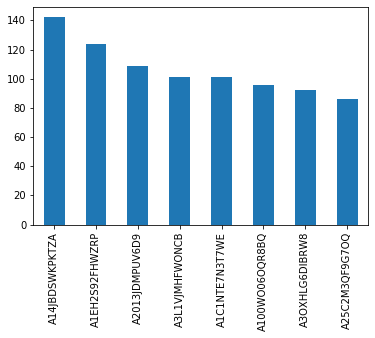

In [18]:
# Кол-во оценок каждого пользователя
mostActiveUsers = ratings['reviewerID'].value_counts().head(8)

print (mostActiveUsers) # вывести список
mostActiveUsers.plot(kind='bar') # вывести диаграмму 
mostActiveUsers.index # получить список userID для последующей фильтрации

In [19]:
mostActiveUsers = ratings['reviewerID'].value_counts().head(8)
print (mostActiveUsers)

A14JBDSWKPKTZA    142
A1EH2S92FHWZRP    124
A2013JDMPUV6D9    109
A3L1VJMHFWONCB    101
A1C1NTE7N3T7WE    101
A100WO06OQR8BQ     96
A3OXHLG6DIBRW8     92
A25C2M3QF9G7OQ     86
Name: reviewerID, dtype: int64


In [20]:
print(mostActiveUsers.index)
mask = ratings[ratings['reviewerID'].isin(mostActiveUsers.index)]
mostRatedProductsForUsers = mask['asin'].value_counts().head(6)
print (mostRatedProductsForUsers)

Index(['A14JBDSWKPKTZA', 'A1EH2S92FHWZRP', 'A2013JDMPUV6D9', 'A3L1VJMHFWONCB',
       'A1C1NTE7N3T7WE', 'A100WO06OQR8BQ', 'A3OXHLG6DIBRW8', 'A25C2M3QF9G7OQ'],
      dtype='object')
B000X27RT2    3
B0009CEKY6    3
B001538RUQ    3
B00D5Z8L5I    3
B009RJQH98    2
B002PIY7QS    2
Name: asin, dtype: int64


In [21]:
n_users = mostActiveUsers.shape[0]
n_items = mostRatedProductsForUsers.shape[0]
count1 = sum(mostRatedProductsForUsers)/(n_users * n_items)
print ("Пользователей с наибольшим количеством оценок", n_users)
print ("Товаров с наибольшим количеством оценок среди пользователей с наибольшим количеством оценок", n_items)
print ("Выставленных оценок", sum(mostRatedProductsForUsers))
# Расчет доли заполнения оценками
print("Размер матрицы {} x {}, Элементов {}, Заполнено на {:%}".format (
    n_users, 
    n_items,
    n_users * n_items,
    count1
))

Пользователей с наибольшим количеством оценок 8
Товаров с наибольшим количеством оценок среди пользователей с наибольшим количеством оценок 6
Выставленных оценок 16
Размер матрицы 8 x 6, Элементов 48, Заполнено на 33.333333%


In [22]:
mask2 = mask[mask['asin'].isin(mostRatedProductsForUsers.index)]
mask2

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
29668,A14JBDSWKPKTZA,B0009CEKY6,"Bob Feeser ""MillCrafters.com""","[0, 0]",I have a water filter on my refrigerator doors...,4,"A 4 for functionality, but the physics of it r...",1283990400,"09 9, 2010"
29674,A25C2M3QF9G7OQ,B0009CEKY6,Comdet,"[0, 0]",I have both the vertical model (this one) and ...,4,"Handy device, easy to install",1283040000,"08 29, 2010"
29683,A100WO06OQR8BQ,B0009CEKY6,"Duffer. ""Bo""","[0, 2]","In the box is the quite attractive unit, a fil...",1,Almost,1282694400,"08 25, 2010"
60506,A14JBDSWKPKTZA,B000X27RT2,"Bob Feeser ""MillCrafters.com""","[1, 2]",This is a very large bit set for the weekend w...,2,Bargain Basement Bit Set,1271894400,"04 22, 2010"
60509,A25C2M3QF9G7OQ,B000X27RT2,Comdet,"[1, 2]",This is a so-so set of drills. On the plus sid...,2,"Good assortment, but low end quality",1271894400,"04 22, 2010"
60511,A100WO06OQR8BQ,B000X27RT2,"Duffer. ""Bo""","[0, 1]",For slightly over 20 bucks you get most bits a...,5,You Get What You Pay For,1272067200,"04 24, 2010"
64847,A14JBDSWKPKTZA,B001538RUQ,"Bob Feeser ""MillCrafters.com""","[0, 1]",I had a shop with 11 employees for 20 years. T...,5,Truly a nice set,1267056000,"02 25, 2010"
64850,A25C2M3QF9G7OQ,B001538RUQ,Comdet,"[0, 1]",This is a decent set of tools. Appears sturdy ...,4,Decent homeowner-grade tools,1266883200,"02 23, 2010"
64860,A1EH2S92FHWZRP,B001538RUQ,Just a guy,"[0, 3]",Billy-Bob called. He wants his tools back.You...,4,"If you have a hyphenated first name, these are...",1267056000,"02 25, 2010"
85154,A25C2M3QF9G7OQ,B002PIY7QS,Comdet,"[2, 2]",I&#8217;ve been using these types of mix and s...,4,Easy to use; effective but not for the claimed...,1398729600,"04 29, 2014"


In [23]:
userUniqArr = mostActiveUsers.index
userUniqList = userUniqArr.tolist()
userUniqList.sort()
print (userUniqList)
print ("")
itemUniqArr = mostRatedProductsForUsers.index
itemUniqList = itemUniqArr.tolist()
itemUniqList.sort()
print (itemUniqList)

['A100WO06OQR8BQ', 'A14JBDSWKPKTZA', 'A1C1NTE7N3T7WE', 'A1EH2S92FHWZRP', 'A2013JDMPUV6D9', 'A25C2M3QF9G7OQ', 'A3L1VJMHFWONCB', 'A3OXHLG6DIBRW8']

['B0009CEKY6', 'B000X27RT2', 'B001538RUQ', 'B002PIY7QS', 'B009RJQH98', 'B00D5Z8L5I']


In [24]:
data_matrix = np.zeros((n_users, n_items))
for line in mask2.itertuples():
    indexLine = line[0]
    userID = line[1]
    itemID = line[2]
    overall = line[6]
    
    # получить индекс ИД_пользователя/товара в списке уникальных ИД
    indexForUser = userUniqList.index(userID)
    indexForItem = itemUniqList.index(itemID)
    
    # Индикация работы. вывод каждого N элемента обработки
    if indexLine % 5 == 0:
        print("Оценка №{}) {} -> {} = {}".format( indexLine, userID, itemID,  overall))
        
    # Внести оценку
    data_matrix[indexForUser, indexForItem] = overall

Оценка №64850) A25C2M3QF9G7OQ -> B001538RUQ = 4
Оценка №64860) A1EH2S92FHWZRP -> B001538RUQ = 4


In [25]:
# Расчет доли заполнения оценками
count2 = len (mask2)/(len (data_matrix) * len (data_matrix[0]))
print("Размер матрицы {} x {}, Элементов {}, Будет заполнено {:%}".format (
    len (data_matrix), 
    len (data_matrix[0]),
    len (data_matrix) * len (data_matrix[0]),
    count2
))

Размер матрицы 8 x 6, Элементов 48, Будет заполнено 33.333333%


In [26]:
print('{:%} == {:%}'.format(count1, count2))

33.333333% == 33.333333%


In [27]:
# Просмотр размера и содержимого матрицы
print (data_matrix.shape)
data_matrix

(8, 6)


array([[1., 5., 0., 5., 0., 0.],
       [4., 2., 5., 0., 5., 5.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 4., 0., 0., 4.],
       [0., 0., 0., 0., 0., 0.],
       [4., 2., 4., 4., 0., 2.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0.]])

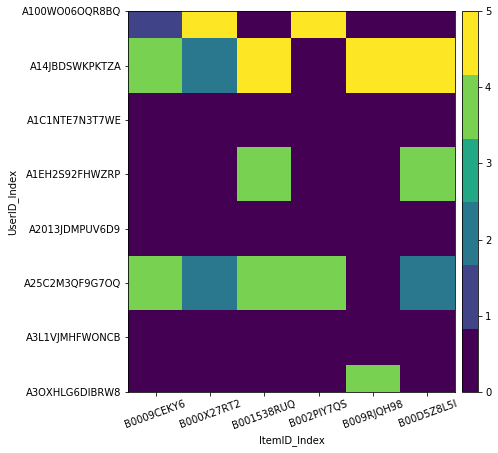

In [28]:
# Вывести матрицу R в графическом виде
# ! Изменить Абсциссы - Х - Пользователи - Субъекты
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

maxRate = 5 # Максимальное значение оценки в шкале

# создать свою цветовую карту, с разделением на 6 участков по количеству оценок
myColorMap = cm.get_cmap('magma', maxRate+1)
myColorMap = cm.get_cmap('viridis', maxRate+1)

# создать полотно размером HхW
fig, ax = plt.subplots(figsize=(7,7))

# отрисовать матрицу применив цветовую карту
im = ax.imshow(data_matrix, myColorMap, vmax=maxRate)

# добавить названия осей
plt.xlabel('ItemID_Index')
plt.ylabel('UserID_Index')


# добавить подписи осей
plt.xticks( ticks=np.arange(0, len(itemUniqList)),
            labels=itemUniqList,
            rotation=20)

plt.yticks( ticks=np.arange(0, len(userUniqList)),
            labels=userUniqList,
            rotation=0)

# Цветовая шкала
# магия для корретного размера цветовой шкалы
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# отобразить цветовую шкалу 
plt.colorbar(im, cax=cax)

In [29]:
userMain=0

# Функции схожести

## Евклидово расстояние:

In [30]:
# Евклидово расстояние
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import sqrt
def sim_distance_Euclide(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Евклидово расстояние----------")
    si = dict() # создать словарь (dict)
    
    sum_of_squares=0 # квадраты разностей
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-товары
    for i in range(0,countItem): 
        
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            
            counterBoth +=1  # количество совпадений 
            
            #сложить квадраты разностей оценок пользователей
            currSquares = ( ratesMatrix[person1_ID][i] - ratesMatrix[person2_ID][i])**2
            sum_of_squares+= currSquares
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; squares= {} ".format(
                    i, itemUniqList[i],
                    person1_ID, userUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, userUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    currSquares
                ))
                
    # вывод итоговых результатов
    if verbose==True:
        print ("SUMSquares = {}; SQRT = {:.2f}; 1/(1+SQRT) = {:.2f}".format(
                sum_of_squares, sqrt(sum_of_squares), 1/(1+sqrt(sum_of_squares))
        ))

    if counterBoth==0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    else:
        #При наличии общих оценок вернуть расчет
        return 1/(1+sqrt(sum_of_squares))
sim_distance_Euclide (data_matrix,0,1, verbose=True)


----------------Евклидово расстояние----------
Item (0)B0009CEKY6          . Rates: (0)A100WO06OQR8BQ =1.0; (1)A14JBDSWKPKTZA =4.0; squares= 9.0 
Item (1)B000X27RT2          . Rates: (0)A100WO06OQR8BQ =5.0; (1)A14JBDSWKPKTZA =2.0; squares= 9.0 
SUMSquares = 18.0; SQRT = 4.24; 1/(1+SQRT) = 0.19


0.1907435698305462

In [31]:
def topMatches_Euclide(ratesMatrix, userID, simFunc=sim_distance_Euclide,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(userUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, userUniqList[userID],
                    otherID, userUniqList[otherID],
                    simVal, len(simValList)) )

    simValList.sort()
    simValList.reverse()
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, userUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Euclide(data_matrix, userID=userMain, simFunc=sim_distance_Euclide, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, userUniqList[userID])


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.19
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.19
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.1907435698305462, 1) A14JBDSWKPKTZA
(0.18660549686337075, 5) A25C2M3QF9G7OQ
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE
[(0.1907435698305462, 1), (0.18660549686337075, 5), (0, 7), (0, 6), (0, 4)]

Рейтинг похожих
(0.1907435698305462, 1) A14JBDSWKPKTZA
(0.18660549686337075, 5) A25C2M3QF9G7OQ
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9


In [32]:
def get_rating_Euclide(ratesMatrix, userID, simFunc=sim_distance_Euclide, verbose=False):
    
    # получить список похожих пользователей
    simUserList = topMatches_Euclide(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", userUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0,countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID]>0 or ratesMatrix[otherID][itemID]==0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, userUniqList[otherID], 
                    itemID, itemUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, itemUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, itemUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Euclide(data_matrix, userID=userMain, simFunc=sim_distance_Euclide, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.19
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.19
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.1907435698305462, 1) A14JBDSWKPKTZA
(0.18660549686337075, 5) A25C2M3QF9G7OQ
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE

---------------Расчет оценки----------
Исходный пользователь:  A100WO06OQR8BQ
Польз. (1)   A14JBDSWKPKTZA; Товар (2)          B001538RUQ;  Схожесть 0.19; Оценка 5.00; Расчетн оц 0.95
Польз. (1)   A14JBDSWKPKTZA; Товар (4)          B009RJQH98;  Схожесть 0.19; Оценка 5.00; Расчетн оц 0

## Манхэттенское расстояние:

In [33]:
# Манхэттенское расстояние
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import fabs
def sim_distance_Manhattan(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Манхэттенское расстояние----------")
    si = dict() # создать словарь (dict)
    
    sum_of_fabs = 0 # сумма модулей
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-товары
    for i in range(0, countItem):
        
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            
            counterBoth += 1 # количество совпадений
            
            #сложить модули разностей оценок пользователей
            curr = (ratesMatrix[person1_ID][i] - ratesMatrix[person2_ID][i])
            sum_of_fabs += fabs(curr)
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; fabs= {} ".format(
                    i, itemUniqList[i],
                    person1_ID, userUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, userUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    curr
                ))
                
    # вывод итоговых результатов
    if verbose==True:
        print ("FABS = {:.2f}; 1/(1+FABS) = {:.2f}".format(
                sum_of_fabs, 1/(1+sum_of_fabs)
        ))

    if counterBoth == 0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    else:
        #При наличии общих оценок вернуть расчет
        return 1/(1+sum_of_fabs)
sim_distance_Manhattan(data_matrix,0,1, verbose=True)


----------------Манхэттенское расстояние----------
Item (0)B0009CEKY6          . Rates: (0)A100WO06OQR8BQ =1.0; (1)A14JBDSWKPKTZA =4.0; fabs= -3.0 
Item (1)B000X27RT2          . Rates: (0)A100WO06OQR8BQ =5.0; (1)A14JBDSWKPKTZA =2.0; fabs= 3.0 
FABS = 6.00; 1/(1+FABS) = 0.14


0.14285714285714285

In [34]:
def topMatches_Manhattan(ratesMatrix, userID, simFunc=sim_distance_Manhattan,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(userUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, userUniqList[userID],
                    otherID, userUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, userUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Manhattan(data_matrix, userID=userMain, simFunc=sim_distance_Manhattan, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, userUniqList[userID])


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.14
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.12
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.14285714285714285, 1) A14JBDSWKPKTZA
(0.125, 5) A25C2M3QF9G7OQ
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE
[(0.14285714285714285, 1), (0.125, 5), (0, 7), (0, 6), (0, 4)]

Рейтинг похожих
(0.14285714285714285, 1) A14JBDSWKPKTZA
(0.125, 5) A25C2M3QF9G7OQ
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9


In [35]:
def get_rating_Manhattan(ratesMatrix, userID, simFunc, verbose):
    
    # получить список похожих пользователей
    simUserList = topMatches_Manhattan(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", userUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, userUniqList[otherID], 
                    itemID, itemUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, itemUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, itemUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Manhattan(data_matrix, userID=userMain, simFunc=sim_distance_Manhattan, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.14
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.12
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.14285714285714285, 1) A14JBDSWKPKTZA
(0.125, 5) A25C2M3QF9G7OQ
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE

---------------Расчет оценки----------
Исходный пользователь:  A100WO06OQR8BQ
Польз. (1)   A14JBDSWKPKTZA; Товар (2)          B001538RUQ;  Схожесть 0.14; Оценка 5.00; Расчетн оц 0.71
Польз. (1)   A14JBDSWKPKTZA; Товар (4)          B009RJQH98;  Схожесть 0.14; Оценка 5.00; Расчетн оц 0.71
Польз. (1

## Коэффициент корреляции Пирсона:

In [36]:
# Коэффициент корреляции Пирсона
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import sqrt
def sim_distance_Pearson(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Коэффициент корреляции Пирсона----------")
    si = dict() # создать словарь (dict)
    
    sum_of_dividend = 0 # Сумма в делимом
    sum_of_divisor_1 = 0 # Сумма в делителе A
    sum_of_divisor_2 = 0 # Сумма в делителе B
    mid_val_1 = 0 # Среднее значение A
    mid_val_2 = 0 # Среднее значение B
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    for i in range(0, countItem):
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] != 0 and ratesMatrix[person2_ID][i] != 0:
            counterBoth += 1 # количество совпадений
            mid_val_1 += ratesMatrix[person1_ID][i];
            mid_val_2 += ratesMatrix[person2_ID][i];
    
    if counterBoth == 0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    mid_val_1 /= counterBoth
    mid_val_2 /= counterBoth
    print("mid_A= {}; mid_B= {}".format(mid_val_1, mid_val_2))
    
    # перебрать все столбцы предметы-товары
    for i in range(0, countItem):
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            #суммы в числителе и знаменателе
            mult = (ratesMatrix[person1_ID][i] - mid_val_1) * (ratesMatrix[person2_ID][i] - mid_val_2)
            sum_of_dividend += mult
            curr1 = (ratesMatrix[person1_ID][i] - mid_val_1)**2
            sum_of_divisor_1 += curr1
            curr2 = (ratesMatrix[person2_ID][i] - mid_val_2)**2
            sum_of_divisor_2 += curr2
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; dividend= {}; divisor_1= {}; divisor_2= {}".format(
                    i, itemUniqList[i],
                    person1_ID, userUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, userUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    mult, curr1, curr2
                ))
                
    divisor = sqrt(sum_of_divisor_1 * sum_of_divisor_2);
    if divisor == 0:
        return 0
    #print(sum_of_dividend)
    #print(divisor)
    res = sum_of_dividend / divisor
    # вывод итоговых результатов
    if verbose==True:
        print ("RES = {:.2f}".format(res))

    #При наличии общих оценок вернуть расчет
    return (res)
sim_distance_Pearson(data_matrix,1,0, verbose=True)


----------------Коэффициент корреляции Пирсона----------
mid_A= 3.0; mid_B= 3.0
Item (0)B0009CEKY6          . Rates: (1)A14JBDSWKPKTZA =4.0; (0)A100WO06OQR8BQ =1.0; dividend= -2.0; divisor_1= 1.0; divisor_2= 4.0
Item (1)B000X27RT2          . Rates: (1)A14JBDSWKPKTZA =2.0; (0)A100WO06OQR8BQ =5.0; dividend= -2.0; divisor_1= 1.0; divisor_2= 4.0
RES = -1.00


-1.0

In [37]:
def topMatches_Pearson(ratesMatrix, userID, simFunc=sim_distance_Pearson,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(userUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            #if (simVal )
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, userUniqList[userID],
                    otherID, userUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, key = lambda num: fabs(num[0]), reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, userUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Pearson(data_matrix, userID=userMain, simFunc=sim_distance_Pearson, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, userUniqList[userID])


---------------Список схожих----------
mid_A= 3.0; mid_B= 3.0
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть -1.00
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
mid_A= 3.6666666666666665; mid_B= 3.3333333333333335
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть -0.50
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(-1.0, 1) A14JBDSWKPKTZA
(-0.49999999999999994, 5) A25C2M3QF9G7OQ
(0, 2) A1C1NTE7N3T7WE
(0, 3) A1EH2S92FHWZRP
(0, 4) A2013JDMPUV6D9
(0, 6) A3L1VJMHFWONCB
(0, 7) A3OXHLG6DIBRW8
[(-1.0, 1), (-0.49999999999999994, 5), (0, 2), (0, 3), (0, 4)]

Рейтинг похожих
(-1.0, 1) A14JBDSWKPKTZA
(-0.49999999999999994, 5) A25C2M3QF9G7OQ
(0, 2) A1C1NTE7N3T7WE
(0, 3) A1EH2S92FHWZRP
(0, 4) A2013JDMPUV6D9


In [38]:
def get_rating_Pearson(ratesMatrix, userID, simFunc=sim_distance_Pearson, verbose=False):
    
    # получить список похожих пользователей
    simUserList = topMatches_Pearson(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", userUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    print(simUserList)
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]
        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            if simVal == 0:
                continue
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, userUniqList[otherID], 
                    itemID, itemUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в списке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, itemUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, itemUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Pearson(data_matrix, userID=userMain, simFunc=sim_distance_Pearson, verbose=True )
print (result)


---------------Список схожих----------
mid_A= 3.0; mid_B= 3.0
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть -1.00
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
mid_A= 3.6666666666666665; mid_B= 3.3333333333333335
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть -0.50
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(-1.0, 1) A14JBDSWKPKTZA
(-0.49999999999999994, 5) A25C2M3QF9G7OQ
(0, 2) A1C1NTE7N3T7WE
(0, 3) A1EH2S92FHWZRP
(0, 4) A2013JDMPUV6D9
(0, 6) A3L1VJMHFWONCB
(0, 7) A3OXHLG6DIBRW8

---------------Расчет оценки----------
Исходный пользователь:  A100WO06OQR8BQ
[(-1.0, 1), (-0.49999999999999994, 5), (0, 2), (0, 3), (0, 4)]
Польз. (1)   A14JBDSWKPKTZA; Товар (2)          B001538RUQ;  Схожесть -1.00; О

## Мера Жаккара:

In [39]:
# Мера Жаккара
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import fabs
def sim_distance_Jaccard(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Мера Жаккара----------")
    si = dict() # создать словарь (dict)
    
    sum_of_dividend = 0 # Сумма в делимом
    sum_of_divisor = 0 # Сумма в делителе
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-товары
    for i in range(0, countItem):
        
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            counterBoth += 1 # количество совпадений
            #сумма минимальных и максимальных значений среди пар
            dividend = min(ratesMatrix[person1_ID][i], ratesMatrix[person2_ID][i])
            sum_of_dividend += dividend
            divisor = max(ratesMatrix[person1_ID][i], ratesMatrix[person2_ID][i])
            sum_of_divisor += divisor
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; min= {}; max= {} ".format(
                    i, itemUniqList[i],
                    person1_ID, userUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, userUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    dividend, divisor
                ))
        
    if sum_of_divisor == 0:
        return 0
    res = sum_of_dividend / sum_of_divisor
    # вывод итоговых результатов
    if verbose==True:
        print ("RES = {:.2f}".format(res))

    if counterBoth == 0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    else:
        #При наличии общих оценок вернуть расчет
        return res
sim_distance_Jaccard(data_matrix,0,1, verbose=True)


----------------Мера Жаккара----------
Item (0)B0009CEKY6          . Rates: (0)A100WO06OQR8BQ =1.0; (1)A14JBDSWKPKTZA =4.0; min= 1.0; max= 4.0 
Item (1)B000X27RT2          . Rates: (0)A100WO06OQR8BQ =5.0; (1)A14JBDSWKPKTZA =2.0; min= 2.0; max= 5.0 
RES = 0.33


0.3333333333333333

In [40]:
def topMatches_Jaccard(ratesMatrix, userID, simFunc=sim_distance_Jaccard,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(userUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, userUniqList[userID],
                    otherID, userUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, userUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Jaccard(data_matrix, userID=userMain, simFunc=sim_distance_Jaccard, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, userUniqList[userID])


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.33
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.50
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.5, 5) A25C2M3QF9G7OQ
(0.3333333333333333, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE
[(0.5, 5), (0.3333333333333333, 1), (0, 7), (0, 6), (0, 4)]

Рейтинг похожих
(0.5, 5) A25C2M3QF9G7OQ
(0.3333333333333333, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9


In [41]:
def get_rating_Jaccard(ratesMatrix, userID, simFunc, verbose):
    
    # получить список похожих пользователей
    simUserList = topMatches_Jaccard(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", userUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, userUniqList[otherID], 
                    itemID, itemUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, itemUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, itemUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Jaccard(data_matrix, userID=userMain, simFunc=sim_distance_Jaccard, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.33
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.50
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.5, 5) A25C2M3QF9G7OQ
(0.3333333333333333, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE

---------------Расчет оценки----------
Исходный пользователь:  A100WO06OQR8BQ
Польз. (5)   A25C2M3QF9G7OQ; Товар (2)          B001538RUQ;  Схожесть 0.50; Оценка 4.00; Расчетн оц 2.00
Польз. (5)   A25C2M3QF9G7OQ; Товар (5)          B00D5Z8L5I;  Схожесть 0.50; Оценка 2.00; Расчетн оц 1.00
Польз. (1)  

## Косинусная мера близости:

In [42]:
# Косинусная мера близости
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import sqrt
def sim_distance_Cos(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Косинусная мера близости----------")
    si = dict() # создать словарь (dict)
    
    sum_of_dividend = 0 # Сумма в делимом
    sum_of_divisor_1 = 0 # Сумма в делителе A
    sum_of_divisor_2 = 0 # Сумма в делителе B
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-товары
    for i in range(0, countItem):
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            counterBoth += 1 # количество совпадений
            #суммы в числителе и знаменателе
            mult = ratesMatrix[person1_ID][i] * ratesMatrix[person2_ID][i]
            sum_of_dividend += mult
            curr1 = ratesMatrix[person1_ID][i]**2
            sum_of_divisor_1 += curr1
            curr2 = ratesMatrix[person2_ID][i]**2
            sum_of_divisor_2 += curr2
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; dividend= {}; divisor_1= {}; divisor_2= {}".format(
                    i, itemUniqList[i],
                    person1_ID, userUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, userUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    mult, curr1, curr2
                ))
                
    if counterBoth <= 1:
        return 0
    divisor = sqrt(sum_of_divisor_1 * sum_of_divisor_2);
    if divisor == 0:
        return 0
    res = sum_of_dividend / divisor
    # вывод итоговых результатов
    if verbose==True:
        print ("RES = {:.2f}".format(res))

    #При наличии общих оценок вернуть расчет
    return (res)
sim_distance_Cos(data_matrix,1,0, verbose=True)


----------------Косинусная мера близости----------
Item (0)B0009CEKY6          . Rates: (1)A14JBDSWKPKTZA =4.0; (0)A100WO06OQR8BQ =1.0; dividend= 4.0; divisor_1= 16.0; divisor_2= 1.0
Item (1)B000X27RT2          . Rates: (1)A14JBDSWKPKTZA =2.0; (0)A100WO06OQR8BQ =5.0; dividend= 10.0; divisor_1= 4.0; divisor_2= 25.0
RES = 0.61


0.6139406135149205

In [43]:
def topMatches_Cos(ratesMatrix, userID, simFunc=sim_distance_Cos,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(userUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, userUniqList[userID],
                    otherID, userUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, userUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Cos(data_matrix, userID=userMain, simFunc=sim_distance_Cos, k=5, verbose=True  )
print (serMatches)

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, userUniqList[userID])


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.61
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.79
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.7934920476158722, 5) A25C2M3QF9G7OQ
(0.6139406135149205, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE
[(0.7934920476158722, 5), (0.6139406135149205, 1), (0, 7), (0, 6), (0, 4)]

Рейтинг похожих
(0.7934920476158722, 5) A25C2M3QF9G7OQ
(0.6139406135149205, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9


In [44]:
def get_rating_Cos(ratesMatrix, userID, simFunc, verbose):
    
    # получить список похожих пользователей
    simUserList = topMatches_Cos(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", userUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, userUniqList[otherID], 
                    itemID, itemUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, itemUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, itemUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Cos(data_matrix, userID=userMain, simFunc=sim_distance_Cos, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (0) A100WO06OQR8BQ  - (1) A14JBDSWKPKTZA  - Схожесть 0.61
 Польз.: (0) A100WO06OQR8BQ  - (2) A1C1NTE7N3T7WE  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (3) A1EH2S92FHWZRP  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (4) A2013JDMPUV6D9  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (5) A25C2M3QF9G7OQ  - Схожесть 0.79
 Польз.: (0) A100WO06OQR8BQ  - (6) A3L1VJMHFWONCB  - Схожесть 0.00
 Польз.: (0) A100WO06OQR8BQ  - (7) A3OXHLG6DIBRW8  - Схожесть 0.00

Рейтинг похожих
(0.7934920476158722, 5) A25C2M3QF9G7OQ
(0.6139406135149205, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 6) A3L1VJMHFWONCB
(0, 4) A2013JDMPUV6D9
(0, 3) A1EH2S92FHWZRP
(0, 2) A1C1NTE7N3T7WE

---------------Расчет оценки----------
Исходный пользователь:  A100WO06OQR8BQ
Польз. (5)   A25C2M3QF9G7OQ; Товар (2)          B001538RUQ;  Схожесть 0.79; Оценка 4.00; Расчетн оц 3.17
Польз. (5)   A25C2M3QF9G7OQ; Товар (5)          B00D5Z8L5I;  Схожесть 0.79; Оценка 2.00; Расчетн оц 1.

## 3. Проверка качества алгоритма коллаборативной фильтрации


### Выбор пользователей и оценок для использования в качестве проверочных

Для проверки выберем пользователя с индексом 5, у которого есть все оценки, и удалим три из них для проверки

In [45]:
data_matrix2 = data_matrix.copy()

In [46]:
data_matrix2

array([[1., 5., 0., 5., 0., 0.],
       [4., 2., 5., 0., 5., 5.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 4., 0., 0., 4.],
       [0., 0., 0., 0., 0., 0.],
       [4., 2., 4., 4., 0., 2.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0.]])

In [47]:
data_matrix2 [2] [0] = 3
data_matrix2 [2] [1] = 2
data_matrix2 [2] [2] = 3
data_matrix2 [2] [3] = 4
data_matrix2 [2] [4] = 1
data_matrix2 [2] [5] = 5

In [48]:
data_matrix2 [4] [0] = 4
data_matrix2 [4] [1] = 4
data_matrix2 [4] [2] = 5
data_matrix2 [4] [3] = 5
data_matrix2 [4] [4] = 2
data_matrix2 [4] [5] = 1

In [49]:
data_matrix2 [6] [0] = 5
data_matrix2 [6] [1] = 3
data_matrix2 [6] [2] = 0
data_matrix2 [6] [3] = 5
data_matrix2 [6] [4] = 3
data_matrix2 [6] [5] = 3

In [50]:
data_matrix2 [5] [2] = 0
data_matrix2 [5] [3] = 0
data_matrix2 [5] [4] = 0

In [51]:
data_matrix2

array([[1., 5., 0., 5., 0., 0.],
       [4., 2., 5., 0., 5., 5.],
       [3., 2., 3., 4., 1., 5.],
       [0., 0., 4., 0., 0., 4.],
       [4., 4., 5., 5., 2., 1.],
       [4., 2., 0., 0., 0., 2.],
       [5., 3., 0., 5., 3., 3.],
       [0., 0., 0., 0., 4., 0.]])

In [52]:
def calculate_error_Euclide():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in userUniqList:
        print(userName, userUniqList.index(userName))
        userID = userUniqList.index(userName)
        

        resultDict_Euclide = get_rating_Euclide(data_matrix2, userID=userID, simFunc=sim_distance_Euclide, verbose=False)
        print('Евклид')
        print(resultDict_Euclide)
        

        allResultDict.update(resultDict_Euclide)
        

        for row in resultDict_Euclide:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Euclide = calculate_error_Euclide()

A100WO06OQR8BQ 0

Рейтинг похожих
(0.2402530733520421, 4) A2013JDMPUV6D9
(0.21089672205953397, 2) A1C1NTE7N3T7WE
(0.1907435698305462, 5) A25C2M3QF9G7OQ
(0.1907435698305462, 1) A14JBDSWKPKTZA
(0.1827439976315568, 6) A3L1VJMHFWONCB
(0, 7) A3OXHLG6DIBRW8
(0, 3) A1EH2S92FHWZRP


Евклид
{0: {2: 4.342891721649175, 4: 2.6597784790731165, 5: 3.1300308711666434}}
A14JBDSWKPKTZA 1

Рейтинг похожих
(0.5, 7) A3OXHLG6DIBRW8
(0.4142135623730951, 3) A1EH2S92FHWZRP
(0.25, 5) A25C2M3QF9G7OQ
(0.2402530733520421, 6) A3L1VJMHFWONCB
(0.1907435698305462, 0) A100WO06OQR8BQ
(0.179128784747792, 2) A1C1NTE7N3T7WE
(0.1566130288262323, 4) A2013JDMPUV6D9


Евклид
{1: {3: 5.0}}
A1C1NTE7N3T7WE 2

Рейтинг похожих
(0.4142135623730951, 3) A1EH2S92FHWZRP
(0.25, 7) A3OXHLG6DIBRW8
(0.2402530733520421, 5) A25C2M3QF9G7OQ
(0.21089672205953397, 6) A3L1VJMHFWONCB
(0.21089672205953397, 0) A100WO06OQR8BQ
(0.179128784747792, 1) A14JBDSWKPKTZA
(0.16139047779640892, 4) A2013JDMPUV6D9


Евклид
{}
A1EH2S92FHWZRP 3

Рейтинг похожих
(0

In [53]:
def calculate_error_Manhattan():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in userUniqList:
        print(userName, userUniqList.index(userName))
        userID = userUniqList.index(userName)
        
        
        resultDict_Manhattan = get_rating_Manhattan(data_matrix2, userID=userID, simFunc=sim_distance_Manhattan, verbose=False)
        print('Манхэттен')
        print(resultDict_Manhattan)
        
        
        allResultDict.update(resultDict_Manhattan)
        
        for row in resultDict_Manhattan:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Manhattan = calculate_error_Manhattan()

A100WO06OQR8BQ 0

Рейтинг похожих
(0.2, 4) A2013JDMPUV6D9
(0.14285714285714285, 6) A3L1VJMHFWONCB
(0.14285714285714285, 5) A25C2M3QF9G7OQ
(0.14285714285714285, 2) A1C1NTE7N3T7WE
(0.14285714285714285, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 3) A1EH2S92FHWZRP


Манхэттен
{0: {2: 4.411764705882353, 4: 2.6818181818181817, 5: 3.0370370370370368}}
A14JBDSWKPKTZA 1

Рейтинг похожих
(0.5, 7) A3OXHLG6DIBRW8
(0.3333333333333333, 3) A1EH2S92FHWZRP
(0.25, 5) A25C2M3QF9G7OQ
(0.14285714285714285, 6) A3L1VJMHFWONCB
(0.14285714285714285, 0) A100WO06OQR8BQ
(0.125, 2) A1C1NTE7N3T7WE
(0.1, 4) A2013JDMPUV6D9


Манхэттен
{1: {3: 5.0}}
A1C1NTE7N3T7WE 2

Рейтинг похожих
(0.3333333333333333, 3) A1EH2S92FHWZRP
(0.25, 7) A3OXHLG6DIBRW8
(0.2, 5) A25C2M3QF9G7OQ
(0.14285714285714285, 0) A100WO06OQR8BQ
(0.125, 1) A14JBDSWKPKTZA
(0.1111111111111111, 6) A3L1VJMHFWONCB
(0.08333333333333333, 4) A2013JDMPUV6D9


Манхэттен
{}
A1EH2S92FHWZRP 3

Рейтинг похожих
(0.5, 6) A3L1VJMHFWONCB
(0.3333333333333333, 5) A25C2M3QF9

In [54]:
def calculate_error_Pearson():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in userUniqList:
        print(userName, userUniqList.index(userName))
        userID = userUniqList.index(userName)
        
        resultDict_Pearson = get_rating_Pearson(data_matrix2, userID=userID, simFunc=sim_distance_Pearson, verbose=False)
        print('Пирсон')
        print(resultDict_Pearson)
        
        
        allResultDict.update(resultDict_Pearson)
        
        for row in resultDict_Pearson:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Pearson = calculate_error_Pearson()

A100WO06OQR8BQ 0
mid_A= 3.0; mid_B= 3.0
mid_A= 3.6666666666666665; mid_B= 3.0
mid_A= 3.6666666666666665; mid_B= 4.333333333333333
mid_A= 3.0; mid_B= 3.0
mid_A= 3.6666666666666665; mid_B= 4.333333333333333

Рейтинг похожих
(-1.0, 1) A14JBDSWKPKTZA
(-1.0, 5) A25C2M3QF9G7OQ
(0.5, 4) A2013JDMPUV6D9
(-0.5, 6) A3L1VJMHFWONCB
(0.0, 2) A1C1NTE7N3T7WE
(0, 3) A1EH2S92FHWZRP
(0, 7) A3OXHLG6DIBRW8
[(-1.0, 1), (-1.0, 5), (0.5, 4), (-0.5, 6), (0.0, 2)]


Пирсон
{0: {2: 5.0, 4: 5.5, 5: 4.0}}
A14JBDSWKPKTZA 1
mid_A= 3.0; mid_B= 3.0
mid_A= 4.2; mid_B= 2.8
mid_A= 5.0; mid_B= 4.0
mid_A= 4.2; mid_B= 3.2
mid_A= 3.6666666666666665; mid_B= 2.6666666666666665
mid_A= 4.0; mid_B= 3.5
mid_A= 5.0; mid_B= 4.0

Рейтинг похожих
(-1.0, 0) A100WO06OQR8BQ
(-0.3734080224074693, 4) A2013JDMPUV6D9
(0.28439822949726057, 2) A1C1NTE7N3T7WE
(0.1889822365046136, 5) A25C2M3QF9G7OQ
(0, 3) A1EH2S92FHWZRP
(0.0, 6) A3L1VJMHFWONCB
(0, 7) A3OXHLG6DIBRW8
[(-1.0, 0), (-0.3734080224074693, 4), (0.28439822949726057, 2), (0.18898223650461

In [55]:
def calculate_error_Jaccard():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in userUniqList:
        print(userName, userUniqList.index(userName))
        userID = userUniqList.index(userName)
        
        

        resultDict_Jaccard = get_rating_Jaccard(data_matrix2, userID=userID, simFunc=sim_distance_Jaccard, verbose=False)
        print('Жаккар')
        print(resultDict_Jaccard)
        
        
        allResultDict.update(resultDict_Jaccard)

        
        for row in resultDict_Jaccard:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Jaccard = calculate_error_Jaccard()

A100WO06OQR8BQ 0

Рейтинг похожих
(0.7142857142857143, 4) A2013JDMPUV6D9
(0.6, 6) A3L1VJMHFWONCB
(0.5384615384615384, 2) A1C1NTE7N3T7WE
(0.3333333333333333, 5) A25C2M3QF9G7OQ
(0.3333333333333333, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 3) A1EH2S92FHWZRP


Жаккар
{0: {2: 4.321016166281756, 4: 2.4855898123324396, 5: 2.9927304448967718}}
A14JBDSWKPKTZA 1

Рейтинг похожих
(0.8, 7) A3OXHLG6DIBRW8
(0.8, 3) A1EH2S92FHWZRP
(0.7272727272727273, 5) A25C2M3QF9G7OQ
(0.6666666666666666, 6) A3L1VJMHFWONCB
(0.6666666666666666, 2) A1C1NTE7N3T7WE
(0.6086956521739131, 4) A2013JDMPUV6D9
(0.3333333333333333, 0) A100WO06OQR8BQ


Жаккар
{1: {3: 4.5}}
A1C1NTE7N3T7WE 2

Рейтинг похожих
(0.7777777777777778, 3) A1EH2S92FHWZRP
(0.6666666666666666, 1) A14JBDSWKPKTZA
(0.6363636363636364, 5) A25C2M3QF9G7OQ
(0.6190476190476191, 6) A3L1VJMHFWONCB
(0.56, 4) A2013JDMPUV6D9
(0.5384615384615384, 0) A100WO06OQR8BQ
(0.25, 7) A3OXHLG6DIBRW8


Жаккар
{}
A1EH2S92FHWZRP 3

Рейтинг похожих
(0.8, 1) A14JBDSWKPKTZA
(0.7777777

In [56]:
def calculate_error_Cos():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in userUniqList:
        print(userName, userUniqList.index(userName))
        userID = userUniqList.index(userName)
        
        
        resultDict_Cos = get_rating_Cos(data_matrix2, userID=userID, simFunc=sim_distance_Cos, verbose=False)
        print('Косинус')
        print(resultDict_Cos)
        
        allResultDict.update(resultDict_Cos)
        
        for row in resultDict_Cos:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Cos = calculate_error_Cos()

A100WO06OQR8BQ 0

Рейтинг похожих
(0.9088109773219402, 4) A2013JDMPUV6D9
(0.8580840963623672, 2) A1C1NTE7N3T7WE
(0.820354226434844, 6) A3L1VJMHFWONCB
(0.6139406135149205, 5) A25C2M3QF9G7OQ
(0.6139406135149205, 1) A14JBDSWKPKTZA
(0, 7) A3OXHLG6DIBRW8
(0, 3) A1EH2S92FHWZRP


Косинус
{0: {2: 4.279174030382749, 4: 2.5635691787399097, 5: 3.1343300964275915}}
A14JBDSWKPKTZA 1

Рейтинг похожих
(1.0, 3) A1EH2S92FHWZRP
(0.9281909617845142, 6) A3L1VJMHFWONCB
(0.9128709291752769, 5) A25C2M3QF9G7OQ
(0.9033320385826158, 2) A1C1NTE7N3T7WE
(0.8339160384912686, 4) A2013JDMPUV6D9
(0.6139406135149205, 0) A100WO06OQR8BQ
(0, 7) A3OXHLG6DIBRW8


Косинус
{1: {3: 4.661094466835185}}
A1C1NTE7N3T7WE 2

Рейтинг похожих
(0.9701425001453319, 3) A1EH2S92FHWZRP
(0.9066200187087723, 6) A3L1VJMHFWONCB
(0.9033320385826158, 1) A14JBDSWKPKTZA
(0.8609460320922785, 5) A25C2M3QF9G7OQ
(0.8580840963623672, 0) A100WO06OQR8BQ
(0.8308872144992909, 4) A2013JDMPUV6D9
(0, 7) A3OXHLG6DIBRW8


Косинус
{}
A1EH2S92FHWZRP 3

Рейтинг по

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


In [57]:
predictDict_Euclide

{0: {2: 4.342891721649175, 4: 2.6597784790731165, 5: 3.1300308711666434},
 1: {3: 5.0},
 3: {0: 4.045102958632653,
  1: 2.515509553691818,
  3: 4.641207853431882,
  4: 2.8468438158119738},
 5: {3: 4.73751309732221, 4: 2.751545296315698, 2: 4.2814435491933756},
 6: {2: 4.507168217833616},
 7: {0: 4.157894736842105,
  1: 2.736842105263158,
  3: 4.769230769230769,
  5: 3.526315789473684,
  2: 4.538461538461538}}

In [58]:
predictDict_Manhattan

{0: {2: 4.411764705882353, 4: 2.6818181818181817, 5: 3.0370370370370368},
 1: {3: 5.0},
 3: {0: 4.098039215686275,
  1: 2.5294117647058827,
  3: 4.67741935483871,
  4: 2.853658536585366},
 5: {2: 4.290322580645162, 3: 4.714285714285714, 4: 2.842105263157895},
 6: {2: 4.38235294117647},
 7: {0: 4.157894736842105,
  1: 2.736842105263158,
  3: 4.769230769230769,
  5: 3.526315789473684,
  2: 4.538461538461538}}

In [59]:
predictDict_Pearson

{0: {2: 5.0, 4: 5.5, 5: 4.0},
 1: {3: 5.261153050549941},
 5: {3: 5.607625218510765, 4: 3.1706192973456364, 2: 5.755928946018455},
 6: {2: 4.4288735000678}}

In [60]:
predictDict_Jaccard

{0: {2: 4.321016166281756, 4: 2.4855898123324396, 5: 2.9927304448967718},
 1: {3: 4.5},
 3: {0: 3.991789819376026,
  1: 2.5500821018062396,
  4: 2.822736030828516,
  3: 4.626666666666668},
 5: {3: 4.691629955947136, 4: 2.814332247557004, 2: 4.308510638297873},
 6: {2: 4.653846153846153},
 7: {0: 4.217391304347826,
  1: 2.7608695652173916,
  2: 4.67741935483871,
  5: 3.4782608695652177,
  3: 4.833333333333333}}

In [61]:
predictDict_Cos

{0: {2: 4.279174030382749, 4: 2.5635691787399097, 5: 3.1343300964275915},
 1: {3: 4.661094466835185},
 3: {0: 3.6537916655644453,
  1: 2.593856565455414,
  4: 2.7243818140746616,
  3: 4.461687726687675},
 5: {3: 4.746398155170399, 4: 2.778001174574729, 2: 4.361715337934203},
 6: {2: 4.3501000453657275},
 7: {0: nan, 1: nan, 3: nan, 5: nan, 2: nan}}

### Из-за некорректных начальных данных, пришлось добавить оценки множеству пользователей

#### Начальная матрица

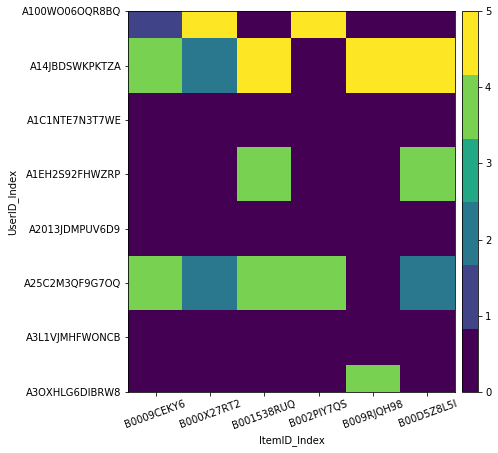

In [62]:
# Вывести матрицу R в графическом виде
# ! Изменить Абсциссы - Х - Пользователи - Субъекты
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

maxRate = 5 # Максимальное значение оценки в шкале

# создать свою цветовую карту, с разделением на 6 участков по количеству оценок
myColorMap = cm.get_cmap('magma', maxRate+1)
myColorMap = cm.get_cmap('viridis', maxRate+1)

# создать полотно размером HхW
fig, ax = plt.subplots(figsize=(7,7))

# отрисовать матрицу применив цветовую карту
im = ax.imshow(data_matrix, myColorMap, vmax=maxRate)

# добавить названия осей
plt.xlabel('ItemID_Index')
plt.ylabel('UserID_Index')


# добавить подписи осей
plt.xticks( ticks=np.arange(0, len(itemUniqList)),
            labels=itemUniqList,
            rotation=20)

plt.yticks( ticks=np.arange(0, len(userUniqList)),
            labels=userUniqList,
            rotation=0)

# Цветовая шкала
# магия для корретного размера цветовой шкалы
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# отобразить цветовую шкалу 
plt.colorbar(im, cax=cax)

#### Изменённая матрица

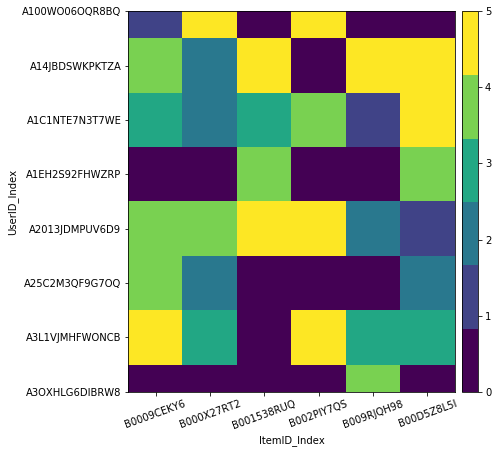

In [63]:
# Вывести матрицу R в графическом виде
# ! Изменить Абсциссы - Х - Пользователи - Субъекты
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

maxRate = 5 # Максимальное значение оценки в шкале

# создать свою цветовую карту, с разделением на 6 участков по количеству оценок
myColorMap = cm.get_cmap('magma', maxRate+1)
myColorMap = cm.get_cmap('viridis', maxRate+1)

# создать полотно размером HхW
fig, ax = plt.subplots(figsize=(7,7))

# отрисовать матрицу применив цветовую карту
im = ax.imshow(data_matrix2, myColorMap, vmax=maxRate)

# добавить названия осей
plt.xlabel('ItemID_Index')
plt.ylabel('UserID_Index')


# добавить подписи осей
plt.xticks( ticks=np.arange(0, len(itemUniqList)),
            labels=itemUniqList,
            rotation=20)

plt.yticks( ticks=np.arange(0, len(userUniqList)),
            labels=userUniqList,
            rotation=0)

# Цветовая шкала
# магия для корретного размера цветовой шкалы
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# отобразить цветовую шкалу 
plt.colorbar(im, cax=cax)

### Результаты тестирования 
После получения вычисленных оценок на исключенных элементах (отложенная часть), для удобства обработки результатов объединим значения (изъятые в отложенную выборку и расчитанные алгоритмами) в списки, сохраняя взаимный порядок элементов
```
RealRate    = [5,   2,   1]
EuclidRate  = [5.1, 1.9, 1.0]
2: 4.2814435491933756, 3: 4.579288613628467, 4: 2.6346473780072577
ManhattanRate  = [5.1, 1.9, 1.0]
2: 4.290322580645162, 3: 4.526315789473684, 4: 2.6935483870967745
PearsonRate  = [5.1, 1.9, 1.0]
2: 5.755928946018455, 3: 4.999999999999999, 4: 2.906915428311661
JaccardRate  = [5.1, 1.9, 1.0]
2: 4.308510638297873, 3: 4.511400651465799, 4: 2.425531914893617
CosRate      = [5.1, 1.9, 1.0]
2: 4.361715337934203, 3: 4.5197857453405765, 4: 2.048606166509042
```

In [64]:
x1_Real      = [4,   4,   5]
y1_Euclid    = [4.2814435491933756, 4.579288613628467, 2.6346473780072577]
y1_Pearson    = [5.755928946018455, 4.999999999999999, 2.906915428311661]
y1_Manhetton = [4.290322580645162, 4.526315789473684, 2.6935483870967745]
y1_Jaccard = [4.308510638297873, 4.511400651465799, 2.425531914893617]
y1_Cos = [4.361715337934203, 4.5197857453405765, 2.048606166509042]

print("x1_Real      = ", x1_Real)
print("y1_Euclid    = ",y1_Euclid)
print("y1_Pearson    = ",y1_Pearson)
print("y1_Manhetton = ", y1_Manhetton)
print("y1_Jaccard   = ", y1_Jaccard)
print("y1_Cos       = ", y1_Cos)

x1_Real      =  [4, 4, 5]
y1_Euclid    =  [4.2814435491933756, 4.579288613628467, 2.6346473780072577]
y1_Pearson    =  [5.755928946018455, 4.999999999999999, 2.906915428311661]
y1_Manhetton =  [4.290322580645162, 4.526315789473684, 2.6935483870967745]
y1_Jaccard   =  [4.308510638297873, 4.511400651465799, 2.425531914893617]
y1_Cos       =  [4.361715337934203, 4.5197857453405765, 2.048606166509042]


## Диаграмма рассеяние вычисленных значений

Построим диаграмму рассеяных значений

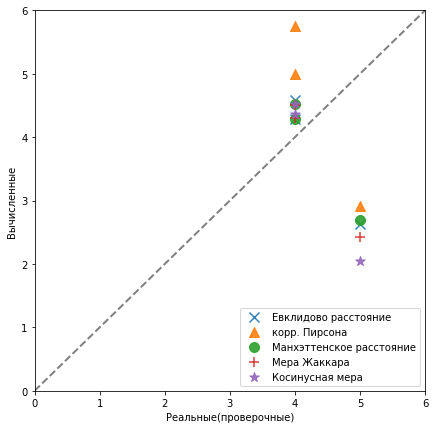

In [65]:
# Построить диаграмму рассеяния
# создать полотно размером HхW
fig, ax = plt.subplots(figsize=(7,7))

# Нанести точки (scatter)
ax.scatter(x1_Real, y1_Euclid, marker='x', s=100, alpha=0.9, label='Евклидово расстояние') # точечная диаграмма 
ax.scatter(x1_Real, y1_Pearson, marker='^', s=100, alpha=0.9, label='корр. Пирсона') # точечная диаграмма
ax.scatter(x1_Real, y1_Manhetton, marker='o', s=100, alpha=0.9, label='Манхэттенское расстояние') # точечная диаграмма 
ax.scatter(x1_Real, y1_Jaccard, marker='+', s=100, alpha=0.9, label='Мера Жаккара') # точечная диаграмма 
ax.scatter(x1_Real, y1_Cos, marker='*', s=100, alpha=0.9, label='Косинусная мера') # точечная диаграмма 

# Нанести график (plot)
ax.plot( [0,6], [0,6], lw=2,   color='gray',  linestyle='dashed',) # график проверочный

ax.legend(loc="lower right")  # отобразить легенду
ax.set_xlabel('Реальные(проверочные)') # посдпись оси X
ax.set_ylabel('Вычисленные')           # посдпись оси Y
ax.set_xlim([0,5+1]) # диапазон значений X
ax.set_ylim([0,5+1]) # диапазон значений Y
plt.show()

## Расчет RMSE

In [66]:
import math

def calculate_error(Predict, Actual):
    if len(Predict)!=len(Actual):
        raise BaseException("Кол-во элементов не совпадает")
    
    sumSquare=0
    # Получить сумму квадратов разностей
    for i in range (0, len(Predict)):
        sumSquare+= (Predict[i] - Actual[i])**2

    return math.sqrt(sumSquare)
    
# ----------------------------------

In [67]:
# Пример для получения значения  
print ("(Евклидово расстояние)     RMSE=", calculate_error(
                Predict=y1_Euclid, 
                Actual=x1_Real))
print ("(Манхэттенское расстояние)     RMSE=", calculate_error(
                Predict=y1_Manhetton, 
                Actual=x1_Real))
print ("(корр. Пирсона)     RMSE=", calculate_error(
                Predict=y1_Pearson, 
                Actual=x1_Real))
print ("(Мера Жаккара)     RMSE=", calculate_error(
                Predict=y1_Jaccard, 
                Actual=x1_Real))
print ("(Косинусная мера)     RMSE=", calculate_error(
                Predict=y1_Cos, 
                Actual=x1_Real))


(Евклидово расстояние)     RMSE= 2.4514646225532393
(Манхэттенское расстояние)     RMSE= 2.3834878967063506
(корр. Пирсона)     RMSE= 2.909345199130766
(Мера Жаккара)     RMSE= 2.642838504618459
(Косинусная мера)     RMSE= 3.018566011722216


# Выводы

* В ходе работы изучен теоретический материал по методам коллаборативной фильтрации, загружен и описан исходный массив данных согласно варианту
* Максимальная заполненность матрицы была равна 33% (при 8 субъектах и 6 объектах)
* В результате работы был разработан метод коллаборативной фильтрации (User-based) и 5 мер близости.
* Лучшей из них, исходя из расчёта среднеквадратичной ошибки, оказалась Манхэттенское расстояние (RMSE = 2.3834), худшей Косинусная мера (RMSE = 3.0185)

## 4. Реализация метода коллаборативной фильтрации (Item-based)

In [68]:
countUsers = 20
countItems = 20
maxCount = 0
maxItems = 0
maxUsers = 0
for i in range(6, countItems):
    for j in range(6, countUsers):
        mostRatedProducts = ratings['asin'].value_counts().head(i)
        mask = ratings[ratings['asin'].isin(mostRatedProducts.index)]
        mostActiveUsersForProducts = mask['reviewerID'].value_counts().head(j)
        
        n_items = mostRatedProducts.shape[0]
        n_users = mostActiveUsersForProducts.shape[0]
        count = sum(mostActiveUsersForProducts)/(n_items * n_users)
        if count <= 0.5:
            maxCount = max(count, maxCount)
        if count == maxCount:
            maxItems = i
            maxUsers = j
        
print("Максимальный процент заполнености матрицы - {:%}; для {} предметов и {} пользователей".format(maxCount, maxItems, maxUsers))

Максимальный процент заполнености матрицы - 50.000000%; для 6 предметов и 8 пользователей


In [69]:
mostRatedProducts = ratings['asin'].value_counts().head(6)
print (mostRatedProducts)

B006E0QAFY    504
B000IKK0OI    345
B000O8OTNC    311
B0011UIPIW    265
B002P6EQPW    265
B003P2UMP8    255
Name: asin, dtype: int64


In [70]:
print(mostRatedProducts.index)
mask = ratings[ratings['asin'].isin(mostRatedProducts.index)]
mostActiveUsersForProducts = mask['reviewerID'].value_counts().head(8)
print (mostActiveUsersForProducts)

Index(['B006E0QAFY', 'B000IKK0OI', 'B000O8OTNC', 'B0011UIPIW', 'B002P6EQPW',
       'B003P2UMP8'],
      dtype='object')
A2IXIL77D51CAZ    3
A283MG7CN8KJHF    3
A2PC6KJ50P32KE    3
A38RLGERQ7M1E7    3
A3QBYS6X6R03KL    3
A3I39OVXIAML6Y    3
A22TJPZOUI9DE1    3
A1KBD7BOJFFNJ     3
Name: reviewerID, dtype: int64


In [71]:
n_items = mostRatedProducts.shape[0]
n_users = mostActiveUsersForProducts.shape[0]
count1 = sum(mostActiveUsersForProducts)/(n_users * n_items)
print ("Товаров с наибольшим количеством оценок", n_items)
print ("Пользователей с наибольшим количеством оценок среди товаров с наибольшим количеством оценок", n_users)
print ("Выставленных оценок", sum(mostActiveUsersForProducts))
# Расчет доли заполнения оценками
print("Размер матрицы {} x {}, Элементов {}, Заполнено на {:%}".format ( 
    n_items,
    n_users,
    n_users * n_items,
    count1
))

Товаров с наибольшим количеством оценок 6
Пользователей с наибольшим количеством оценок среди товаров с наибольшим количеством оценок 8
Выставленных оценок 24
Размер матрицы 6 x 8, Элементов 48, Заполнено на 50.000000%


In [72]:
mask2 = mask[mask['reviewerID'].isin(mostActiveUsersForProducts.index)]
mask2

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
43895,A283MG7CN8KJHF,B000IKK0OI,greg,"[0, 0]",perhaps its because im in a mobile home and th...,2,its not finding any studs....,1367625600,"05 4, 2013"
43902,A22TJPZOUI9DE1,B000IKK0OI,hungryman,"[0, 1]",Just tried it on a wall where I plan to mount ...,1,COMPLETELY USELESS GARBAGE,1346976000,"09 7, 2012"
43967,A38RLGERQ7M1E7,B000IKK0OI,LivewithPassion,"[1, 1]",I purchased a laser stud finder before getting...,5,Simply genius,1361145600,"02 18, 2013"
52480,A2IXIL77D51CAZ,B000O8OTNC,D. Hager,"[1, 1]",Very handy to have around - doesn't provide th...,5,Very handy to have around,1354492800,"12 3, 2012"
52676,A3I39OVXIAML6Y,B000O8OTNC,sel366,"[0, 0]",Nice sharpener for the money. It sharpens the ...,5,Love it,1301702400,"04 2, 2011"
52712,A2PC6KJ50P32KE,B000O8OTNC,Va Trail Rider,"[1, 1]",Works pretty good. I keep it in my INCH bag. I...,5,Smith's PP1 Pocket Pal,1356825600,"12 30, 2012"
62439,A2IXIL77D51CAZ,B0011UIPIW,D. Hager,"[0, 0]",I carry this flashlight on a ball chain neckla...,5,Love this flashlight!,1354406400,"12 2, 2012"
62519,A1KBD7BOJFFNJ,B0011UIPIW,"MacBobT ""catso""","[0, 0]",I received this in a timely manner. This tiny ...,5,Powerful LED Light,1345420800,"08 20, 2012"
62530,A3QBYS6X6R03KL,B0011UIPIW,mike892,"[4, 5]",The good part is the bright light - it is very...,3,"bright light, but comes apart in pocket",1299542400,"03 8, 2011"
84941,A283MG7CN8KJHF,B002P6EQPW,greg,"[0, 0]",i made a little house to surround the beam.im ...,5,i will be buying more.,1366070400,"04 16, 2013"


In [73]:
itemUniqArr = mostRatedProducts.index
itemUniqList = itemUniqArr.tolist()
itemUniqList.sort()
print (itemUniqList)
print ("")
userUniqArr = mostActiveUsersForProducts.index
userUniqList = userUniqArr.tolist()
userUniqList.sort()
print (userUniqList)

['B000IKK0OI', 'B000O8OTNC', 'B0011UIPIW', 'B002P6EQPW', 'B003P2UMP8', 'B006E0QAFY']

['A1KBD7BOJFFNJ', 'A22TJPZOUI9DE1', 'A283MG7CN8KJHF', 'A2IXIL77D51CAZ', 'A2PC6KJ50P32KE', 'A38RLGERQ7M1E7', 'A3I39OVXIAML6Y', 'A3QBYS6X6R03KL']


In [74]:
data_matrix = np.zeros((n_items, n_users))
for line in mask2.itertuples():
    indexLine = line[0]
    userID = line[1]
    itemID = line[2]
    overall = line[6]
    
    # получить индекс ИД_пользователя/товара в списке уникальных ИД
    indexForUser = userUniqList.index(userID)
    indexForItem = itemUniqList.index(itemID)
        
    # Внести оценку
    data_matrix[indexForItem, indexForUser] = overall

In [75]:
# Просмотр размера и содержимого матрицы
print (data_matrix.shape)
data_matrix

(6, 8)


array([[0., 1., 2., 0., 0., 5., 0., 0.],
       [0., 0., 0., 5., 5., 0., 5., 0.],
       [5., 0., 0., 5., 0., 0., 0., 3.],
       [2., 5., 5., 0., 5., 5., 5., 0.],
       [0., 0., 0., 0., 0., 4., 0., 3.],
       [4., 5., 4., 4., 5., 0., 5., 5.]])

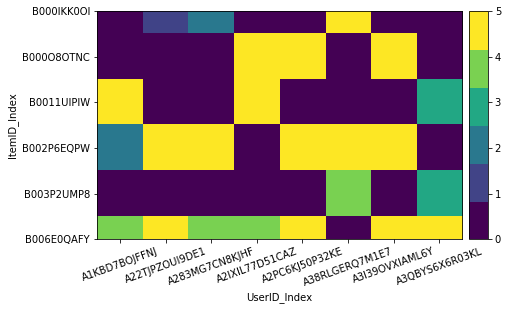

In [76]:
    # Вывести матрицу R в графическом виде
# ! Изменить Абсциссы - Х - Пользователи - Субъекты
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

maxRate = 5 # Максимальное значение оценки в шкале

# создать свою цветовую карту, с разделением на 6 участков по количеству оценок
myColorMap = cm.get_cmap('magma', maxRate+1)
myColorMap = cm.get_cmap('viridis', maxRate+1)

# создать полотно размером HхW
fig, ax = plt.subplots(figsize=(7,7))

# отрисовать матрицу применив цветовую карту
im = ax.imshow(data_matrix, myColorMap, vmax=maxRate)

# добавить названия осей
plt.xlabel('UserID_Index')
plt.ylabel('ItemID_Index')


# добавить подписи осей
plt.xticks( ticks=np.arange(0, len(userUniqList)),
            labels=userUniqList,
            rotation=20)

plt.yticks( ticks=np.arange(0, len(itemUniqList)),
            labels=itemUniqList,
            rotation=0)

# Цветовая шкала
# магия для корретного размера цветовой шкалы
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# отобразить цветовую шкалу 
plt.colorbar(im, cax=cax)

In [77]:
itemMain=3

# Функция схожести

## Евклидово расстояние:

In [125]:
# Евклидово расстояние
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import sqrt
def sim_distance_Euclide(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Евклидово расстояние----------")
    si = dict() # создать словарь (dict)
    
    sum_of_squares=0 # квадраты разностей
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-товары
    for i in range(0,countItem): 
        
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            
            counterBoth +=1  # количество совпадений 
            
            #сложить квадраты разностей оценок пользователей
            currSquares = ( ratesMatrix[person1_ID][i] - ratesMatrix[person2_ID][i])**2
            sum_of_squares+= currSquares
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; squares= {} ".format(
                    i, userUniqList[i],
                    person1_ID, itemUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, itemUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    currSquares
                ))
                
    # вывод итоговых результатов
    if verbose==True:
        print ("SUMSquares = {}; SQRT = {:.2f}; 1/(1+SQRT) = {:.2f}".format(
                sum_of_squares, sqrt(sum_of_squares), 1/(1+sqrt(sum_of_squares))
        ))

    if counterBoth==0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    else:
        #При наличии общих оценок вернуть расчет
        return 1/(1+sqrt(sum_of_squares))
sim_distance_Euclide(data_matrix,0,1, verbose=True)


----------------Евклидово расстояние----------
SUMSquares = 0; SQRT = 0.00; 1/(1+SQRT) = 1.00


0

In [126]:
def topMatches_Euclide(ratesMatrix, userID, simFunc=sim_distance_Euclide,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(itemUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, itemUniqList[userID],
                    otherID, itemUniqList[otherID],
                    simVal, len(simValList)) )

    simValList.sort()
    simValList.reverse()
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, itemUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Euclide(data_matrix, userID=itemMain, simFunc=sim_distance_Euclide, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, itemUniqList[userID])


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.17
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.25
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.50
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.31

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.3090169943749474, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.16666666666666666, 0) B000IKK0OI
[(1.0, 1), (0.5, 4), (0.3090169943749474, 5), (0.25, 2), (0.16666666666666666, 0)]

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.3090169943749474, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.16666666666666666, 0) B000IKK0OI


In [127]:
def get_rating_Euclide(ratesMatrix, userID, simFunc=sim_distance_Euclide, verbose=False):
    
    # получить список похожих пользователей
    simUserList = topMatches_Euclide(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", userUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ФИЛЬМА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ФИЛЬМА Словарь. для расчитаных оценок у предметы-фильмы без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-фильмы
        for itemID in range(0,countItem):
            
            # Пропустить предметы-фильмы, которые оценил исходный пользователь
            # Пропустить предметы-фильмы, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID]>0 or ratesMatrix[otherID][itemID]==0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-фильму
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, itemUniqList[otherID], 
                    itemID, userUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, userUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, userUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Euclide(data_matrix, userID=itemMain, simFunc=sim_distance_Euclide, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.17
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.25
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.50
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.31

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.3090169943749474, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.16666666666666666, 0) B000IKK0OI

---------------Расчет оценки----------
Исходный пользователь:  A2IXIL77D51CAZ
Польз. (1)       B000O8OTNC; Товар (3)      A2IXIL77D51CAZ;  Схожесть 1.00; Оценка 5.00; Расчетн оц 5.00
Польз. (4)       B003P2UMP8; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.50; Оценка 3.00; Расчетн оц 1.50
Польз. (5)       B006E0QAFY; Товар (3)      A2IXIL77D51CAZ;  Схожесть 0.31; Оценка 4.00; Расчетн оц 1.24
Польз. (5)       B006E0QAFY; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.31; Оценка

## Манхэттенское расстояние:

In [128]:
# Манхэттенское расстояние
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import fabs
def sim_distance_Manhattan(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Манхэттенское расстояние----------")
    si = dict() # создать словарь (dict)
    
    sum_of_fabs = 0 # сумма модулей
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-фильмы
    for i in range(0, countItem):
        
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            
            counterBoth += 1 # количество совпадений
            
            #сложить модули разностей оценок пользователей
            curr = (ratesMatrix[person1_ID][i] - ratesMatrix[person2_ID][i])
            sum_of_fabs += fabs(curr)
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; fabs= {} ".format(
                    i, userUniqList[i],
                    person1_ID, itemUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, itemUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    curr
                ))
                
    # вывод итоговых результатов
    if verbose==True:
        print ("FABS = {:.2f}; 1/(1+FABS) = {:.2f}".format(
                sum_of_fabs, 1/(1+sum_of_fabs)
        ))

    if counterBoth == 0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    else:
        #При наличии общих оценок вернуть расчет
        return 1/(1+sum_of_fabs)
sim_distance_Manhattan(data_matrix,0,1, verbose=True)


----------------Манхэттенское расстояние----------
FABS = 0.00; 1/(1+FABS) = 1.00


0

In [129]:
def topMatches_Manhattan(ratesMatrix, userID, simFunc=sim_distance_Manhattan,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(itemUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, itemUniqList[userID],
                    otherID, itemUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, itemUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Manhattan(data_matrix, userID=itemMain, simFunc=sim_distance_Manhattan, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, itemUniqList[userID])


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.12
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.25
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.50
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.25

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.25, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.125, 0) B000IKK0OI
[(1.0, 1), (0.5, 4), (0.25, 5), (0.25, 2), (0.125, 0)]

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.25, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.125, 0) B000IKK0OI


In [130]:
def get_rating_Manhattan(ratesMatrix, userID, simFunc, verbose):
    
    # получить список похожих пользователей
    simUserList = topMatches_Manhattan(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", itemUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, itemUniqList[otherID], 
                    itemID, userUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, userUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, userUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Manhattan(data_matrix, userID=itemMain, simFunc=sim_distance_Manhattan, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.12
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.25
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.50
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.25

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.25, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.125, 0) B000IKK0OI

---------------Расчет оценки----------
Исходный пользователь:  B002P6EQPW
Польз. (1)       B000O8OTNC; Товар (3)      A2IXIL77D51CAZ;  Схожесть 1.00; Оценка 5.00; Расчетн оц 5.00
Польз. (4)       B003P2UMP8; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.50; Оценка 3.00; Расчетн оц 1.50
Польз. (5)       B006E0QAFY; Товар (3)      A2IXIL77D51CAZ;  Схожесть 0.25; Оценка 4.00; Расчетн оц 1.00
Польз. (5)       B006E0QAFY; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.25; Оценка 5.00; Расчетн оц 1.25
Польз. (2

## Коэффициент корреляции Пирсона:

In [131]:
# Коэффициент корреляции Пирсона
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import sqrt
def sim_distance_Pearson(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Коэффициент корреляции Пирсона----------")
    si = dict() # создать словарь (dict)
    
    sum_of_dividend = 0 # Сумма в делимом
    sum_of_divisor_1 = 0 # Сумма в делителе A
    sum_of_divisor_2 = 0 # Сумма в делителе B
    mid_val_1 = 0 # Среднее значение A
    mid_val_2 = 0 # Среднее значение B
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    for i in range(0, countItem):
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] != 0 and ratesMatrix[person2_ID][i] != 0:
            counterBoth += 1 # количество совпадений
            mid_val_1 += ratesMatrix[person1_ID][i];
            mid_val_2 += ratesMatrix[person2_ID][i];
    
    if counterBoth == 0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    mid_val_1 /= counterBoth
    mid_val_2 /= counterBoth
    print("mid_A= {}; mid_B= {}".format(mid_val_1, mid_val_2))
    
    # перебрать все столбцы предметы-фильмы
    for i in range(0, countItem):
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            #суммы в числителе и знаменателе
            mult = (ratesMatrix[person1_ID][i] - mid_val_1) * (ratesMatrix[person2_ID][i] - mid_val_2)
            sum_of_dividend += mult
            curr1 = (ratesMatrix[person1_ID][i] - mid_val_1)**2
            sum_of_divisor_1 += curr1
            curr2 = (ratesMatrix[person2_ID][i] - mid_val_2)**2
            sum_of_divisor_2 += curr2
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; dividend= {}; divisor_1= {}; divisor_2= {}".format(
                    i, userUniqList[i],
                    person1_ID, itemUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, itemUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    mult, curr1, curr2
                ))
                
    divisor = sqrt(sum_of_divisor_1 * sum_of_divisor_2);
    if divisor == 0:
        return 0
    #print(sum_of_dividend)
    #print(divisor)
    res = sum_of_dividend / divisor
    # вывод итоговых результатов
    if verbose==True:
        print ("RES = {:.2f}".format(res))

    #При наличии общих оценок вернуть расчет
    return (res)
sim_distance_Pearson(data_matrix,1,0, verbose=True)


----------------Коэффициент корреляции Пирсона----------


0

In [132]:
def topMatches_Pearson(ratesMatrix, userID, simFunc=sim_distance_Pearson,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(itemUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            #if (simVal )
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, itemUniqList[userID],
                    otherID, itemUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, key = lambda num: fabs(num[0]), reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, itemUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Pearson(data_matrix, userID=itemMain, simFunc=sim_distance_Pearson, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, itemUniqList[userID])


---------------Список схожих----------
mid_A= 5.0; mid_B= 2.6666666666666665
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.00
mid_A= 5.0; mid_B= 5.0
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 0.00
mid_A= 2.0; mid_B= 5.0
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.00
mid_A= 5.0; mid_B= 4.0
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.00
mid_A= 4.4; mid_B= 4.6
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.61

Рейтинг похожих
(0.6123724356957944, 5) B006E0QAFY
(0, 0) B000IKK0OI
(0, 1) B000O8OTNC
(0, 2) B0011UIPIW
(0, 4) B003P2UMP8
[(0.6123724356957944, 5), (0, 0), (0, 1), (0, 2), (0, 4)]

Рейтинг похожих
(0.6123724356957944, 5) B006E0QAFY
(0, 0) B000IKK0OI
(0, 1) B000O8OTNC
(0, 2) B0011UIPIW
(0, 4) B003P2UMP8


In [133]:
def get_rating_Pearson(ratesMatrix, userID, simFunc=sim_distance_Pearson, verbose=False):
    
    # получить список похожих пользователей
    simUserList = topMatches_Pearson(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", userUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    print(simUserList)
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]
        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            if simVal == 0:
                continue
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, itemUniqList[otherID], 
                    itemID, userUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в списке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, userUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, userUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Pearson(data_matrix, userID=itemMain, simFunc=sim_distance_Pearson, verbose=True )
print (result)


---------------Список схожих----------
mid_A= 5.0; mid_B= 2.6666666666666665
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.00
mid_A= 5.0; mid_B= 5.0
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 0.00
mid_A= 2.0; mid_B= 5.0
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.00
mid_A= 5.0; mid_B= 4.0
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.00
mid_A= 4.4; mid_B= 4.6
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.61

Рейтинг похожих
(0.6123724356957944, 5) B006E0QAFY
(0, 0) B000IKK0OI
(0, 1) B000O8OTNC
(0, 2) B0011UIPIW
(0, 4) B003P2UMP8

---------------Расчет оценки----------
Исходный пользователь:  A2IXIL77D51CAZ
[(0.6123724356957944, 5), (0, 0), (0, 1), (0, 2), (0, 4)]
Польз. (5)       B006E0QAFY; Товар (3)      A2IXIL77D51CAZ;  Схожесть 0.61; Оценка 4.00; Расчетн оц 2.45
Польз. (5)       B006E0QAFY; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.61; Оценка 5.00; Расчетн оц 3.06
Сумма всех коэфф. схожес

## Мера Жаккара:

In [134]:
# Мера Жаккара
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import fabs
def sim_distance_Jaccard(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Мера Жаккара----------")
    si = dict() # создать словарь (dict)
    
    sum_of_dividend = 0 # Сумма в делимом
    sum_of_divisor = 0 # Сумма в делителе
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-фильмы
    for i in range(0, countItem):
        
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            counterBoth += 1 # количество совпадений
            #сумма минимальных и максимальных значений среди пар
            dividend = min(ratesMatrix[person1_ID][i], ratesMatrix[person2_ID][i])
            sum_of_dividend += dividend
            divisor = max(ratesMatrix[person1_ID][i], ratesMatrix[person2_ID][i])
            sum_of_divisor += divisor
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; min= {}; max= {} ".format(
                    i, userUniqList[i],
                    person1_ID, itemUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, itemUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    dividend, divisor
                ))
        
    if sum_of_divisor == 0:
        return 0
    res = sum_of_dividend / sum_of_divisor
    # вывод итоговых результатов
    if verbose==True:
        print ("RES = {:.2f}".format(res))

    if counterBoth == 0:
        #Если нет ни одной общей оценки, вернуть 0
        return 0
    else:
        #При наличии общих оценок вернуть расчет
        return res
sim_distance_Jaccard(data_matrix,0,1, verbose=True)


----------------Мера Жаккара----------


0

In [135]:
def topMatches_Jaccard(ratesMatrix, userID, simFunc=sim_distance_Jaccard,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(itemUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, itemUniqList[userID],
                    otherID, itemUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, itemUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Jaccard(data_matrix, userID=itemMain, simFunc=sim_distance_Jaccard, k=5, verbose=True  )
print ( serMatches )

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, itemUniqList[userID])


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.53
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.40
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.80
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.88

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.875, 5) B006E0QAFY
(0.8, 4) B003P2UMP8
(0.5333333333333333, 0) B000IKK0OI
(0.4, 2) B0011UIPIW
[(1.0, 1), (0.875, 5), (0.8, 4), (0.5333333333333333, 0), (0.4, 2)]

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.875, 5) B006E0QAFY
(0.8, 4) B003P2UMP8
(0.5333333333333333, 0) B000IKK0OI
(0.4, 2) B0011UIPIW


In [136]:
def get_rating_Jaccard(ratesMatrix, userID, simFunc, verbose):
    
    # получить список похожих пользователей
    simUserList = topMatches_Jaccard(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", itemUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, itemUniqList[otherID], 
                    itemID, userUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, userUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, userUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Jaccard(data_matrix, userID=itemMain, simFunc=sim_distance_Jaccard, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.53
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.40
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.80
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.88

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.875, 5) B006E0QAFY
(0.8, 4) B003P2UMP8
(0.5333333333333333, 0) B000IKK0OI
(0.4, 2) B0011UIPIW

---------------Расчет оценки----------
Исходный пользователь:  B002P6EQPW
Польз. (1)       B000O8OTNC; Товар (3)      A2IXIL77D51CAZ;  Схожесть 1.00; Оценка 5.00; Расчетн оц 5.00
Польз. (5)       B006E0QAFY; Товар (3)      A2IXIL77D51CAZ;  Схожесть 0.88; Оценка 4.00; Расчетн оц 3.50
Польз. (5)       B006E0QAFY; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.88; Оценка 5.00; Расчетн оц 4.38
Польз. (4)       B003P2UMP8; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.80; Оценка 3.00; Расчетн оц 2

## Косинусная мера близости:

In [137]:
# Косинусная мера близости
# ratesMatrix - Оценки в матричной форме
# person1_ID, person2_ID - Идентификатор пользователя, номер в списле уникальных

# Варианты реализации: 1) Через словарь оценок 2) Через матрицу оценок 3)Через Pandas
# 2) Через матрицу оценок

from math import sqrt
def sim_distance_Cos(ratesMatrix, person1_ID, person2_ID, verbose=False):
    if verbose==True: print("\n----------------Косинусная мера близости----------")
    si = dict() # создать словарь (dict)
    
    sum_of_dividend = 0 # Сумма в делимом
    sum_of_divisor_1 = 0 # Сумма в делителе A
    sum_of_divisor_2 = 0 # Сумма в делителе B
    counterBoth = 0 # количество совпадений 
    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])
    
    # перебрать все столбцы предметы-фильмы
    for i in range(0, countItem):
        # если предмет-товар имеет оценку у обоих пользователей
        if ratesMatrix[person1_ID][i] !=0 and ratesMatrix[person2_ID][i] !=0:
            counterBoth += 1 # количество совпадений
            #суммы в числителе и знаменателе
            mult = ratesMatrix[person1_ID][i] * ratesMatrix[person2_ID][i]
            sum_of_dividend += mult
            curr1 = ratesMatrix[person1_ID][i]**2
            sum_of_divisor_1 += curr1
            curr2 = ratesMatrix[person2_ID][i]**2
            sum_of_divisor_2 += curr2
            
            # отобразить
            if verbose==True:
                print ("Item ({}){:<20}. Rates: ({}){:<15}={}; ({}){:<15}={}; dividend= {}; divisor_1= {}; divisor_2= {}".format(
                    i, userUniqList[i],
                    person1_ID, itemUniqList[person1_ID],  ratesMatrix[person1_ID][i],
                    person2_ID, itemUniqList[person2_ID],  ratesMatrix[person2_ID][i],
                    mult, curr1, curr2
                ))
                
    if counterBoth <= 1:
        return 0
    divisor = sqrt(sum_of_divisor_1 * sum_of_divisor_2);
    if divisor == 0:
        return 0
    res = sum_of_dividend / divisor
    # вывод итоговых результатов
    if verbose==True:
        print ("RES = {:.2f}".format(res))

    #При наличии общих оценок вернуть расчет
    return (res)
sim_distance_Cos(data_matrix,1,0, verbose=True)


----------------Косинусная мера близости----------


0

In [138]:
def topMatches_Cos(ratesMatrix, userID, simFunc=sim_distance_Cos,  k=5, verbose=False):
    if verbose==True: print("\n---------------Список схожих----------")
    simValList = list() # список для значений схожести
    
    for otherID in range(0, len(itemUniqList)):
        
        # для всех пользователей кроме исходного
        if userID!=otherID:
        
            # вычислить схожесть-близость оценок
            simVal = simFunc (ratesMatrix, userID, otherID)
            simValList.append ( (simVal, otherID) )
            if verbose==True:
                print (" Польз.: ({}) {:<15} - ({}) {:<15} - Схожесть {:.2f}".format (
                    userID, itemUniqList[userID],
                    otherID, itemUniqList[otherID],
                    simVal, len(simValList)) )

    simValList = sorted(simValList, reverse=True)
    print ( "\nРейтинг похожих" )
    for item in simValList:
        userID= item[1]
        print (item, itemUniqList[userID])
    
    return simValList[0:k]


serMatches =  topMatches_Cos(data_matrix, userID=itemMain, simFunc=sim_distance_Cos, k=5, verbose=True  )
print (serMatches)

print ( "\nРейтинг похожих" )
for item in serMatches:
    userID= item[1]
    print (item, itemUniqList[userID])


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.84
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.00
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.00
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.98

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.9764020132327685, 5) B006E0QAFY
(0.8432740427115679, 0) B000IKK0OI
(0, 4) B003P2UMP8
(0, 2) B0011UIPIW
[(1.0, 1), (0.9764020132327685, 5), (0.8432740427115679, 0), (0, 4), (0, 2)]

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.9764020132327685, 5) B006E0QAFY
(0.8432740427115679, 0) B000IKK0OI
(0, 4) B003P2UMP8
(0, 2) B0011UIPIW


In [139]:
def get_rating_Cos(ratesMatrix, userID, simFunc, verbose):
    
    # получить список похожих пользователей
    simUserList = topMatches_Cos(ratesMatrix, userID, simFunc,  k=5, verbose=verbose )

    countItem = ratesMatrix.shape[1] # Получить кол-во уникальных предметов - столбцов, аналог len(data_matrix[0])  
    
    if verbose==True: 
        print("\n---------------Расчет оценки----------")
        print("Исходный пользователь: ", itemUniqList[userID])
    
    
    sumSimValDict = dict()         # ДЛЯ КАЖДОГО ТОВАРА Словарь. Сумма всех коэфф. схожести в  списоке похожих пользователей
    sumAssumptionDict = dict() # ДЛЯ КАЖДОГО ТОВАРА Словарь. для расчитаных оценок у предметы-товары без оценки
    
    ratesPredicedDict = dict() # создать словарь (dict)
    
    
    # Обход списка схожих пользователей
    for row in simUserList:
        otherID = row[1]
        simVal = row[0]

        
        # перебрать ВСЕ столбцы предметы-товары
        for itemID in range(0, countItem):
            
            # Пропустить предметы-товары, которые оценил исходный пользователь
            # Пропустить предметы-товары, которые НЕ оценил внешний пользователь
            if ratesMatrix[userID][itemID] > 0 or ratesMatrix[otherID][itemID] == 0:
                continue
                
            # вычислить Оценку на основе оценки критика и коэфф схожести
            assumption = simVal * ratesMatrix[otherID][itemID]
            
            
            # Сумма всех коэфф. схожести в списоке похожих пользователей, которые выставили оценку этому предмету-товару
            if itemID in sumSimValDict:
                sumSimValDict[itemID]+=simVal 
            else:
                sumSimValDict[itemID]=simVal
                
                
            # Сохранить в словарь Сумма расчетных оценок от всех похожих пользователей
            if itemID in sumAssumptionDict:
                sumAssumptionDict[itemID]+=assumption
            else:
                sumAssumptionDict[itemID]=assumption
                
            if verbose==True:    
                print ("Польз. ({}){:>17}; Товар ({}){:>20};  Схожесть {:.2f}; Оценка {:.2f}; Расчетн оц {:.2f}".format(
                    otherID, itemUniqList[otherID], 
                    itemID, userUniqList[itemID],
                    simVal, 
                    ratesMatrix[otherID][itemID],
                    assumption
                ))
    if verbose==True:  
        print("Сумма всех коэфф. схожести в  списоке похожих пользователей Для товаров\n", sumSimValDict)
        print("Сумма расчетных оценок от всех похожих пользователей Для товаров\n",sumAssumptionDict)

    # Создать нормализованный список
    recommendation = list()
    print("\n")
    for itemKey in sumAssumptionDict:
        recommendation.append( (itemKey, userUniqList[itemKey], sumAssumptionDict[itemKey]/sumSimValDict[itemKey]) )
        # Сохранить в словарь
        ratesPredicedDict.setdefault(userID, {})
        ratesPredicedDict[userID][itemKey]=sumAssumptionDict[itemKey]/sumSimValDict[itemKey]

        
        if verbose==True:  
            print("Товар ({}){:>20};  Сумма расчетных оценок {:.2f}; Сумма коэфф.схож {:.2f}; Итоговая оценка {:.2f};".format(
                itemKey, userUniqList[itemKey],
                sumAssumptionDict[itemKey],
                sumSimValDict[itemKey],
                sumAssumptionDict[itemKey]/sumSimValDict[itemKey] ))
    recommendation.sort()
    recommendation.reverse()

    
    return ratesPredicedDict
    

result = get_rating_Cos(data_matrix, userID=itemMain, simFunc=sim_distance_Cos, verbose=True )
print (result)


---------------Список схожих----------
 Польз.: (3) B002P6EQPW      - (0) B000IKK0OI      - Схожесть 0.84
 Польз.: (3) B002P6EQPW      - (1) B000O8OTNC      - Схожесть 1.00
 Польз.: (3) B002P6EQPW      - (2) B0011UIPIW      - Схожесть 0.00
 Польз.: (3) B002P6EQPW      - (4) B003P2UMP8      - Схожесть 0.00
 Польз.: (3) B002P6EQPW      - (5) B006E0QAFY      - Схожесть 0.98

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.9764020132327685, 5) B006E0QAFY
(0.8432740427115679, 0) B000IKK0OI
(0, 4) B003P2UMP8
(0, 2) B0011UIPIW

---------------Расчет оценки----------
Исходный пользователь:  B002P6EQPW
Польз. (1)       B000O8OTNC; Товар (3)      A2IXIL77D51CAZ;  Схожесть 1.00; Оценка 5.00; Расчетн оц 5.00
Польз. (5)       B006E0QAFY; Товар (3)      A2IXIL77D51CAZ;  Схожесть 0.98; Оценка 4.00; Расчетн оц 3.91
Польз. (5)       B006E0QAFY; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.98; Оценка 5.00; Расчетн оц 4.88
Польз. (4)       B003P2UMP8; Товар (7)      A3QBYS6X6R03KL;  Схожесть 0.00; Оценка 3.00; Рас

## 3. Проверка качества алгоритма коллаборативной фильтрации


### Выбор товаров и оценок для использования в качестве проверочных

In [154]:
data_matrix2 = data_matrix.copy()

In [155]:
data_matrix2

array([[0., 1., 2., 0., 0., 5., 0., 0.],
       [0., 0., 0., 5., 5., 0., 5., 0.],
       [5., 0., 0., 5., 0., 0., 0., 3.],
       [2., 5., 5., 0., 5., 5., 5., 0.],
       [0., 0., 0., 0., 0., 4., 0., 3.],
       [4., 5., 4., 4., 5., 0., 5., 5.]])

In [156]:
data_matrix2 [5] [3] = 0
data_matrix2 [5] [4] = 0
data_matrix2 [5] [6] = 0

In [157]:
def calculate_error_Euclide():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in itemUniqList:
        print(userName, itemUniqList.index(userName))
        userID = itemUniqList.index(userName)
        

        resultDict_Euclide = get_rating_Euclide(data_matrix2, userID=userID, simFunc=sim_distance_Euclide, verbose=False)
        print('Евклид')
        print(resultDict_Euclide)
        

        allResultDict.update(resultDict_Euclide)
        

        for row in resultDict_Euclide:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Euclide = calculate_error_Euclide()

B000IKK0OI 0

Рейтинг похожих
(0.5, 4) B003P2UMP8
(0.1827439976315568, 5) B006E0QAFY
(0.16666666666666666, 3) B002P6EQPW
(0, 2) B0011UIPIW
(0, 1) B000O8OTNC


Евклид
{0: {7: 3.5353221654543923, 0: 3.046012708276036, 4: 5.0, 6: 5.0, 3: nan}}
B000O8OTNC 1

Рейтинг похожих
(1.0, 3) B002P6EQPW
(1.0, 2) B0011UIPIW
(0, 5) B006E0QAFY
(0, 4) B003P2UMP8
(0, 0) B000IKK0OI


Евклид
{1: {0: 3.5, 1: 5.0, 2: 5.0, 5: 5.0, 7: 3.0}}
B0011UIPIW 2

Рейтинг похожих
(1.0, 4) B003P2UMP8
(1.0, 1) B000O8OTNC
(0.3090169943749474, 5) B006E0QAFY
(0.25, 3) B002P6EQPW
(0, 0) B000IKK0OI


Евклид
{2: {5: 4.2, 4: 5.0, 6: 5.0, 1: 5.0, 2: 4.447213595499958}}
B002P6EQPW 3

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.3090169943749474, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.16666666666666666, 0) B000IKK0OI


Евклид
{3: {3: 5.0, 7: 3.583592135001262}}
B003P2UMP8 4

Рейтинг похожих
(1.0, 2) B0011UIPIW
(0.5, 3) B002P6EQPW
(0.5, 0) B000IKK0OI
(0.3333333333333333, 5) B006E0QAFY
(0, 1) B000O8OTNC


Евклид
{4: {0: 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


In [158]:
def calculate_error_Manhattan():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in itemUniqList:
        print(userName, itemUniqList.index(userName))
        userID = itemUniqList.index(userName)
        
        
        resultDict_Manhattan = get_rating_Manhattan(data_matrix2, userID=userID, simFunc=sim_distance_Manhattan, verbose=False)
        print('Манхэттен')
        print(resultDict_Manhattan)
        
        
        allResultDict.update(resultDict_Manhattan)
        
        for row in resultDict_Manhattan:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Manhattan = calculate_error_Manhattan()

B000IKK0OI 0

Рейтинг похожих
(0.5, 4) B003P2UMP8
(0.14285714285714285, 5) B006E0QAFY
(0.125, 3) B002P6EQPW
(0, 2) B0011UIPIW
(0, 1) B000O8OTNC


Манхэттен
{0: {7: 3.444444444444445, 0: 3.0666666666666664, 4: 5.0, 6: 5.0, 3: nan}}
B000O8OTNC 1

Рейтинг похожих
(1.0, 3) B002P6EQPW
(1.0, 2) B0011UIPIW
(0, 5) B006E0QAFY
(0, 4) B003P2UMP8
(0, 0) B000IKK0OI


Манхэттен
{1: {0: 3.5, 1: 5.0, 2: 5.0, 5: 5.0, 7: 3.0}}
B0011UIPIW 2

Рейтинг похожих
(1.0, 4) B003P2UMP8
(1.0, 1) B000O8OTNC
(0.25, 5) B006E0QAFY
(0.25, 3) B002P6EQPW
(0, 0) B000IKK0OI


Манхэттен
{2: {5: 4.2, 4: 5.0, 6: 5.0, 1: 5.0, 2: 4.5}}
B002P6EQPW 3

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.5, 4) B003P2UMP8
(0.25, 5) B006E0QAFY
(0.25, 2) B0011UIPIW
(0.125, 0) B000IKK0OI


Манхэттен
{3: {3: 5.0, 7: 3.5}}
B003P2UMP8 4

Рейтинг похожих
(1.0, 2) B0011UIPIW
(0.5, 3) B002P6EQPW
(0.5, 0) B000IKK0OI
(0.3333333333333333, 5) B006E0QAFY
(0, 1) B000O8OTNC


Манхэттен
{4: {0: 4.0, 3: 5.0, 1: 3.4999999999999996, 2: 3.625, 4: 5.0, 6: 5.0}}
B006E

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


In [159]:
def calculate_error_Pearson():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in itemUniqList:
        print(userName, itemUniqList.index(userName))
        userID = itemUniqList.index(userName)
        
        resultDict_Pearson = get_rating_Pearson(data_matrix2, userID=userID, simFunc=sim_distance_Pearson, verbose=False)
        print('Пирсон')
        print(resultDict_Pearson)
        
        
        allResultDict.update(resultDict_Pearson)
        
        for row in resultDict_Pearson:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Pearson = calculate_error_Pearson()

B000IKK0OI 0
mid_A= 2.6666666666666665; mid_B= 5.0
mid_A= 5.0; mid_B= 4.0
mid_A= 1.5; mid_B= 4.5

Рейтинг похожих
(-1.0, 5) B006E0QAFY
(0, 1) B000O8OTNC
(0, 2) B0011UIPIW
(0, 3) B002P6EQPW
(0, 4) B003P2UMP8
[(-1.0, 5), (0, 1), (0, 2), (0, 3), (0, 4)]


Пирсон
{0: {0: 4.0, 7: 5.0}}
B000O8OTNC 1
mid_A= 5.0; mid_B= 5.0
mid_A= 5.0; mid_B= 5.0

Рейтинг похожих
(0, 0) B000IKK0OI
(0, 2) B0011UIPIW
(0, 3) B002P6EQPW
(0, 4) B003P2UMP8
(0, 5) B006E0QAFY
[(0, 0), (0, 2), (0, 3), (0, 4), (0, 5)]


Пирсон
{}
B0011UIPIW 2
mid_A= 5.0; mid_B= 5.0
mid_A= 5.0; mid_B= 2.0
mid_A= 3.0; mid_B= 3.0
mid_A= 4.0; mid_B= 4.5

Рейтинг похожих
(-1.0, 5) B006E0QAFY
(0, 0) B000IKK0OI
(0, 1) B000O8OTNC
(0, 3) B002P6EQPW
(0, 4) B003P2UMP8
[(-1.0, 5), (0, 0), (0, 1), (0, 3), (0, 4)]


Пирсон
{2: {1: 5.0, 2: 4.0}}
B002P6EQPW 3
mid_A= 5.0; mid_B= 2.6666666666666665
mid_A= 5.0; mid_B= 5.0
mid_A= 2.0; mid_B= 5.0
mid_A= 5.0; mid_B= 4.0
mid_A= 4.0; mid_B= 4.333333333333333

Рейтинг похожих
(0.5, 5) B006E0QAFY
(0, 0) B000IKK0

In [160]:
def calculate_error_Jaccard():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in itemUniqList:
        print(userName, itemUniqList.index(userName))
        userID = itemUniqList.index(userName)
        
        

        resultDict_Jaccard = get_rating_Jaccard(data_matrix2, userID=userID, simFunc=sim_distance_Jaccard, verbose=False)
        print('Жаккар')
        print(resultDict_Jaccard)
        
        
        allResultDict.update(resultDict_Jaccard)

        
        for row in resultDict_Jaccard:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Jaccard = calculate_error_Jaccard()

B000IKK0OI 0

Рейтинг похожих
(0.8, 4) B003P2UMP8
(0.5333333333333333, 3) B002P6EQPW
(0.3333333333333333, 5) B006E0QAFY
(0, 2) B0011UIPIW
(0, 1) B000O8OTNC


Жаккар
{0: {7: 3.5882352941176467, 0: 2.769230769230769, 4: 5.0, 6: 5.0, 3: nan}}
B000O8OTNC 1

Рейтинг похожих
(1.0, 3) B002P6EQPW
(1.0, 2) B0011UIPIW
(0, 5) B006E0QAFY
(0, 4) B003P2UMP8
(0, 0) B000IKK0OI


Жаккар
{1: {0: 3.5, 1: 5.0, 2: 5.0, 5: 5.0, 7: 3.0}}
B0011UIPIW 2

Рейтинг похожих
(1.0, 4) B003P2UMP8
(1.0, 1) B000O8OTNC
(0.7, 5) B006E0QAFY
(0.4, 3) B002P6EQPW
(0, 0) B000IKK0OI


Жаккар
{2: {5: 4.285714285714286, 4: 5.0, 6: 5.0, 1: 5.0, 2: 4.363636363636363}}
B002P6EQPW 3

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.8, 4) B003P2UMP8
(0.7857142857142857, 5) B006E0QAFY
(0.5333333333333333, 0) B000IKK0OI
(0.4, 2) B0011UIPIW


Жаккар
{3: {3: 5.0, 7: 3.7913669064748206}}
B003P2UMP8 4

Рейтинг похожих
(1.0, 2) B0011UIPIW
(0.8, 3) B002P6EQPW
(0.8, 0) B000IKK0OI
(0.6, 5) B006E0QAFY
(0, 1) B000O8OTNC


Жаккар
{4: {0: 3.75, 3: 5.0, 1: 3.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


In [161]:
def calculate_error_Cos():
    
    # создать словари для хранения результата
    allResult = list()
    allResultDict = dict()
    
    # обход всех пользователей
    for userName in itemUniqList:
        print(userName, itemUniqList.index(userName))
        userID = itemUniqList.index(userName)
        
        
        resultDict_Cos = get_rating_Cos(data_matrix2, userID=userID, simFunc=sim_distance_Cos, verbose=False)
        print('Косинус')
        print(resultDict_Cos)
        
        allResultDict.update(resultDict_Cos)
        
        for row in resultDict_Cos:
            allResult.append( ((userID,userName) , row) )
    return allResultDict


predictDict_Cos = calculate_error_Cos()

B000IKK0OI 0

Рейтинг похожих
(0.9079593845004517, 5) B006E0QAFY
(0.8432740427115679, 3) B002P6EQPW
(0, 4) B003P2UMP8
(0, 2) B0011UIPIW
(0, 1) B000O8OTNC


Косинус
{0: {0: 3.036937018665675, 7: 5.0, 4: 5.0, 6: 5.0, 3: nan}}
B000O8OTNC 1

Рейтинг похожих
(1.0, 3) B002P6EQPW
(0, 5) B006E0QAFY
(0, 4) B003P2UMP8
(0, 2) B0011UIPIW
(0, 0) B000IKK0OI


Косинус
{1: {0: 2.0, 1: 5.0, 2: 5.0, 5: 5.0, 7: nan}}
B0011UIPIW 2

Рейтинг похожих
(0.9374252720097652, 5) B006E0QAFY
(0, 4) B003P2UMP8
(0, 3) B002P6EQPW
(0, 1) B000O8OTNC
(0, 0) B000IKK0OI


Косинус
{2: {1: 5.0, 2: 4.0, 5: nan, 4: nan, 6: nan}}
B002P6EQPW 3

Рейтинг похожих
(1.0, 1) B000O8OTNC
(0.9553039244367126, 5) B006E0QAFY
(0.8432740427115679, 0) B000IKK0OI
(0, 4) B003P2UMP8
(0, 2) B0011UIPIW


Косинус
{3: {3: 5.0, 7: 5.0}}
B003P2UMP8 4

Рейтинг похожих
(0, 5) B006E0QAFY
(0, 3) B002P6EQPW
(0, 2) B0011UIPIW
(0, 1) B000O8OTNC
(0, 0) B000IKK0OI


Косинус
{4: {0: nan, 1: nan, 2: nan, 4: nan, 6: nan, 3: nan}}
B006E0QAFY 5

Рейтинг похожих
(0.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


In [162]:
predictDict_Euclide

{0: {7: 3.5353221654543923, 0: 3.046012708276036, 4: 5.0, 6: 5.0, 3: nan},
 1: {0: 3.5, 1: 5.0, 2: 5.0, 5: 5.0, 7: 3.0},
 2: {5: 4.2, 4: 5.0, 6: 5.0, 1: 5.0, 2: 4.447213595499958},
 3: {3: 5.0, 7: 3.583592135001262},
 4: {0: 4.0, 3: 5.0, 1: 3.4999999999999996, 2: 3.625, 4: 5.0, 6: 5.0},
 5: {5: 4.59600578613113, 4: 5.0, 6: 5.0, 3: 5.0}}

In [163]:
predictDict_Manhattan

{0: {7: 3.444444444444445, 0: 3.0666666666666664, 4: 5.0, 6: 5.0, 3: nan},
 1: {0: 3.5, 1: 5.0, 2: 5.0, 5: 5.0, 7: 3.0},
 2: {5: 4.2, 4: 5.0, 6: 5.0, 1: 5.0, 2: 4.5},
 3: {3: 5.0, 7: 3.5},
 4: {0: 4.0, 3: 5.0, 1: 3.4999999999999996, 2: 3.625, 4: 5.0, 6: 5.0},
 5: {5: 4.540983606557377, 4: 5.0, 6: 5.0, 3: 5.0}}

In [164]:
predictDict_Pearson

{0: {0: 4.0, 7: 5.0},
 2: {1: 5.0, 2: 4.0},
 3: {7: 5.0},
 5: {5: 5.0, 3: 5.0, 4: 5.0, 6: 5.0}}

In [165]:
predictDict_Jaccard

{0: {7: 3.5882352941176467, 0: 2.769230769230769, 4: 5.0, 6: 5.0, 3: nan},
 1: {0: 3.5, 1: 5.0, 2: 5.0, 5: 5.0, 7: 3.0},
 2: {5: 4.285714285714286, 4: 5.0, 6: 5.0, 1: 5.0, 2: 4.363636363636363},
 3: {3: 5.0, 7: 3.7913669064748206},
 4: {0: 3.75,
  3: 5.0,
  1: 3.545454545454545,
  2: 3.6363636363636362,
  4: 5.0,
  6: 5.0},
 5: {4: 5.0, 5: 4.650969529085873, 6: 5.0, 3: 5.0}}

In [166]:
predictDict_Cos

{0: {0: 3.036937018665675, 7: 5.0, 4: 5.0, 6: 5.0, 3: nan},
 1: {0: 2.0, 1: 5.0, 2: 5.0, 5: 5.0, 7: nan},
 2: {1: 5.0, 2: 4.0, 5: nan, 4: nan, 6: nan},
 3: {3: 5.0, 7: 5.0},
 4: {0: nan, 1: nan, 2: nan, 4: nan, 6: nan, 3: nan},
 5: {4: 5.0, 5: 5.000000000000001, 6: 5.0, 3: 5.0}}

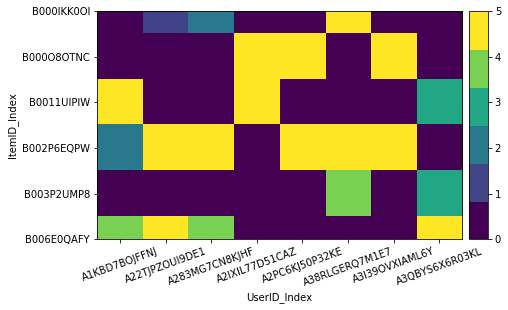

In [167]:
# Вывести матрицу R в графическом виде
# ! Изменить Абсциссы - Х - Пользователи - Субъекты
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

maxRate = 5 # Максимальное значение оценки в шкале

# создать свою цветовую карту, с разделением на 6 участков по количеству оценок
myColorMap = cm.get_cmap('magma', maxRate+1)
myColorMap = cm.get_cmap('viridis', maxRate+1)

# создать полотно размером HхW
fig, ax = plt.subplots(figsize=(7,7))

# отрисовать матрицу применив цветовую карту
im = ax.imshow(data_matrix2, myColorMap, vmax=maxRate)

# добавить названия осей
plt.xlabel('UserID_Index')
plt.ylabel('ItemID_Index')


# добавить подписи осей
plt.xticks( ticks=np.arange(0, len(userUniqList)),
            labels=userUniqList,
            rotation=20)

plt.yticks( ticks=np.arange(0, len(itemUniqList)),
            labels=itemUniqList,
            rotation=0)

# Цветовая шкала
# магия для корретного размера цветовой шкалы
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# отобразить цветовую шкалу 
plt.colorbar(im, cax=cax)

### Результаты тестирования 
После получения вычисленных оценок на исключенных элементах (отложенная часть), для удобства обработки результатов объединим значения (изъятые в отложенную выборку и расчитанные алгоритмами) в списки, сохраняя взаимный порядок элементов
```
RealRate    = [4,   5,  5]
EuclidRate  = [5, 5, 5]
ManhattanRate  = [5, 5, 5]
PearsonRate  = [5, 5, 5]
JaccardRate  = [5, 5, 5]
CosRate      = [5, 5, 5]
```

In [169]:
x1_Real      = [4,   5,   5]
y1_Euclid    = [5, 5, 5]
y1_Pearson    = [5, 5, 5]
y1_Manhetton = [5, 5, 5]
y1_Jaccard = [5, 5, 5]
y1_Cos = [5, 5, 5]

print("x1_Real      = ", x1_Real)
print("y1_Euclid    = ",y1_Euclid)
print("y1_Pearson    = ",y1_Pearson)
print("y1_Manhetton = ", y1_Manhetton)
print("y1_Jaccard   = ", y1_Jaccard)
print("y1_Cos       = ", y1_Cos)

x1_Real      =  [4, 5, 5]
y1_Euclid    =  [5, 5, 5]
y1_Pearson    =  [5, 5, 5]
y1_Manhetton =  [5, 5, 5]
y1_Jaccard   =  [5, 5, 5]
y1_Cos       =  [5, 5, 5]


## Диаграмма рассеяние вычисленных значений

Построим диаграмму рассеяных значений

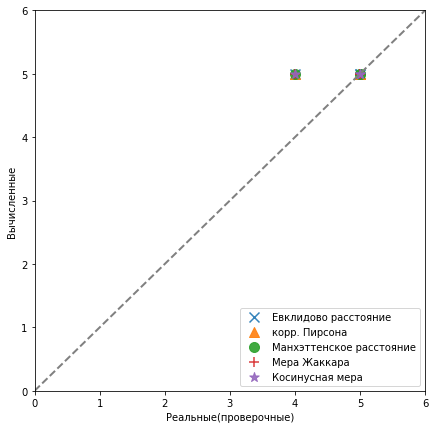

In [170]:
# Построить диаграмму рассеяния
# создать полотно размером HхW
fig, ax = plt.subplots(figsize=(7,7))

# Нанести точки (scatter)
ax.scatter(x1_Real, y1_Euclid, marker='x', s=100, alpha=0.9, label='Евклидово расстояние') # точечная диаграмма 
ax.scatter(x1_Real, y1_Pearson, marker='^', s=100, alpha=0.9, label='корр. Пирсона') # точечная диаграмма
ax.scatter(x1_Real, y1_Manhetton, marker='o', s=100, alpha=0.9, label='Манхэттенское расстояние') # точечная диаграмма 
ax.scatter(x1_Real, y1_Jaccard, marker='+', s=100, alpha=0.9, label='Мера Жаккара') # точечная диаграмма 
ax.scatter(x1_Real, y1_Cos, marker='*', s=100, alpha=0.9, label='Косинусная мера') # точечная диаграмма 

# Нанести график (plot)
ax.plot( [0,6], [0,6], lw=2,   color='gray',  linestyle='dashed',) # график проверочный

ax.legend(loc="lower right")  # отобразить легенду
ax.set_xlabel('Реальные(проверочные)') # посдпись оси X
ax.set_ylabel('Вычисленные')           # посдпись оси Y
ax.set_xlim([0,5+1]) # диапазон значений X
ax.set_ylim([0,5+1]) # диапазон значений Y
plt.show()

## Расчет RMSE

In [171]:
import math

def calculate_error(Predict, Actual):
    if len(Predict)!=len(Actual):
        raise BaseException("Кол-во элементов не совпадает")
    
    sumSquare=0
    # Получить сумму квадратов разностей
    for i in range (0, len(Predict)):
        sumSquare+= (Predict[i] - Actual[i])**2

    return math.sqrt(sumSquare)
    
# ----------------------------------

In [172]:
# Пример для получения значения  
print ("(Евклидово расстояние)     RMSE=", calculate_error(
                Predict=y1_Euclid, 
                Actual=x1_Real))
print ("(Манхэттенское расстояние)     RMSE=", calculate_error(
                Predict=y1_Manhetton, 
                Actual=x1_Real))
print ("(корр. Пирсона)     RMSE=", calculate_error(
                Predict=y1_Pearson, 
                Actual=x1_Real))
print ("(Мера Жаккара)     RMSE=", calculate_error(
                Predict=y1_Jaccard, 
                Actual=x1_Real))
print ("(Косинусная мера)     RMSE=", calculate_error(
                Predict=y1_Cos, 
                Actual=x1_Real))


(Евклидово расстояние)     RMSE= 1.0
(Манхэттенское расстояние)     RMSE= 1.0
(корр. Пирсона)     RMSE= 1.0
(Мера Жаккара)     RMSE= 1.0
(Косинусная мера)     RMSE= 1.0


# Выводы

- В результате сравнения эффективности алгоритмов коллаборативной фильтрации, было выявлено, что item-based показывает лучшие результаты заполненности матрицы для наших исходных данных
- Расчитанная среднеквадратичная ошибка говорит о одинаковых результатом прогнозирования для item-based (для полученной матрицы)